# Import Packages

In [143]:
import hddm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import ssms
import torch
import scipy

Text(0.5, 0, 'proportion of occurence')

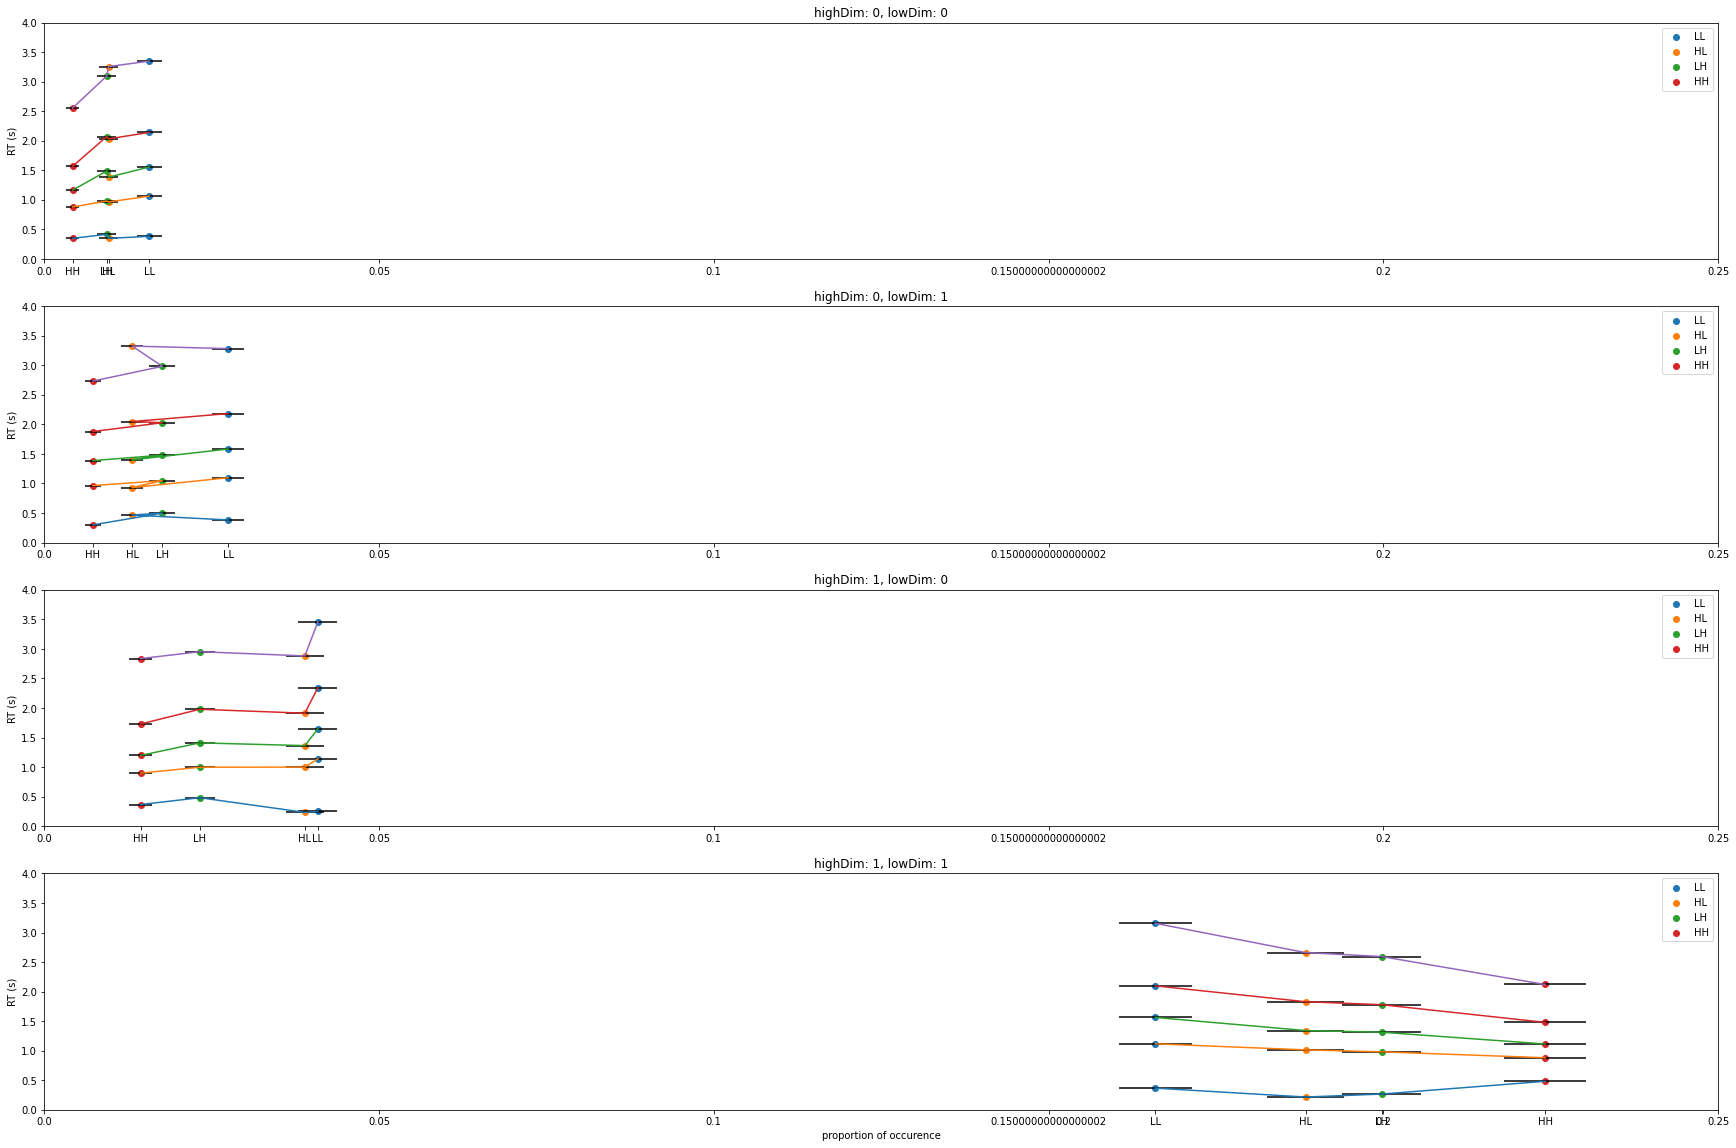

In [ ]:
# plotting all answer types by coherence and quantile
nquants = 5
npoints = chong_data.shape[0]
plt.figure(figsize=(30,20))
for lowDim in [0,1]:
  lowDim_t = chong_data.isLowCorrect==lowDim
  for highDim in [0,1]:
    highDim_t = chong_data.isHighCorrect==highDim
    x_labels = []
    all_quants = []
    plt.subplot(4,1,lowDim*1 + highDim*2 + 1)
    for lowDimCoh in [1,2]:
      lowDimCoh_t = chong_data.lowDimCoh==lowDimCoh
      for highDimCoh in [1,2]:
        highDimCoh_t = chong_data.highDimCoh==highDimCoh
        data_t = highDim_t*highDimCoh_t*lowDim_t*lowDimCoh_t
        data = chong_data['rt'][data_t]
        quant_data = quantile_list(data,nquants)
        rate = np.sum(data_t)/npoints
        plt.scatter(np.repeat(rate,nquants),quant_data)
        x_labels.append(rate)
        all_quants.append(quant_data)
    plt.xticks(ticks=x_labels+list(np.arange(0,0.3,0.05)),labels=['LL','HL','LH','HH']+list(np.arange(0,0.3,0.05)))
    all_quants = np.array(all_quants)
    #plt.xticks(ticks=x_labels,labels=np.round(x_labels,3))
    plt.legend(['LL','HL','LH','HH'])
    plt.xlim((0,0.25))
    plt.title('highDim: {}, lowDim: {}'.format(highDim,lowDim))
    plt.ylabel('RT (s)')
    plt.ylim((0,4))
    #plt.plot(x_labels,all_quants)
    for i in range(nquants):
      xerr = []
      for j in range(4):
        xerr.append(error_bars(x_labels[j],npoints))
      plt.errorbar(x_labels,all_quants[:,i],xerr=xerr,ecolor='k')
plt.xlabel('proportion of occurence')

        #data = chong_data.where("high")
        #plt.plot()


In [ ]:
chong_data.columns

Index(['anglePer', 'blockN', 'colorPer', 'correct', 'highDim', 'highDimCoh',
       'irrDim', 'irrDimCoh', 'lineCoh', 'lineDir', 'angleOption', 'lowDim',
       'lowDimCoh', 'response', 'rxtime', 'subj', 'isHighCorrect',
       'isLowCorrect', 'lineOption', 'Unnamed: 19', 'rt', 'stim', 'subj_idx',
       'cond', 'cond2'],
      dtype='object')

ddm_mic2_adj

In [ ]:
## function that splits data into quantiles
def quantile_list(data,nquantiles):
  quantiles_list = []
  for i in range(nquantiles):
    q = i/nquantiles
    quantiles_list.append(np.quantile(data,q))
  return np.array(quantiles_list)

Test Julia Parameter Recovery

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.lite.TFLiteConverter.from_saved_model("/Users/thomas/downloads/tfhddm/hddm/keras_models/my_keras_model")

Metal device set to: Apple M1


2021-09-14 19:58:14.729320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-14 19:58:14.729448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Subject 13 (index 12) is too fast and vast majority are errors

In [ ]:
model = hddm.load('data/tsumme/hddm_out/ddm_par2_no_bias_chong_cond_group_True_model')

# Functions

In [24]:
def sample_from_posterior(model, 
                          traces,
                          chong_data,
                          bySubj,
                          byTask,
                          byCoh,
                          nthetas):
  # Initialize Data
  model_data = pd.DataFrame(np.zeros((chong_data.shape[0] * nthetas, 15)),
    columns=['highDim','highDimCoh','irrDim','irrDimCoh','lowDim','lowDimCoh','response','subj','rt','stim','subj_idx','cond','cond2','isLowCorrect','isHighCorrect'])
  
  counter = 0
  #traces = par2_no_bias.get_traces()
  #traces = model_data
  #static = ['zh','zl1','zl2']
  #traces[static] = 0.5
  """
  if byTask and byCoh:
    dep_spec = '({}.{})'
  elif byTask or byCoh:
    dep_spec = '({})'
  else:
    dep_spec = ''
  if bySubj:
    dep_loc_spec = '_subj' + dep_spec + '.{}'
    ind_loc_spec = '_subj.{}'
  else:
    dep_loc_spec = dep_spec
    ind_loc_spec = ''
  """

  np.random.seed(2)

  # Main loop over subject
  for i in np.unique(chong_data.subj_idx):
    subj_chong = chong_data[chong_data.subj_idx==i]
    high_task = np.unique(subj_chong.highDim)[0]
    low_tasks = np.unique(subj_chong.lowDim)
    #traces = par2_model.get_traces()
    thetas = traces.sample(n=nthetas,replace=True) #100
    #thetas = np.array([1.6562490592806174,0.5373936509144944,1.906132739269382,1.2818890236244702,0.3456810487466709])
    #thetas = np.tile(thetas,(100,1))
    for highDimCoh in [1,2]:
      for low_task in low_tasks:
        subj_task_chong = subj_chong[subj_chong.lowDim==low_task]
        irr_task = low_tasks[low_tasks!=low_task][0]
        for lowDimCoh in [1,2]:
          for irrDimCoh in [1,2]:
            n = len(subj_task_chong[subj_task_chong.cond=='{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)])
            n_tmp = nthetas * n
            if bySubj and byTask and byCoh:
              theta_list = ['vh_subj({}.{}).{}'.format(high_task,highDimCoh,i),
                            'vl1_subj({}.{}).{}'.format(irr_task,irrDimCoh,i),
                            'vl2_subj({}.{}).{}'.format(low_task,lowDimCoh,i),
                            'a_subj.{}'.format(i),
                            ]
            elif byCoh and byTask and (not bySubj):
              theta_list = ['vh({}.{})'.format(high_task,highDimCoh,i),
                            'vl1({}.{})'.format(irr_task,irrDimCoh,i),
                            'vl2({}.{})'.format(low_task,lowDimCoh,i),
                            'a'.format(i)
                            ]
            else:
              return 'Arguments invalid !'

            if "mic2" in model:
              theta_list.append('d'.format(i))
            theta_list.append('t'.format(i))
            if "angle" in model:
              theta_list.append('theta'.format(i))
            if "weibull" in model:
              theta_list.append('alpha'.format(i))
              theta_list.append('beta'.format(i))
            
            out = ssms.basic_simulators.simulator(theta=thetas[theta_list].to_numpy(), model=model, n_samples=n) # theta=thetas[theta_list].to_numpy()
            #print(thetas[theta_list].shape)
            #print(model_data.keys())
            #out = out[['rts','choices']]
            #print(out['choices'].shape)
            
            model_data['highDim'][counter:counter+n_tmp] = high_task
            model_data['highDimCoh'][counter:counter+n_tmp] = highDimCoh
            model_data['irrDim'][counter:counter+n_tmp] = irr_task
            model_data['irrDimCoh'][counter:counter+n_tmp] = irrDimCoh
            model_data['lowDim'][counter:counter+n_tmp] = low_task
            model_data['lowDimCoh'][counter:counter+n_tmp] = lowDimCoh
            
            if bySubj:
              model_data['response'][counter:counter+n_tmp] = out['choices'][:,:,0].flatten()
              model_data['rt'][counter:counter+n_tmp] = out['rts'][:,:,0].flatten()
            else:
              #print(model_data['response'][counter:counter+n])
              #print(out['choices'].flatten())
              model_data['response'][counter:counter+n_tmp] = out['choices'].flatten()
              model_data['rt'][counter:counter+n_tmp] = out['rts'].flatten()
            
            model_data['subj'][counter:counter+n_tmp] = i+1
            model_data['stim'][counter:counter+n_tmp] = '{}{}'.format(high_task,low_task)
            model_data['subj_idx'][counter:counter+n_tmp] = i
            model_data['cond'][counter:counter+n_tmp] = '{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)
            model_data['cond2'][counter:counter+n_tmp] = '{}{}'.format(highDimCoh,lowDimCoh)

            counter += n_tmp

  model_data['isLowCorrect'] = (model_data['response']==1) + (model_data['response']==3)
  model_data['isHighCorrect'] = model_data['response']>=2
  return model_data

In [136]:
def retrieve_data(models,
                  bySubj=True,
                  byTask=True,
                  byCoh=True,
                  nthetas=100,
                  removeSubj=[13]):
  
  # Load Data
  chong_data = hddm.load_csv('downloads/chong_data/chongdata.csv')

  # Add columns we need to datasets
  # Rename rt
  chong_data['rt'] = chong_data['rxtime']
  
  # Stimtype: There are three tasks assigned randomly to highDim choice, lowDim choice and irrDim choice.
  # We know from assignment of HighDim and LowDim which one the IrrDim taks is
  # Finally the column holds strings such as: '11', '12', '13, '21' ... etc.
  chong_data['stim'] = chong_data.highDim.astype(str) + chong_data.lowDim.astype(str)

  # Rename subj --> subj_idx (column name prescribed by HDDM)
  chong_data['subj_idx'] = chong_data['subj'] - 1

  # Code Response as:
  # High Dim choice correct --> add 2
  # Low Dim choice correct --> add 1
  # Column then holds: {3: both correct, 2: high correct low wrong, 1: high wrong low correct, 0: both wrong}
  chong_data['response'] = (chong_data.isHighCorrect*2) + (chong_data.isLowCorrect*1)

  # Creates column 'cond'
  # Coherence levels for each of the high, irrdim, lowdim tasks
  # Holds strings such as: '111', '121', ... etc.
  chong_data['cond'] = chong_data.highDimCoh.astype(str) + chong_data.irrDimCoh.astype(str) + chong_data.lowDimCoh.astype(str)

  # Creats column 'cond2'
  # Like cond, but ignores irrDim
  chong_data['cond2'] = chong_data.highDimCoh.astype(str) + chong_data.lowDimCoh.astype(str)
  
  # Remove subjects from dataset
  for i in removeSubj:
    chong_data = chong_data[chong_data.subj != i]
  
  # Initialize models_data dictionary
  models_data = {}
  models_data['chong_data'] = chong_data
  
  # 
  for model in models:
    # Load HDDM traces for given model:
    model_data = hddm.load('data/tsumme/hddm_out/{}_chong_task_{}_coh_{}_group_{}.db'.format(model, 
                                                                                             byTask, 
                                                                                             byCoh, 
                                                                                             bySubj))
    
    if not bySubj:
      model_keys = [i for i in model_data.keys()][1:-1]
    elif bySubj:
      model_keys = [i for i in model_data.keys() if len(i)<25][1:-1]
    
    model_keys.sort()
    model_keys = model_keys[2:] + model_keys[0:2]
    
    print(model_keys)
    
    model_data = pd.DataFrame(model_data)
    
    if not bySubj:
      model_data = np.stack(model_data[model_keys].to_numpy()[0,:])
      model_data = pd.DataFrame(data=model_data.T,columns=model_keys)
    else:
      model_data = np.stack(model_data[model_keys].to_numpy()[0])
      model_data = pd.DataFrame(data=model_data.T,columns=model_keys)
    #model_data = hddm.load('data/tsumme/hddm_out/{}_chong_task_{}_coh_{}_group_{}_model'.format(model,byTask,byCoh,bySubj)).get_traces()
    models_data[model] = sample_from_posterior(model,model_data,chong_data,bySubj,byTask,byCoh,nthetas)

  #for i in range(nquantiles):
  return models_data

In [26]:
def error_bars(err, length):
  return 2 * np.sqrt(err * (1 - err) / length)

In [ ]:

## function that splits data into quantiles
def quantile_list(data,
                  nquantiles):

  quantiles_list = []
  for i in range(nquantiles):
    q = i / nquantiles
    quantiles_list.append(np.quantile(data, q))
    
  return np.array(quantiles_list)

In [7]:
def quant_prob_plot(data, cond_col, nquants):
  #values = np.unique(data[cond_col])
  l = quantile_list(data['rt'][chong_data['isLowCorrect']==0],nquants)
  q = np.zeros(data['rt'][chong_data['isLowCorrect']==0].shape,dtype=int)
  for i in l:
    q += data['rt'][chong_data['isLowCorrect']==0]>=i
  l2 = quantile_list(data['rt'][chong_data['isHighCorrect']==0],nquants)
  err = [np.mean(chong_data['isLowCorrect']==0),np.mean(chong_data['isHighCorrect']==0)]
  #values, counts = np.unique(q,return_counts=True)
  err = np.array(err)

  plt.scatter(x=np.repeat(err[0],nquants),y=np.array(l))
  plt.scatter(x=np.repeat(err[1],nquants),y=np.array(l2))
  plt.legend(["highDim","lowDim"])
  for i in range(nquants):
    #print(error_bars(err,len(q))[0])
    #plt.scatter(x=err,y=np.array([l[i],l2[i]]))
    
    plt.errorbar(x=err,y=[l[i],l2[i]],xerr=error_bars(err,len(q)))
    #plt.errorbar(2*np.sqrt(err[0]*(1 - err[0]) / len(q)))

In [8]:
def quant_prob_plot(data, cond_col, nquants):
  #values = np.unique(data[cond_col])
  quant_list = []
  for i in cond_col:
    quant_list.append(quantile_list(data['rt'][chong_data[i]],nquants))
  quant_list = np.array(quant_list)

  l = quantile_list(data['rt'][chong_data['isLowCorrect']==0],nquants)
  q = np.zeros(data['rt'][chong_data['isLowCorrect']==0].shape,dtype=int)
  for i in l:
    q += data['rt'][chong_data['isLowCorrect']==0]>=i
  l2 = quantile_list(data['rt'][chong_data['isHighCorrect']==0],nquants)
  err = [np.mean(chong_data['isLowCorrect']==0),np.mean(chong_data['isHighCorrect']==0)]
  #values, counts = np.unique(q,return_counts=True)
  err = np.array(err)

  plt.scatter(x=np.repeat(err[0],nquants),y=np.array(l))
  plt.scatter(x=np.repeat(err[1],nquants),y=np.array(l2))
  plt.legend(["highDim","lowDim"])
  for i in range(nquants):
    #print(error_bars(err,len(q))[0])
    #plt.scatter(x=err,y=np.array([l[i],l2[i]]))
    
    plt.errorbar(x=err,y=[l[i],l2[i]],xerr=error_bars(err,len(q)))
  
    #plt.errorbar(2*np.sqrt(err[0]*(1 - err[0]) / len(q)))
  

In [9]:
def new_quant_plots(model_data,
                    nquants):

  # plotting all answer types by coherence and quantile
  npoints = model_data.shape[0]
  plt.figure(figsize=(30,20))

  for lowDim in [0,1]:
    lowDim_t = model_data.isLowCorrect == lowDim
    
    for highDim in [0,1]:
      highDim_t = model_data.isHighCorrect == highDim
      x_labels = []
      all_quants = []
      plt.subplot(4,1,lowDim*1 + highDim*2 + 1)
      
      for lowDimCoh in [1,2]:
        lowDimCoh_t = model_data.lowDimCoh == lowDimCoh
        
        for highDimCoh in [1,2]:
          highDimCoh_t = model_data.highDimCoh == highDimCoh
          data_t = highDim_t * highDimCoh_t * lowDim_t * lowDimCoh_t

          # extract rts
          data = model_data['rt'][data_t]

          # get quantiles
          quant_data = quantile_list(data, nquants)
          
          rate = np.sum(data_t)/np.sum(highDimCoh_t*lowDimCoh_t)#npoints
          plt.scatter(np.repeat(rate,nquants),quant_data)
          x_labels.append(rate)
          all_quants.append(quant_data)
      
      plt.xticks(ticks=x_labels + list(np.arange(0, 1.05, 0.05)),
                 labels=['LL','HL','LH','HH'] + list(np.arange(0, 1.05, 0.05)))   # AF-Comment: correct ?

      all_quants = np.array(all_quants)

      plt.legend(['LL','HL','LH','HH'])
      plt.title('highDim: {}, lowDim: {}'.format(highDim,lowDim))
      plt.xlim((0,1))
      plt.ylim((0,4))
      plt.ylabel('RT (s)')

      #plt.plot(x_labels,all_quants)
      for i in range(nquants):
        xerr = []
        for j in range(4):
          xerr.append(error_bars(x_labels[j], np.sum(data_t)))
        
        plt.errorbar(x_labels,all_quants[:,i], xerr=0)#xerr=xerr,ecolor='k')
  plt.xlabel('proportion of occurence')

          #data = chong_data.where("high")
          #plt.plot()

In [142]:
model_data = retrieve_data(['ddm_par2_no_bias','ddm_seq2_angle_no_bias','ddm_par2_angle_no_bias'])

['a_subj.0', 'a_subj.1', 'a_subj.10', 'a_subj.11', 'a_subj.13', 'a_subj.14', 'a_subj.15', 'a_subj.16', 'a_subj.17', 'a_subj.18', 'a_subj.19', 'a_subj.2', 'a_subj.20', 'a_subj.21', 'a_subj.22', 'a_subj.23', 'a_subj.24', 'a_subj.25', 'a_subj.26', 'a_subj.27', 'a_subj.28', 'a_subj.29', 'a_subj.3', 'a_subj.30', 'a_subj.31', 'a_subj.32', 'a_subj.33', 'a_subj.34', 'a_subj.35', 'a_subj.36', 'a_subj.4', 'a_subj.5', 'a_subj.6', 'a_subj.7', 'a_subj.8', 'a_subj.9', 't', 't_std', 't_subj.0', 't_subj.1', 't_subj.10', 't_subj.11', 't_subj.13', 't_subj.14', 't_subj.15', 't_subj.16', 't_subj.17', 't_subj.18', 't_subj.19', 't_subj.2', 't_subj.20', 't_subj.21', 't_subj.22', 't_subj.23', 't_subj.24', 't_subj.25', 't_subj.26', 't_subj.27', 't_subj.28', 't_subj.29', 't_subj.3', 't_subj.30', 't_subj.31', 't_subj.32', 't_subj.33', 't_subj.34', 't_subj.35', 't_subj.36', 't_subj.4', 't_subj.5', 't_subj.6', 't_subj.7', 't_subj.8', 't_subj.9', 'vh(1.1)', 'vh(1.2)', 'vh(2.1)', 'vh(2.2)', 'vh(3.1)', 'vh(3.2)', 'vh

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_12689/1918275765.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['subj_idx'][counter:counter+n] = i
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_12689/1918275765.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['cond'][counter:counter+n] = '{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_12689/1918275765.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

FileNotFoundError: ignored

In [ ]:
model_data_2 = retrieve_data(['ddm_par2_no_bias'], bySubj=False);

In [92]:
model_data = retrieve_data(['ddm_par2_no_bias'])

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_10820/2057430648.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['subj_idx'][counter:counter+n] = i
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_10820/2057430648.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['cond'][counter:counter+n] = '{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_10820/2057430648.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

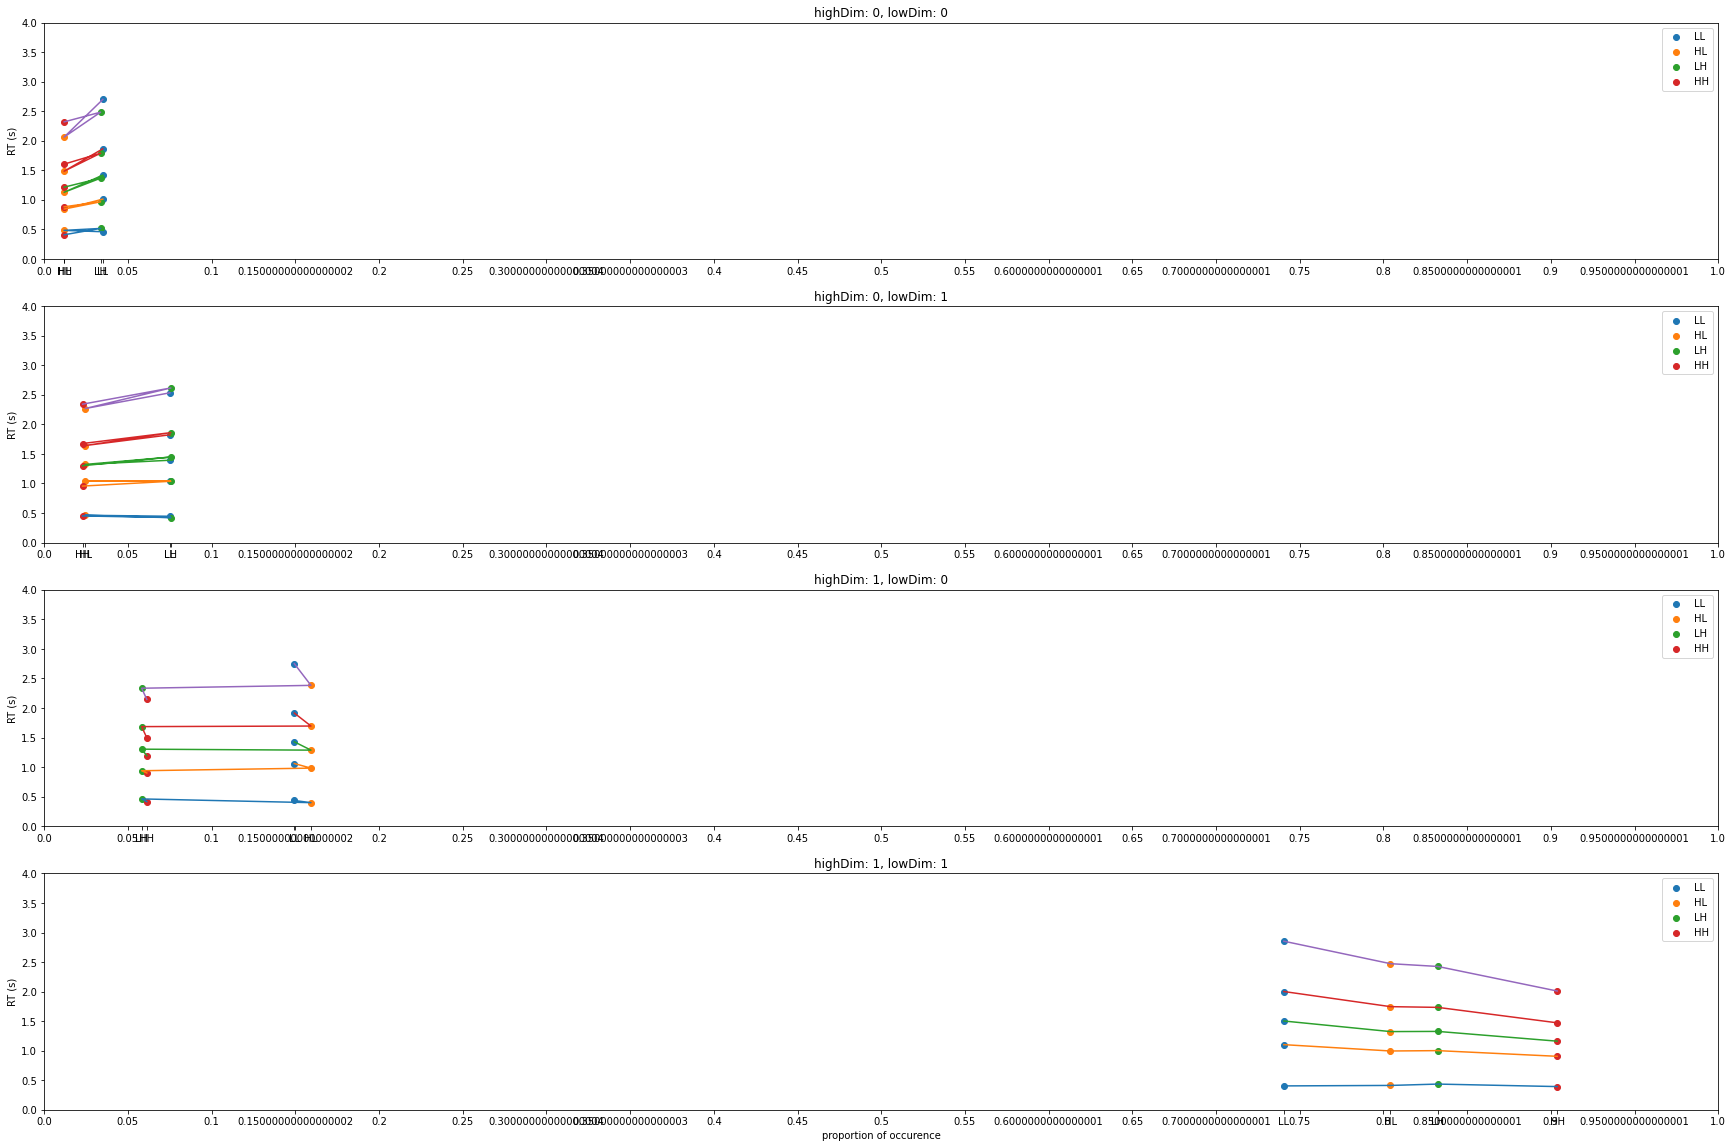

In [138]:
new_quant_plots(model_data["ddm_par2_no_bias"],5)

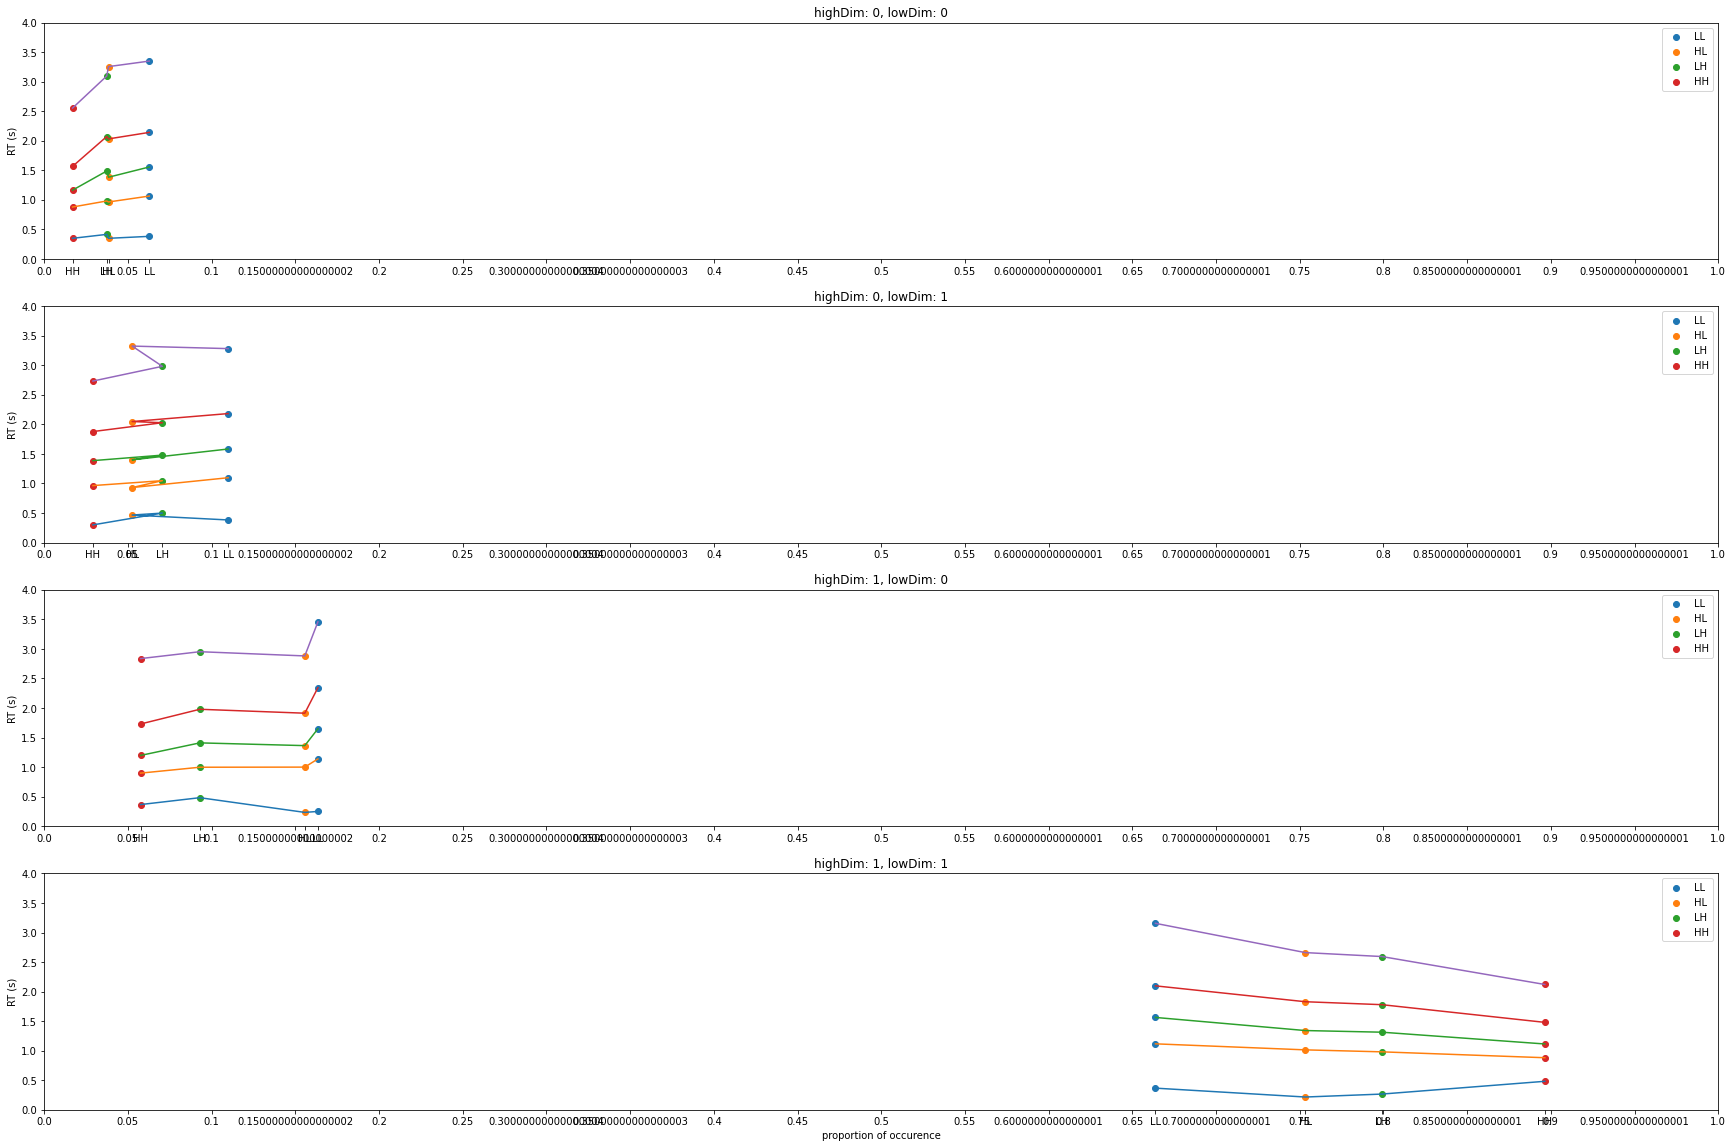

In [ ]:
new_quant_plots(model_data["chong_data"],5)

# Only Chong Data

## Preprocessing

In [ ]:
chong_data = hddm.load_csv('downloads/chong_data/chongdata.csv')

In [ ]:
chong_data['rt'] = chong_data['rxtime']
chong_data['stim'] = chong_data.highDim.astype(str) + chong_data.lowDim.astype(str)
chong_data['subj_idx'] = chong_data['subj'] - 1
chong_data['response'] = chong_data.isHighCorrect*2 + chong_data.isLowCorrect*1
chong_data['cond'] = chong_data.highDimCoh.astype(str) + chong_data.irrDimCoh.astype(str) + chong_data.lowDimCoh.astype(str)
chong_data['cond2'] = chong_data.highDimCoh.astype(str) + chong_data.lowDimCoh.astype(str)

In [ ]:
chong_data = chong_data[chong_data.subj!=13]

In [ ]:
def model_preprocess(model):
  par2_data = hddm.load('data/tsumme/hddm_out/{}.db'.format(model))
  par2_keys = [i for i in par2_data.keys()][1:-1]
  par2_keys.sort()
  par2_keys = par2_keys[2:]+par2_keys[0:2]
  par2_data = pd.DataFrame(par2_data)
  par2_data = np.stack(par2_data[par2_keys].to_numpy()[0,:])
  par2_data = pd.DataFrame(data=par2_data.T,columns=par2_keys)
  static = ['zh','zl1','zl2']
  par2_data[static] = 0.5
  par2_keys = par2_keys[0:-1] + static + [par2_keys[-1]]
  par2_data = par2_data[par2_keys]
  par2_out = {}
  np.random.seed(2)
  thetas = par2_data.sample(n=10000,replace=True)
  for i in [1,2]:
    for j in [1,2]:
      for k in [1,2]:
        theta_list = ['vh({})'.format(i),'vl1({})'.format(j),'vl2({})'.format(k),'a','zh','zl1','zl2','t']
        par2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]
  par2_choice = []
  par2_rt = []
  for key in par2_out.keys():
    par2_rt.append(par2_out[key][0])
    par2_choice.append(par2_out[key][1])
  par2_choice = np.concatenate(par2_choice)
  par2_rt = np.concatenate(par2_rt)

  return par2_data, par2_choice, par2_rt, par2_out

In [ ]:
# nmcmc = 10 #5000
# burn = 1#20 #500
# model = 'ddm_mic2_no_bias'
# n_samples_by_subject = 512
# n_subjects = 36
# is_group_model = True

# depends_on = {'vh': ['highDimCoh','highDim'],'vl1': ['irrDimCoh','irrDim'],'vl2': ['lowDimCoh','lowDim']}
# hddmnn_model_chong = hddm.HDDMnn(chong_data,
#                          model = model,
#                          informative = False,
#                          include = ['vh','vl1','vl2','a','t'],
#                          is_group_model = is_group_model,
#                          depends_on = depends_on,
#                          p_outlier = 0.05)

In [ ]:
# hddmnn_model_chong.sample(nmcmc, burn = burn)

irr = irrelevant

In [ ]:
par2_no_bias = hddm.load('data/tsumme/hddm_out/ddm_par2_no_bias_chong_task_True_coh_True_group_False.db')
par2_keys = [i for i in par2_no_bias.keys()][1:-1]
par2_keys.sort()
par2_keys = par2_keys[2:]+par2_keys[0:2]
par2_no_bias = pd.DataFrame(par2_no_bias)
par2_no_bias = np.stack(par2_no_bias[par2_keys].to_numpy()[0,:])
par2_no_bias = pd.DataFrame(data=par2_no_bias.T, columns=par2_keys)
static = ['zh','zl1','zl2']
par2_no_bias[static] = 0.5
par2_keys = par2_keys[0:-1] + static + [par2_keys[-1]]
par2_no_bias = par2_no_bias[par2_keys]

In [ ]:
par2_data = pd.DataFrame(np.zeros((chong_data.shape[0],13)),
  columns=['highDim','highDimCoh','irrDim','irrDimCoh','lowDim','lowDimCoh','response','subj','rt','stim','subj_idx','cond','cond2'])

Sample from posterior 100 times

set n_samples to n

In [ ]:
counter = 0
#traces = par2_no_bias.get_traces()
traces = par2_no_bias
#static = ['zh','zl1','zl2']
#traces[static] = 0.5
np.random.seed(2)
for i in np.unique(chong_data.subj_idx):
  subj_chong = chong_data[chong_data.subj_idx==i]
  high_task = np.unique(subj_chong.highDim)[0]
  low_tasks = np.unique(subj_chong.lowDim)
  for highDimCoh in [1,2]:
    for low_task in low_tasks:
      subj_task_chong = subj_chong[subj_chong.lowDim==low_task]
      irr_task = low_tasks[low_tasks!=low_task][0]
      for lowDimCoh in [1,2]:
        for irrDimCoh in [1,2]:
          n = len(subj_task_chong[subj_task_chong.cond=='{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)])
          thetas = traces.sample(n=n,replace=True)
          theta_list = ['vh_subj({}.{}).{}'.format(high_task,highDimCoh,i),
                        'vl1_subj({}.{}).{}'.format(irr_task,irrDimCoh,i),
                        'vl2_subj({}.{}).{}'.format(low_task,lowDimCoh,i),
                        'a_subj.{}'.format(i),
                        'zh',
                        'zl1',
                        'zl2',
                        't_subj.{}'.format(i)]
          out = ssms.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]
          par2_data['highDim'][counter:counter+n] = high_task
          par2_data['highDimCoh'][counter:counter+n] = highDimCoh
          par2_data['irrDim'][counter:counter+n] = irr_task
          par2_data['irrDimCoh'][counter:counter+n] = irrDimCoh
          par2_data['lowDim'][counter:counter+n] = low_task
          par2_data['lowDimCoh'][counter:counter+n] = lowDimCoh
          par2_data['response'][counter:counter+n] = out[1][:,0]
          par2_data['subj'][counter:counter+n] = i+1
          par2_data['rt'][counter:counter+n] = out[0][:,0]
          par2_data['stim'][counter:counter+n] = '{}{}'.format(high_task,low_task)
          par2_data['subj_idx'][counter:counter+n] = i
          par2_data['cond'][counter:counter+n] = '{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)
          par2_data['cond2'][counter:counter+n] = '{}{}'.format(highDimCoh,lowDimCoh)
          counter += n

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_16195/1996921410.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par2_data['subj_idx'][counter:counter+n] = i
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_16195/1996921410.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par2_data['cond'][counter:counter+n] = '{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_16195/1996921410.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

## Data Analysis

### Error rates

#### Super-subject error rates

In [ ]:
# Defining RT bins and calculating the proportion of errors in each bin
bins = np.array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5 ])
bins = quantile_list(chong_data['rt'],8)
chong_high_err = []
chong_low_err = []
for i in bins:
  err_high = np.sum((chong_data[chong_data.response<2]['rt'][chong_data[chong_data.response<2]['rt']<(i+0.5)])>=i)
  total = np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((chong_data[(chong_data.response==0) | (chong_data.response==2)]['rt'][chong_data[(chong_data.response==0) | (chong_data.response==2)]['rt']<(i+0.5)])>=i)
  chong_high_err.append(err_high/total)
  chong_low_err.append(err_low/total)

In [ ]:
# Defining RT bins and calculating the proportion of exclusive errors in each bin
bins = np.array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5 ])
bins = quantile_list(chong_data['rt'],8)
chong_high_err = []
chong_low_err = []
chong_high_err_bar = []
chong_low_err_bar = []
chong_totals = []
for i in bins:
  err_high = np.sum((chong_data[chong_data.response==1]['rt'][chong_data[chong_data.response==1]['rt']<(i+0.5)])>=i)
  total = np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((chong_data[(chong_data.response==2) | (chong_data.response==2)]['rt'][chong_data[(chong_data.response==2) | (chong_data.response==2)]['rt']<(i+0.5)])>=i)
  chong_high_err.append(err_high/total)
  chong_low_err.append(err_low/total)
  chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
  chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
  chong_totals.append(total)

In [ ]:
chong_high_err = np.nan_to_num(np.array(chong_high_err))
chong_low_err = np.nan_to_num(np.array(chong_low_err))
chong_high_err_bar = np.nan_to_num(chong_high_err_bar)
chong_low_err_bar = np.nan_to_num(chong_low_err_bar)
chong_totals = np.nan_to_num(chong_totals)

Separate out into exclusive error patterns

TypeError: ignored

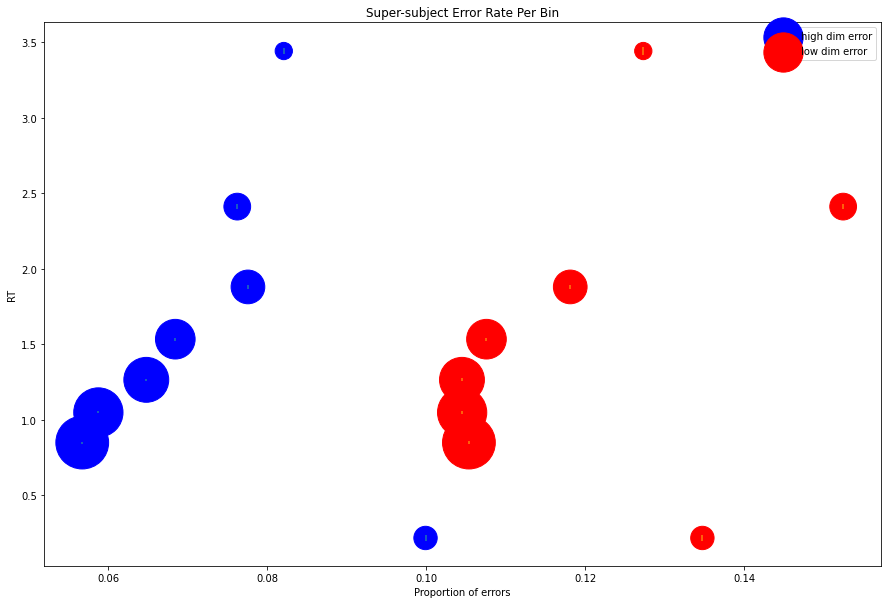

In [ ]:
plt.figure(figsize=(15,10))
plt.errorbar(y=bins,x=chong_high_err,yerr=chong_high_err_bar,ls = "None")
plt.scatter(y=bins,x=chong_high_err,s=chong_totals/2,color='b')
plt.errorbar(y=bins,x=chong_low_err,yerr=chong_low_err_bar,ls = "None")
plt.scatter(y=bins,x=chong_low_err,s=chong_totals/2,color='r')
plt.legend(['high dim error', 'low dim error'])
plt.title('Super-subject Error Rate Per Bin')
plt.ylabel("RT")
plt.xlabel('Proportion of errors')
plt.plot(np.stack([chong_low_err,chong_high_err],bins))
#plt.xticks(np.arange(0, 10, step=0.5),np.arange(0, 10, step=0.5));

#### Error rates by participant

In [ ]:
chong_group_data = []
for i in np.unique(chong_data['subj']):
  chong_group_data.append(chong_data[chong_data['subj']==i])

In [ ]:
# Calculate error rate per bin for each subject
chong_group_high_err = []
chong_group_low_err = []
chong_group_high_err_bar = []
chong_group_low_err_bar = []
chong_group_totals = []
for j in range(36):
  chong_high_err = []
  chong_low_err = []
  chong_high_err_bar = []
  chong_low_err_bar = []
  chong_totals = []
  for i in bins:
    err_high = np.sum((chong_group_data[j][chong_group_data[j].response==1]['rt'][chong_group_data[j][chong_group_data[j].response==1]['rt']<(i+0.5)])>=i)
    total = np.sum((chong_group_data[j]['rt'][chong_group_data[j]['rt']<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((chong_group_data[j][(chong_group_data[j].response==2) | (chong_group_data[j].response==2)]['rt'][chong_group_data[j][(chong_group_data[j].response==2) | (chong_group_data[j].response==2)]['rt']<(i+0.5)])>=i)
    chong_high_err.append(err_high/total)
    chong_low_err.append(err_low/total)
    chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
    chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
    chong_totals.append(total)
  chong_group_totals.append(chong_totals)
  chong_group_high_err.append(chong_high_err)
  chong_group_low_err.append(chong_low_err)
  chong_group_high_err_bar.append(chong_high_err_bar)
  chong_group_low_err_bar.append(chong_low_err_bar)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_82178/3839202324.py:18: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_82178/3839202324.py:19: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


In [ ]:
chong_group_high_err = np.nan_to_num(np.array(chong_group_high_err))
chong_group_low_err = np.nan_to_num(np.array(chong_group_low_err))
chong_group_high_err_bar = np.nan_to_num(chong_group_high_err_bar)
chong_group_low_err_bar = np.nan_to_num(chong_group_low_err_bar)
chong_group_totals = np.nan_to_num(chong_group_totals)

Not for today

In [ ]:
# # Plotting Summary Stats
# plt.figure(figsize=(20,5))
# plt.subplot(1,2,1)
# plt.boxplot(chong_group_high_err);
# plt.title('Boxplot of Error Rate Per Subject For Each Bin (High Dim)')
# plt.xlabel("RT")
# plt.ylabel('Proportion of errors')
# plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));

# plt.subplot(1,2,2)
# plt.boxplot(chong_group_low_err);
# plt.title('Boxplot of Error Rate Per Subject For Each Bin (Low Dim)')
# plt.xlabel("RT")
# plt.ylabel('Proportion of errors')
# plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));

Specify rejection criteria (such as not showing bin if below certain total count)

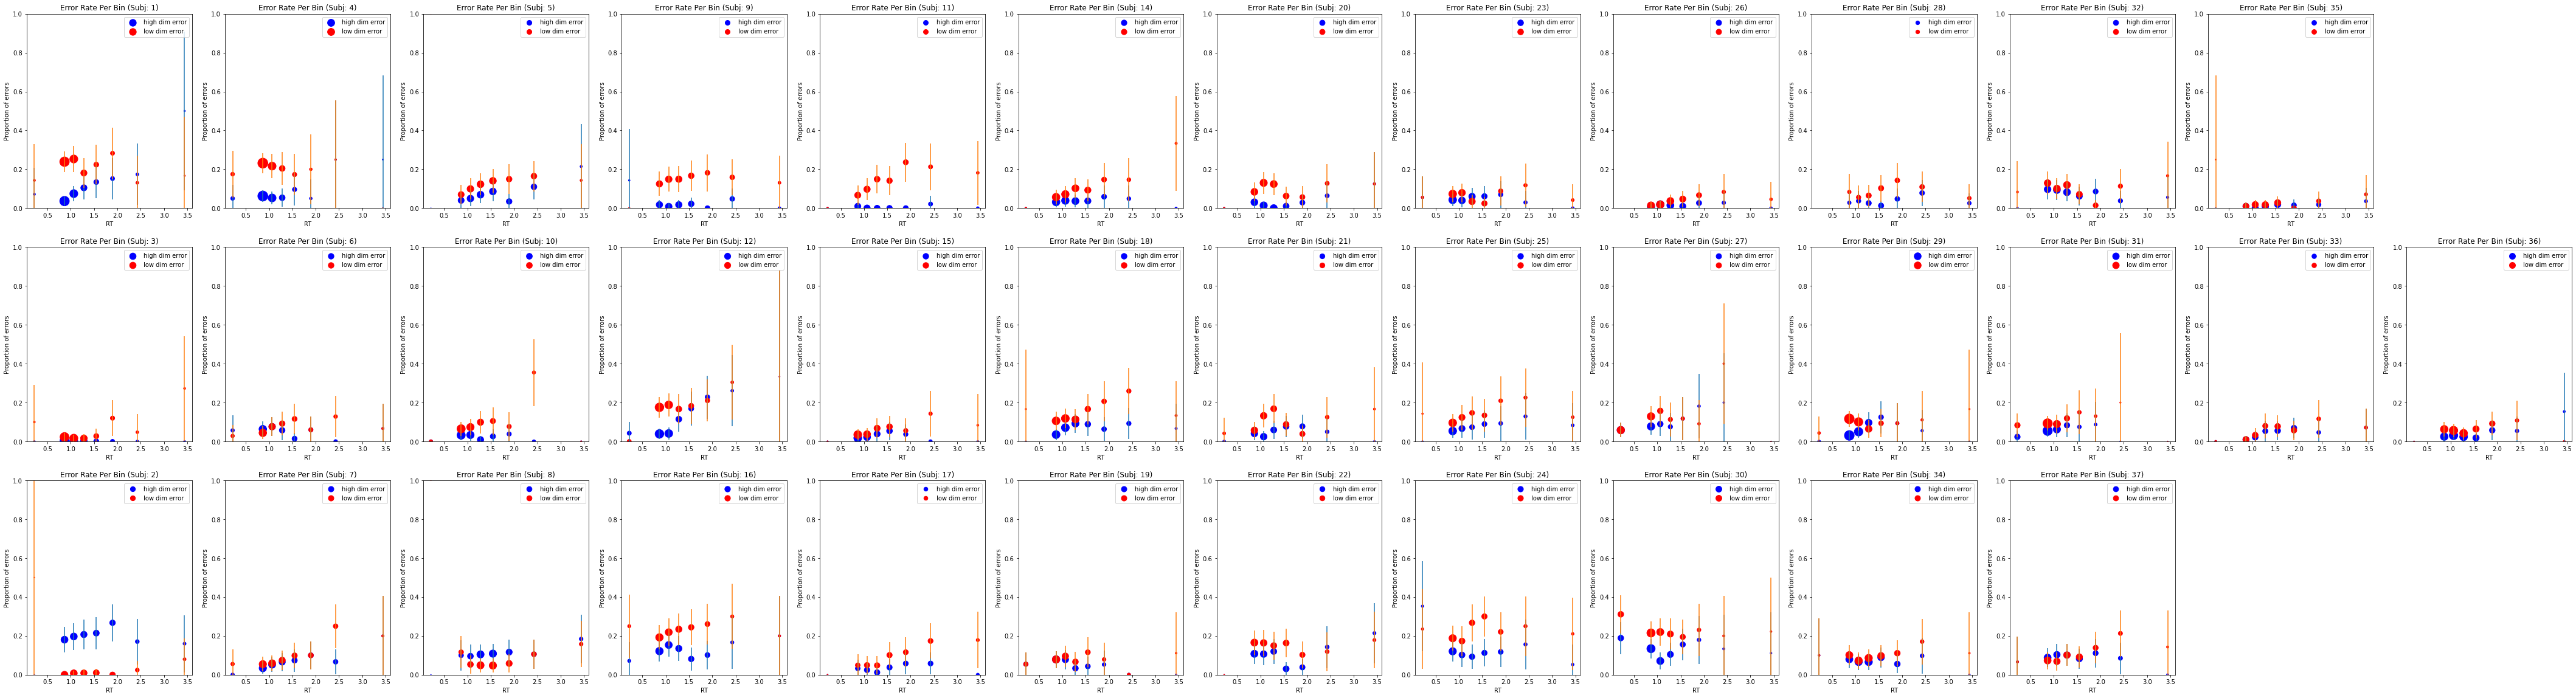

In [ ]:
#Plot each subject
subj_order = np.concatenate([cond_subj_id[0],cond_subj_id[2],cond_subj_id[4]]) #run condition cells first
#subj_loc = np.concatenate([cond_subj_id[0],cond_subj_id[2]+13,cond_subj_id[4]+26])
subj_id = np.unique(chong_data.subj)
plt.figure(figsize=(75,20))
for ind,i in enumerate(np.unique(chong_data.subj_idx)):
  if i+1 in cond_subj_id[0]:
    loc = np.where(cond_subj_id[0]==i+1)[0][0] + 1
  if i+1 in cond_subj_id[2]:
    loc = np.where(cond_subj_id[2]==i+1)[0][0] + 14
  if i+1 in cond_subj_id[4]:
    loc = np.where(cond_subj_id[4]==i+1)[0][0] + 27
  plt.subplot(3,13,loc,ylim=(0,1))
  plt.errorbar(x=bins,y=chong_group_high_err[ind,:],yerr=chong_group_high_err_bar[ind,:],ls = "None")
  plt.scatter(x=bins,y=chong_group_high_err[ind,:],s=chong_group_totals[ind],color='b')
  plt.errorbar(x=bins,y=chong_group_low_err[ind,:],yerr=chong_group_low_err_bar[ind,:],ls = "None")
  plt.scatter(x=bins,y=chong_group_low_err[ind,:],s=chong_group_totals[ind],color='r')
  plt.legend(['high dim error', 'low dim error'])
  plt.title('Error Rate Per Bin (Subj: {})'.format(i+1))
  plt.xlabel("RT")
  plt.ylabel('Proportion of errors')

#### Super-subject error rates by task dimension

In [ ]:
chong_cond_data = []
for i in np.unique(chong_data['stim']):
  chong_cond_data.append(chong_data[chong_data['stim']==i])

In [ ]:
chong_cond_group_data = []
cond_subj_id = []
for i in range(6):
  chong_cond_subj_data = []
  cond_subj_id.append(np.unique(chong_cond_data[i]['subj']))
  for j in np.unique(chong_cond_data[i]['subj']):
    chong_cond_subj_data.append(chong_cond_data[i][chong_cond_data[i]['subj']==j])
  chong_cond_group_data.append(chong_cond_subj_data)

In [ ]:
chong_cond_high_err = []
chong_cond_low_err = []
chong_cond_high_err_bar = []
chong_cond_low_err_bar = []
chong_cond_totals = []
for j in range(6):
  chong_high_err = []
  chong_low_err = []
  chong_high_err_bar = []
  chong_low_err_bar = []
  chong_totals = []
  for i in bins:
    err_high = np.sum((chong_cond_data[j][chong_cond_data[j].response<2]['rt'][chong_cond_data[j][chong_cond_data[j].response<2]['rt']<(i+0.5)])>=i)
    total = np.sum((chong_cond_data[j]['rt'][chong_cond_data[j]['rt']<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((chong_cond_data[j][(chong_cond_data[j].response==0) | (chong_cond_data[j].response==2)]['rt'][chong_cond_data[j][(chong_cond_data[j].response==0) | (chong_cond_data[j].response==2)]['rt']<(i+0.5)])>=i)
    chong_high_err.append(err_high/total)
    chong_low_err.append(err_low/total)
    chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
    chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
    chong_totals.append(total)
  chong_cond_totals.append(chong_totals)
  chong_cond_high_err.append(chong_high_err)
  chong_cond_low_err.append(chong_low_err)
  chong_cond_high_err_bar.append(chong_high_err_bar)
  chong_cond_low_err_bar.append(chong_low_err_bar)

In [ ]:
chong_cond_high_err = np.nan_to_num(chong_cond_high_err)
chong_cond_low_err = np.nan_to_num(chong_cond_low_err)
chong_cond_high_err_bar = np.nan_to_num(chong_cond_high_err_bar)
chong_cond_low_err_bar = np.nan_to_num(chong_cond_low_err_bar)
chong_cond_totals = np.nan_to_num(chong_cond_totals)

1 is lineDir

2 is colorPer

3 is anglePer/angleOption



Also split by coherence level

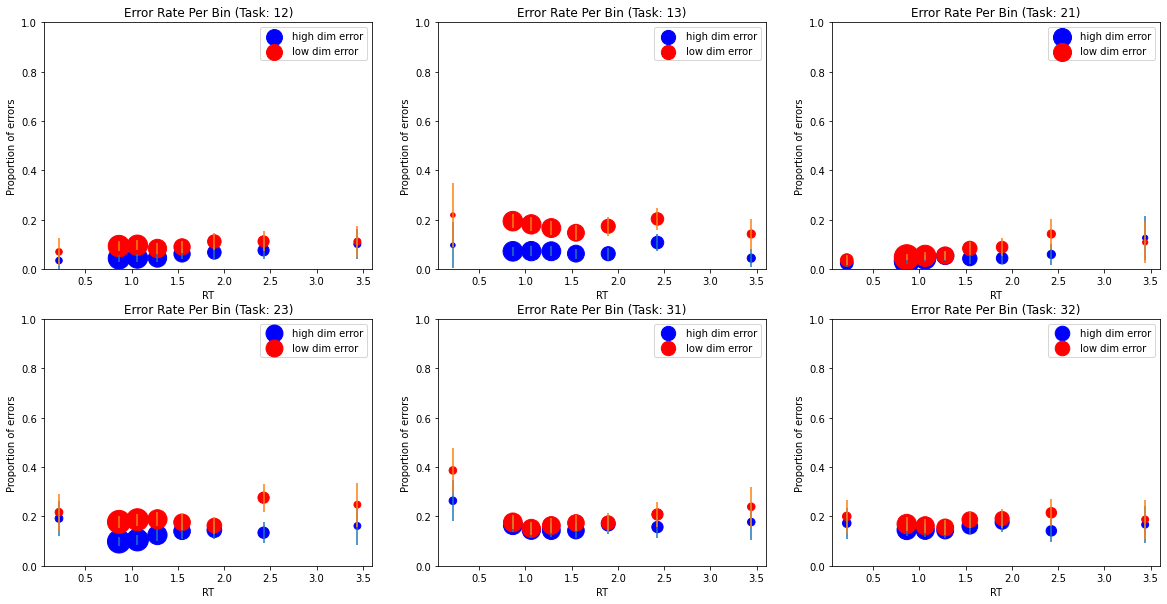

In [ ]:
#Plot each condition
conditions = np.unique(chong_data['stim'])
plt.figure(figsize=(20,10))
for i in range(6):
  plt.subplot(2,3,i+1,ylim=(0,1))
  plt.errorbar(x=bins,y=chong_cond_high_err[i,:],yerr=chong_cond_high_err_bar[i,:],ls = "None")
  plt.scatter(x=bins,y=chong_cond_high_err[i,:],s=chong_cond_totals[i]/2,color='b')
  plt.errorbar(x=bins,y=chong_cond_low_err[i,:],yerr=chong_cond_low_err_bar[i,:],ls = "None")
  plt.scatter(x=bins,y=chong_cond_low_err[i,:],s=chong_cond_totals[i]/2,color='r')
  plt.legend(['high dim error', 'low dim error'])
  plt.title('Error Rate Per Bin (Task: {})'.format(conditions[i]))
  plt.xlabel("RT")
  plt.ylabel('Proportion of errors')

In [ ]:
chong_cond_group_high_err = []
chong_cond_group_low_err = []
for j in range(6):
  chong_cond_high_err = []
  chong_cond_low_err = []
  for k in range(len(cond_subj_id[j])):
    chong_high_err = []
    chong_low_err = []
    for i in bins:
      err_high = np.sum((chong_cond_group_data[j][k][chong_cond_group_data[j][k].response==1]['rt'][chong_cond_group_data[j][k][chong_cond_group_data[j][k].response==1]['rt']<(i+0.5)])>=i)
      total = np.sum((chong_cond_group_data[j][k]['rt'][chong_cond_group_data[j][k]['rt']<(i+0.5)])>=i)
      #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
      err_low = np.sum((chong_cond_group_data[j][k][(chong_cond_group_data[j][k].response==2) | (chong_cond_group_data[j][k].response==2)]['rt'][chong_cond_group_data[j][k][(chong_cond_group_data[j][k].response==2) | (chong_cond_group_data[j][k].response==2)]['rt']<(i+0.5)])>=i)
      chong_high_err.append(err_high/total)
      chong_low_err.append(err_low/total)
    chong_cond_high_err.append(chong_high_err)
    chong_cond_low_err.append(chong_low_err)
  chong_cond_high_err = np.nan_to_num(chong_cond_high_err)
  chong_cond_low_err = np.nan_to_num(chong_cond_low_err)
  chong_cond_group_high_err.append(chong_cond_high_err)
  chong_cond_group_low_err.append(chong_cond_low_err)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_82178/1593939319.py:14: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_82178/1593939319.py:15: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


Add graphs across those groups (check for changes between groups)

In [ ]:
# conditions = np.unique(chong_data['stim'])
# plt.figure(figsize=(30,45))
# for i in range(6):
#   plt.subplot(4,3,i+1,ylim=(0,1))
#   plt.boxplot(chong_cond_group_high_err[i]);
#   plt.title('Boxplot of Error Rate Per Subject For Each Bin (High Dim)(Condition: {})'.format(conditions[i]))
#   plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));
#   #plt.hist(np.arange(0, 10, step=0.5),bins=20, histtype='step', weights=chong_group_low_err[i,:])
#   #plt.legend(['high dim error', 'low dim error'])
#   #plt.title('Error Rate Per Bin (Condition: {})'.format(conditions[i]))
#   plt.xlabel("RT")
#   plt.ylabel('Proportion of errors')

# for i in range(6):
#   plt.subplot(4,3,i+7,ylim=(0,1))
#   plt.boxplot(chong_cond_group_low_err[i]);
#   plt.title('Boxplot of Error Rate Per Subject For Each Bin (Low Dim)(Condition: {})'.format(conditions[i]))
#   plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));
#   #plt.hist(np.arange(0, 10, step=0.5),bins=20, histtype='step', weights=chong_group_low_err[i,:])
#   #plt.legend(['high dim error', 'low dim error'])
#   #plt.title('Error Rate Per Bin (Condition: {})'.format(conditions[i]))
#   plt.xlabel("RT")
#   plt.ylabel('Proportion of errors')

In [ ]:
# plt.figure(figsize=(20,10))
# for i in range(2):
#   plt.subplot(2,3,1,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i],axis=0),'o-');
#   plt.title('"1" group high dim err')
#   plt.legend(['12','13'])
#   plt.xticks(np.arange(0,20),np.arange(0,10,step=0.5))
# for i in range(2):
#   plt.subplot(2,3,2,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i+2],axis=0),'o-');
#   plt.title('"2" group high dim err')
#   plt.legend(['21','23'])
#   plt.xticks(np.arange(0,20),np.arange(0,10,step=0.5))
# for i in range(2):
#   plt.subplot(2,3,3,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i+4],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,4,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,5,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i+2],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,6,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i+4],axis=0),'o-');

### Reaction Time Behavior

#### Super-subject RT behavior

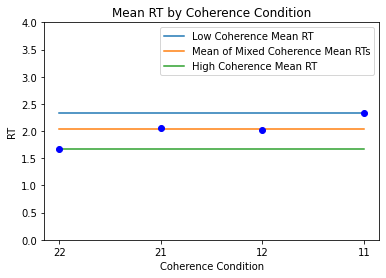

In [ ]:
# Calculate median rt for each coherence level
chong_median_rt = []
chong_sterr_rt = []
coh_conds = ['22','21','12','11']
top_line = np.mean(chong_data.rt[chong_data.cond2=='11'])
bottom_line = np.mean(chong_data.rt[chong_data.cond2=='22'])
middle_line = np.mean([np.mean(chong_data.rt[chong_data.cond2=='21']),np.mean(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
  chong_sterr_rt.append(np.std(chong_data.rt[chong_data.cond2==i])/np.sqrt(len(chong_data.rt[chong_data.cond2==i])))
plt.ylim((0,4))
plt.plot(coh_conds,[top_line,top_line,top_line,top_line])
plt.plot(coh_conds,[middle_line,middle_line,middle_line,middle_line])
plt.plot(coh_conds,[bottom_line,bottom_line,bottom_line,bottom_line])
#plt.plot(coh_conds,chong_median_rt,'bo')
plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"])
plt.ylabel("RT")
plt.xlabel("Coherence Condition")
plt.title("Mean RT by Coherence Condition");

#### Per subject RT behavior

In [ ]:
# # Plotting summary stats
# chong_median_rt = []
# coh_conds = ['22','21','12','11']
# #top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
# #bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
# #middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
# for i in coh_conds:
#   chong_median_rt.append(np.median(chong_data.rt[chong_data.cond2==i]))
# top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
# bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
# mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
# middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
# plt.ylim((0,4))
# chong_group_median_rt = []
# for j in range(36):
#   chong_median_rt = []
#   for i in coh_conds:
#     chong_median_rt.append(np.median(chong_group_data[j].rt[chong_group_data[j].cond2==i]))
#   chong_group_median_rt.append(chong_median_rt)
# chong_group_median_rt = np.array(chong_group_median_rt)
# plt.plot(coh_conds,top_line)
# plt.plot(coh_conds,middle_line)
# plt.plot(coh_conds,bottom_line)
# plt.boxplot(chong_group_median_rt,positions=[0,1,2,3])
# plt.xticks([0,1,2,3],coh_conds)
# plt.legend(["Low Coherence Median RT","Mean of Mixed Coherence Median RTs","High Coherence Median RT"])
# plt.ylabel("RT")
# plt.xlabel("Coherence Condition")
# plt.title("Boxplot of Subject Median RTs by Coherence Condition");

Add Error bars

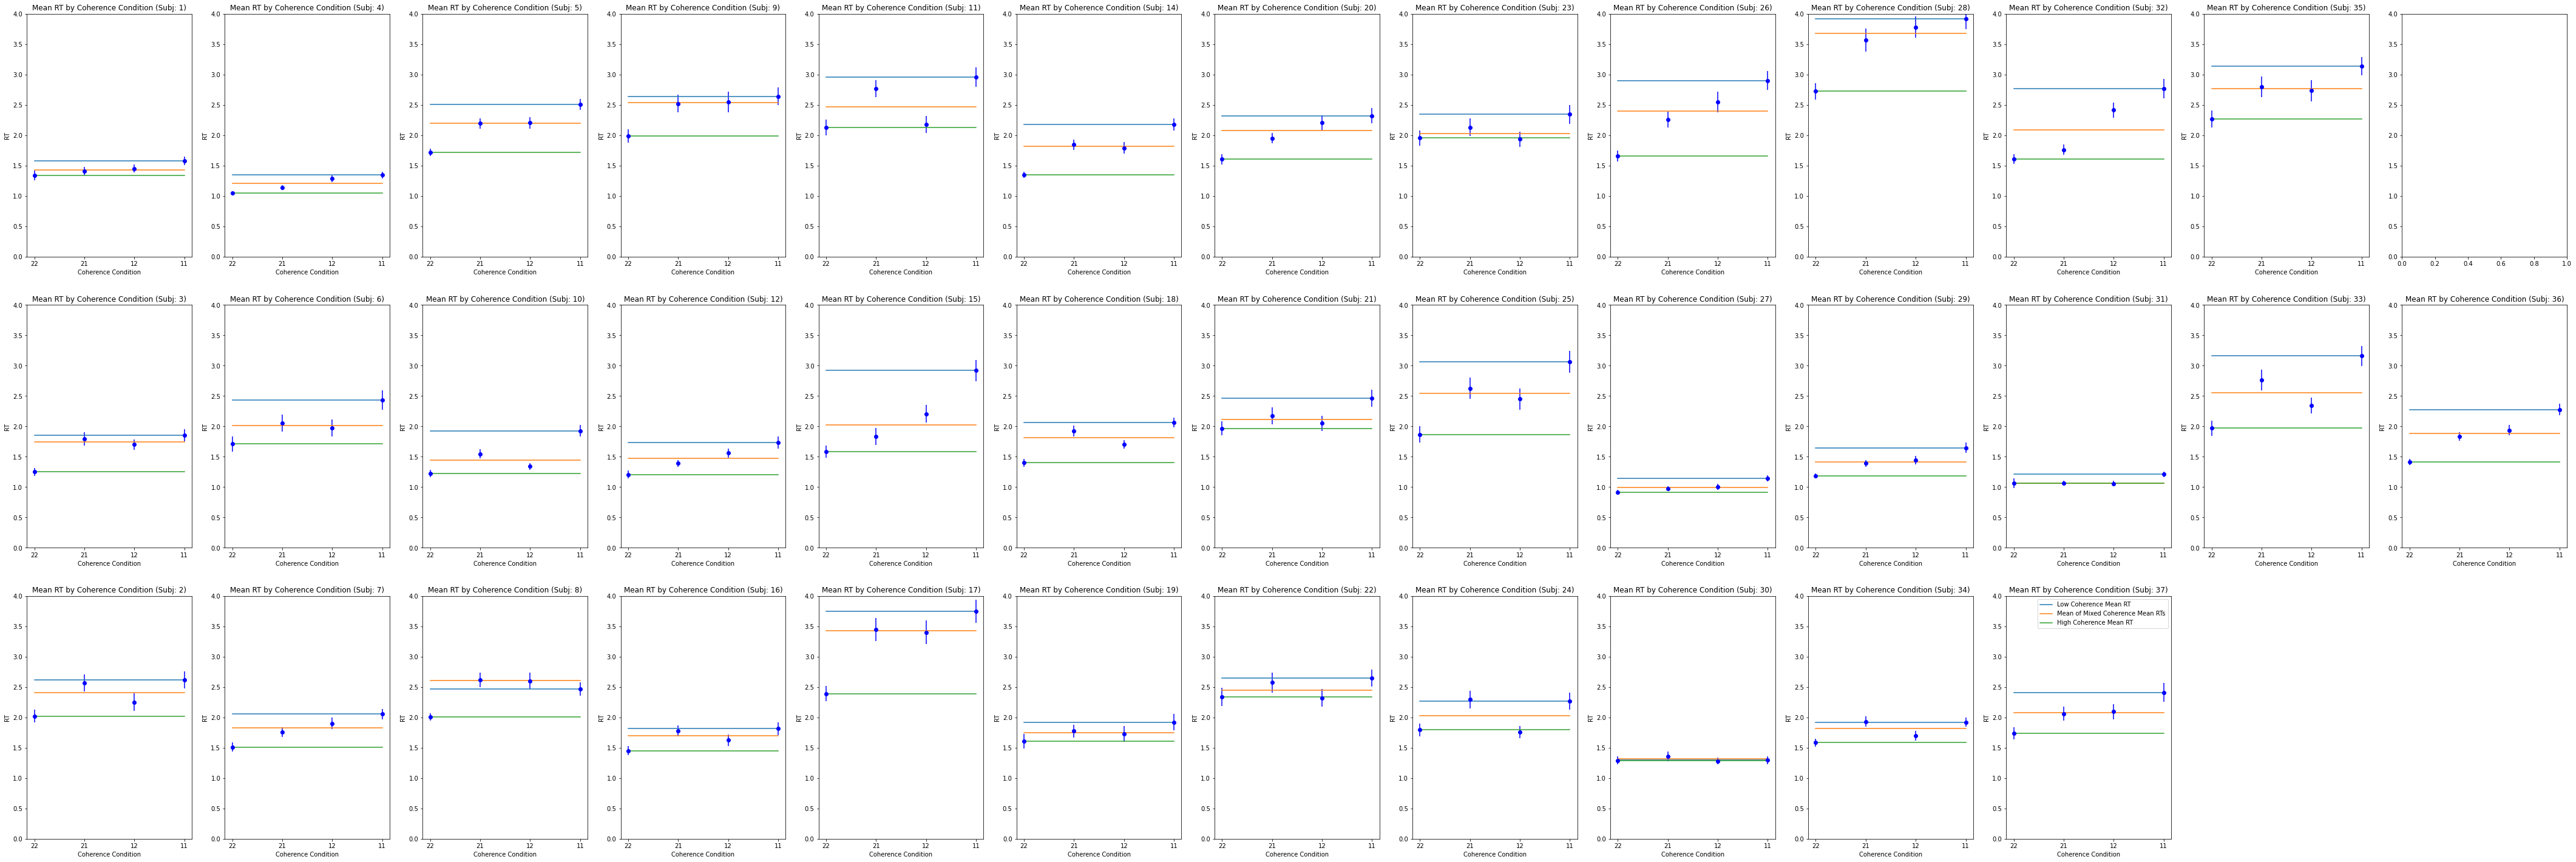

In [ ]:
# Plotting each subject
chong_median_rt = []
coh_conds = ['22','21','12','11']
#top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
#bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
#middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
#plt.ylim((0,4))
chong_group_median_rt = []
plt.figure(figsize=(75,25))
for j,i in enumerate(np.unique(chong_data.subj_idx)):
  if i+1 in cond_subj_id[0]:
    loc = np.where(cond_subj_id[0]==i+1)[0][0] + 1
  if i+1 in cond_subj_id[2]:
    loc = np.where(cond_subj_id[2]==i+1)[0][0] + 14
  if i+1 in cond_subj_id[4]:
    loc = np.where(cond_subj_id[4]==i+1)[0][0] + 27
  plt.subplot(3,13,j+1,ylim=(0,4))
  chong_median_rt = []
  chong_sterr_rt = []
  for i in coh_conds:
    chong_median_rt.append(np.mean(chong_group_data[j].rt[chong_group_data[j].cond2==i]))
    chong_sterr_rt.append(np.std(chong_group_data[j].rt[chong_group_data[j].cond2==i])/np.sqrt(len(chong_group_data[j].rt[chong_group_data[j].cond2==i])))
  top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
  bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
  mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
  middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
#chong_group_median_rt = np.array(chong_group_median_rt)
  plt.subplot(3,13,loc,ylim=(0,4))
  plt.plot(coh_conds,top_line)
  plt.plot(coh_conds,middle_line)
  plt.plot(coh_conds,bottom_line)
  #plt.plot(coh_conds,chong_median_rt,'bo')
  plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
  #plt.xticks([0,1,2,3],coh_conds)
  plt.ylabel("RT")
  plt.xlabel("Coherence Condition")
  plt.title("Mean RT by Coherence Condition (Subj: {})".format(subj_id[j]));
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

#### Super-subject RT behavior by task condition

In [ ]:
# # Plotting each subject
# chong_median_rt = []
# coh_conds = ['22','21','12','11']
# #top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
# #bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
# #middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
# for i in coh_conds:
#   chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))

# #plt.ylim((0,4))
# #chong_cond_median_rt = []
# plt.figure(figsize=(15,10))
# for j in range(6):
#   plt.subplot(2,3,j+1,ylim=(0,4))
#   chong_median_rt = []
#   chong_sterr_rt = []
#   for i in coh_conds:
#     chong_median_rt.append(np.mean(chong_cond_data[j].rt[chong_cond_data[j].cond2==i]))
#     chong_sterr_rt.append(np.std(chong_cond_data[j].rt[chong_cond_data[j].cond2==i])/np.sqrt(len(chong_cond_data[j].rt[chong_cond_data[j].cond2==i])))
#   top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
#   bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
#   mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
#   middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
# #chong_group_median_rt = np.array(chong_group_median_rt)
#   plt.plot(coh_conds,top_line)
#   plt.plot(coh_conds,middle_line)
#   plt.plot(coh_conds,bottom_line)
#   #plt.plot(coh_conds,chong_median_rt,'bo')
#   plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
#   #plt.xticks([0,1,2,3],coh_conds)
#   plt.ylabel("RT")
#   plt.xlabel("Coherence Condition")
#   plt.title("Mean RT by Coherence Condition (Cond: {})".format(conditions[j]));
# plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

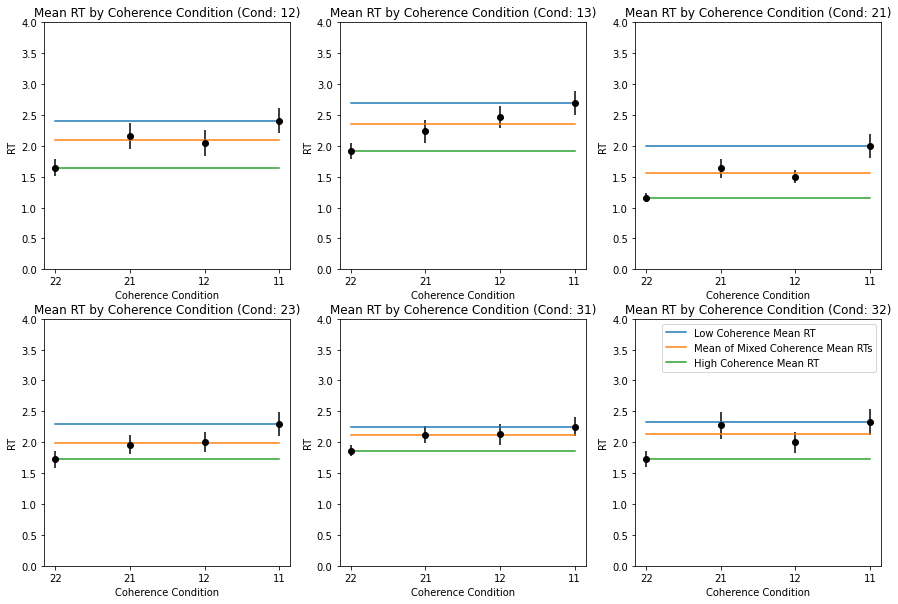

In [ ]:
# Plotting each subject
chong_median_rt = []
coh_conds = ['22','21','12','11']
#top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
#bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
#middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
chong_cond_group_median_rt = []
chong_sterr_coh_cond_rt = []
#plt.ylim((0,4))
#chong_cond_median_rt = []
plt.figure(figsize=(15,10))
for j in range(6):
  plt.subplot(2,3,j+1,ylim=(0,4))
  chong_median_rt = []
  chong_cond_subj_coh_median_rt = []
  
  chong_sterr_coh_rt = []
  for k in coh_conds:
    chong_cond_subj_median_rt = []
    
    for i in range(len(cond_subj_id[j])):
      chong_cond_subj_median_rt.append(np.mean(chong_cond_group_data[j][i].rt[chong_cond_group_data[j][i].cond2==k]))
    chong_cond_subj_coh_median_rt.append(np.mean(chong_cond_subj_median_rt))
    chong_sterr_coh_rt.append(np.std(chong_cond_subj_median_rt)/np.sqrt(len(chong_cond_subj_median_rt)))
  chong_cond_group_median_rt.append(chong_cond_subj_coh_median_rt)
  chong_sterr_coh_cond_rt.append(chong_sterr_coh_rt)
  for i in coh_conds:
    chong_median_rt.append(np.mean(chong_cond_data[j].rt[chong_cond_data[j].cond2==i]))
  top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
  bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
  mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
  middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
#chong_group_median_rt = np.array(chong_group_median_rt)
  plt.plot(coh_conds,top_line)
  plt.plot(coh_conds,middle_line)
  plt.plot(coh_conds,bottom_line)
  #plt.boxplot(chong_cond_group_median_rt[j],positions=[0,1,2,3])
  plt.errorbar(x=coh_conds,y=chong_cond_group_median_rt[j],yerr=chong_sterr_coh_cond_rt[j],fmt='ko')
  plt.xticks([0,1,2,3],coh_conds)
  plt.ylabel("RT")
  plt.xlabel("Coherence Condition")
  plt.title("Mean RT by Coherence Condition (Cond: {})".format(conditions[j]));
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

# Only Par2 Data

## Preprocessing

In [ ]:
chong_data = hddm.load_csv('downloads/chong_data/chongdata.csv')

In [ ]:
chong_data['rt'] = chong_data['rxtime']
chong_data['stim'] = chong_data.highDim.astype(str) + chong_data.lowDim.astype(str)
chong_data['subj_idx'] = chong_data['subj'] - 1
chong_data['response'] = chong_data.isHighCorrect*2 + chong_data.isLowCorrect*1
chong_data['cond'] = chong_data.highDimCoh.astype(str) + chong_data.irrDimCoh.astype(str) + chong_data.lowDimCoh.astype(str)
chong_data['cond2'] = chong_data.highDimCoh.astype(str) + chong_data.lowDimCoh.astype(str)

In [ ]:
chong_data = chong_data[chong_data.subj!=13]

In [ ]:
def model_preprocess(model):
  par2_data = hddm.load('data/tsumme/hddm_out/{}.db'.format(model))
  par2_keys = [i for i in par2_data.keys()][1:-1]
  par2_keys.sort()
  par2_keys = par2_keys[2:]+par2_keys[0:2]
  par2_data = pd.DataFrame(par2_data)
  par2_data = np.stack(par2_data[par2_keys].to_numpy()[0,:])
  par2_data = pd.DataFrame(data=par2_data.T,columns=par2_keys)
  static = ['zh','zl1','zl2']
  par2_data[static] = 0.5
  par2_keys = par2_keys[0:-1] + static + [par2_keys[-1]]
  par2_data = par2_data[par2_keys]
  par2_out = {}
  np.random.seed(2)
  thetas = par2_data.sample(n=10000,replace=True)
  for i in [1,2]:
    for j in [1,2]:
      for k in [1,2]:
        theta_list = ['vh({})'.format(i),'vl1({})'.format(j),'vl2({})'.format(k),'a','zh','zl1','zl2','t']
        par2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]
  par2_choice = []
  par2_rt = []
  for key in par2_out.keys():
    par2_rt.append(par2_out[key][0])
    par2_choice.append(par2_out[key][1])
  par2_choice = np.concatenate(par2_choice)
  par2_rt = np.concatenate(par2_rt)
  return par2_data, par2_choice, par2_rt, par2_out

In [ ]:
nmcmc = 10 #5000
burn = 1#20 #500
model = 'ddm_mic2_no_bias'
n_samples_by_subject = 512
n_subjects = 36
is_group_model = True

depends_on = {'vh': ['highDimCoh','highDim'],'vl1': ['irrDimCoh','irrDim'],'vl2': ['lowDimCoh','lowDim']}
hddmnn_model_chong = hddm.HDDMnn(chong_data,
                         model = model,
                         informative = False,
                         include = ['vh','vl1','vl2','a','t'],
                         is_group_model = is_group_model,
                         depends_on = depends_on,
                         p_outlier = 0.05)

Setting priors uninformative (LANs only work with uninformative priors for now)


INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmpickt3mqk/assets


INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmpickt3mqk/assets


printing self.nn
True
passed through flip errors nn


2021-09-08 02:01:49.451804: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-09-08 02:01:49.451858: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-09-08 02:01:49.451956: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-08 02:01:49.451969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-09-08 02:01:49.452434: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: funct

In [ ]:
hddmnn_model_chong.sample(nmcmc, burn = burn)

 [------------------110%-------------------] 11 of 10 complete in 34.3 sec

irr = irrelevant

In [ ]:
par2_no_bias = hddm.load('data/tsumme/hddm_out/ddm_par2_no_bias_chong_cond_group_True.db')
par2_keys = [i for i in par2_no_bias.keys()][1:-1]
par2_keys.sort()
par2_keys = par2_keys[2:]+par2_keys[0:2]
par2_no_bias = pd.DataFrame(par2_no_bias)
par2_no_bias = np.stack(par2_no_bias[par2_keys].to_numpy()[0,:])
par2_no_bias = pd.DataFrame(data=par2_no_bias.T,columns=par2_keys)
static = ['zh','zl1','zl2']
par2_no_bias[static] = 0.5
par2_keys = par2_keys[0:-1] + static + [par2_keys[-1]]
par2_no_bias = par2_no_bias[par2_keys]

In [ ]:
par2_data = pd.DataFrame(np.zeros((chong_data.shape[0],13)),
  columns=['highDim','highDimCoh','irrDim','irrDimCoh','lowDim','lowDimCoh','response','subj','rt','stim','subj_idx','cond','cond2'])

In [ ]:
counter = 0
#traces = par2_no_bias.get_traces()
traces = par2_no_bias
#static = ['zh','zl1','zl2']
#traces[static] = 0.5
np.random.seed(2)
for i in np.unique(chong_data.subj_idx):
  subj_chong = chong_data[chong_data.subj_idx==i]
  high_task = np.unique(subj_chong.highDim)[0]
  low_tasks = np.unique(subj_chong.lowDim)
  for highDimCoh in [1,2]:
    for low_task in low_tasks:
      subj_task_chong = subj_chong[subj_chong.lowDim==low_task]
      irr_task = low_tasks[low_tasks!=low_task][0]
      for lowDimCoh in [1,2]:
        for irrDimCoh in [1,2]:
          n = len(subj_task_chong[subj_task_chong.cond=='{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)])
          thetas = traces.sample(n=n,replace=True)
          theta_list = ['vh_subj({}.{}).{}'.format(high_task,highDimCoh,i),
                        'vl1_subj({}.{}).{}'.format(irr_task,irrDimCoh,i),
                        'vl2_subj({}.{}).{}'.format(low_task,lowDimCoh,i),
                        'a_subj.{}'.format(i),
                        'zh',
                        'zl1',
                        'zl2',
                        't_subj.{}'.format(i)]
          out = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]
          par2_data['highDim'][counter:counter+n] = high_task
          par2_data['highDimCoh'][counter:counter+n] = highDimCoh
          par2_data['irrDim'][counter:counter+n] = irr_task
          par2_data['irrDimCoh'][counter:counter+n] = irrDimCoh
          par2_data['lowDim'][counter:counter+n] = low_task
          par2_data['lowDimCoh'][counter:counter+n] = lowDimCoh
          par2_data['response'][counter:counter+n] = out[1][:,0]
          par2_data['subj'][counter:counter+n] = i+1
          par2_data['rt'][counter:counter+n] = out[0][:,0]
          par2_data['stim'][counter:counter+n] = '{}{}'.format(high_task,low_task)
          par2_data['subj_idx'][counter:counter+n] = i
          par2_data['cond'][counter:counter+n] = '{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)
          par2_data['cond2'][counter:counter+n] = '{}{}'.format(highDimCoh,lowDimCoh)
          counter += n

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_82178/1996921410.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par2_data['subj_idx'][counter:counter+n] = i
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_82178/1996921410.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par2_data['cond'][counter:counter+n] = '{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_82178/1996921410.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [ ]:
chong_data = par2_data

## Data Analysis

### Error rates

#### Super-subject error rates

In [ ]:
# Defining RT bins and calculating the proportion of errors in each bin
bins = np.array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5 ])
bins = quantile_list(chong_data['rt'],8)
chong_high_err = []
chong_low_err = []
for i in bins:
  err_high = np.sum((chong_data[chong_data.response<2]['rt'][chong_data[chong_data.response<2]['rt']<(i+0.5)])>=i)
  total = np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((chong_data[(chong_data.response==0) | (chong_data.response==2)]['rt'][chong_data[(chong_data.response==0) | (chong_data.response==2)]['rt']<(i+0.5)])>=i)
  chong_high_err.append(err_high/total)
  chong_low_err.append(err_low/total)

In [ ]:
# Defining RT bins and calculating the proportion of exclusive errors in each bin
bins = np.array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5 ])
bins = quantile_list(chong_data['rt'],8)
chong_high_err = []
chong_low_err = []
chong_high_err_bar = []
chong_low_err_bar = []
chong_totals = []
for i in bins:
  err_high = np.sum((chong_data[chong_data.response==1]['rt'][chong_data[chong_data.response==1]['rt']<(i+0.5)])>=i)
  total = np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((chong_data[(chong_data.response==2) | (chong_data.response==2)]['rt'][chong_data[(chong_data.response==2) | (chong_data.response==2)]['rt']<(i+0.5)])>=i)
  chong_high_err.append(err_high/total)
  chong_low_err.append(err_low/total)
  chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
  chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
  chong_totals.append(total)

In [ ]:
chong_high_err = np.nan_to_num(np.array(chong_high_err))
chong_low_err = np.nan_to_num(np.array(chong_low_err))
chong_high_err_bar = np.nan_to_num(chong_high_err_bar)
chong_low_err_bar = np.nan_to_num(chong_low_err_bar)
chong_totals = np.nan_to_num(chong_totals)

Separate out into exclusive error patterns

Text(0, 0.5, 'Proportion of errors')

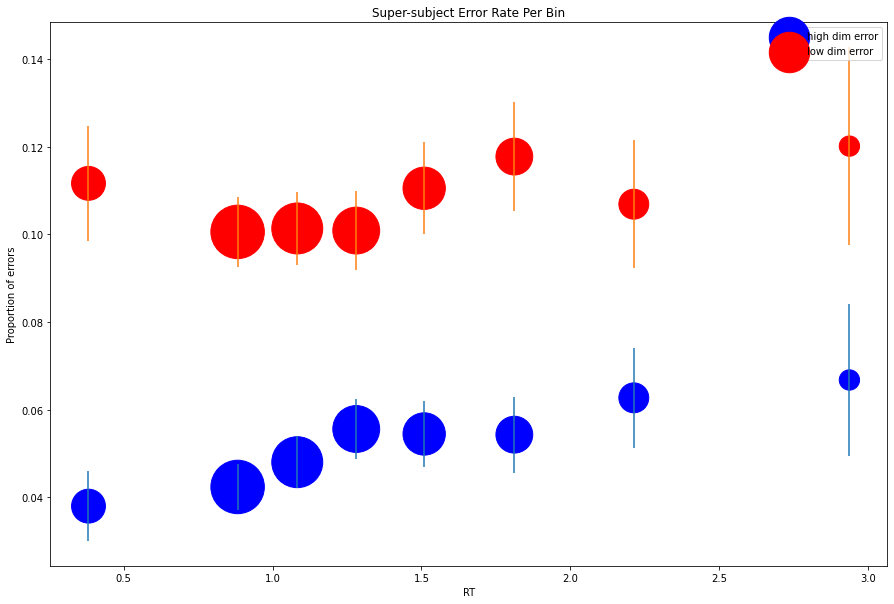

In [ ]:
plt.figure(figsize=(15,10))
plt.errorbar(x=bins,y=chong_high_err,yerr=chong_high_err_bar,ls = "None")
plt.scatter(x=bins,y=chong_high_err,s=chong_totals/2,color='b')
plt.errorbar(x=bins,y=chong_low_err,yerr=chong_low_err_bar,ls = "None")
plt.scatter(x=bins,y=chong_low_err,s=chong_totals/2,color='r')
plt.legend(['high dim error', 'low dim error'])
plt.title('Super-subject Error Rate Per Bin')
plt.xlabel("RT")
plt.ylabel('Proportion of errors')
#plt.xticks(np.arange(0, 10, step=0.5),np.arange(0, 10, step=0.5));

#### Error rates by participant

In [ ]:
chong_group_data = []
for i in np.unique(chong_data['subj']):
  chong_group_data.append(chong_data[chong_data['subj']==i])

In [ ]:
# Calculate error rate per bin for each subject
chong_group_high_err = []
chong_group_low_err = []
chong_group_high_err_bar = []
chong_group_low_err_bar = []
chong_group_totals = []
for j in range(36):
  chong_high_err = []
  chong_low_err = []
  chong_high_err_bar = []
  chong_low_err_bar = []
  chong_totals = []
  for i in bins:
    err_high = np.sum((chong_group_data[j][chong_group_data[j].response==1]['rt'][chong_group_data[j][chong_group_data[j].response==1]['rt']<(i+0.5)])>=i)
    total = np.sum((chong_group_data[j]['rt'][chong_group_data[j]['rt']<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((chong_group_data[j][(chong_group_data[j].response==2) | (chong_group_data[j].response==2)]['rt'][chong_group_data[j][(chong_group_data[j].response==2) | (chong_group_data[j].response==2)]['rt']<(i+0.5)])>=i)
    chong_high_err.append(err_high/total)
    chong_low_err.append(err_low/total)
    chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
    chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
    chong_totals.append(total)
  chong_group_totals.append(chong_totals)
  chong_group_high_err.append(chong_high_err)
  chong_group_low_err.append(chong_low_err)
  chong_group_high_err_bar.append(chong_high_err_bar)
  chong_group_low_err_bar.append(chong_low_err_bar)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/3839202324.py:18: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/3839202324.py:19: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


In [ ]:
chong_group_high_err = np.nan_to_num(np.array(chong_group_high_err))
chong_group_low_err = np.nan_to_num(np.array(chong_group_low_err))
chong_group_high_err_bar = np.nan_to_num(chong_group_high_err_bar)
chong_group_low_err_bar = np.nan_to_num(chong_group_low_err_bar)
chong_group_totals = np.nan_to_num(chong_group_totals)

Not for today

In [ ]:
# # Plotting Summary Stats
# plt.figure(figsize=(20,5))
# plt.subplot(1,2,1)
# plt.boxplot(chong_group_high_err);
# plt.title('Boxplot of Error Rate Per Subject For Each Bin (High Dim)')
# plt.xlabel("RT")
# plt.ylabel('Proportion of errors')
# plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));

# plt.subplot(1,2,2)
# plt.boxplot(chong_group_low_err);
# plt.title('Boxplot of Error Rate Per Subject For Each Bin (Low Dim)')
# plt.xlabel("RT")
# plt.ylabel('Proportion of errors')
# plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));

Specify rejection criteria (such as not showing bin if below certain total count)

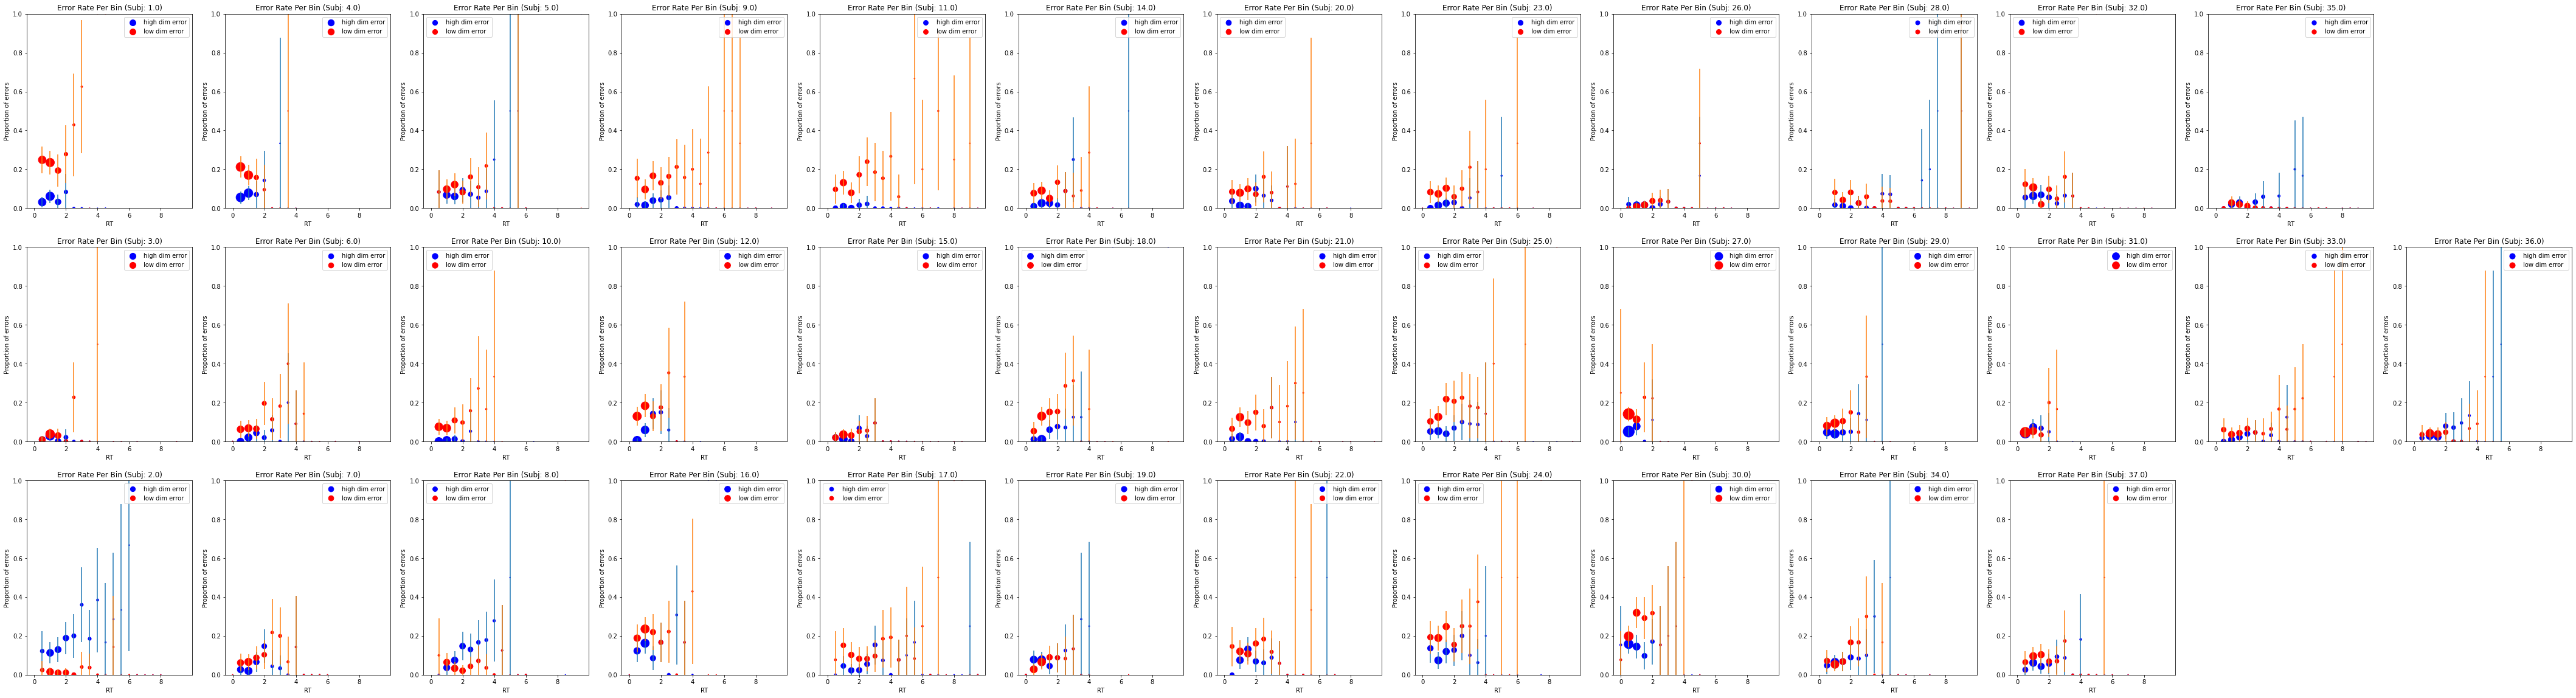

In [ ]:
#Plot each subject
subj_order = np.concatenate([cond_subj_id[0],cond_subj_id[2],cond_subj_id[4]]) #run condition cells first
#subj_loc = np.concatenate([cond_subj_id[0],cond_subj_id[2]+13,cond_subj_id[4]+26])
subj_id = np.unique(chong_data.subj)
plt.figure(figsize=(75,20))
for ind,i in enumerate(np.unique(chong_data.subj_idx)):
  if i+1 in cond_subj_id[0]:
    loc = np.where(cond_subj_id[0]==i+1)[0][0] + 1
  if i+1 in cond_subj_id[2]:
    loc = np.where(cond_subj_id[2]==i+1)[0][0] + 14
  if i+1 in cond_subj_id[4]:
    loc = np.where(cond_subj_id[4]==i+1)[0][0] + 27
  plt.subplot(3,13,loc,ylim=(0,1))
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_group_high_err[ind,:],yerr=chong_group_high_err_bar[ind,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_group_high_err[ind,:],s=chong_group_totals[ind],color='b')
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_group_low_err[ind,:],yerr=chong_group_low_err_bar[ind,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_group_low_err[ind,:],s=chong_group_totals[ind],color='r')
  plt.legend(['high dim error', 'low dim error'])
  plt.title('Error Rate Per Bin (Subj: {})'.format(i+1))
  plt.xlabel("RT")
  plt.ylabel('Proportion of errors')

#### Super-subject error rates by task dimension

In [ ]:
chong_cond_data = []
for i in np.unique(chong_data['stim']):
  chong_cond_data.append(chong_data[chong_data['stim']==i])

In [ ]:
chong_cond_group_data = []
cond_subj_id = []
for i in range(6):
  chong_cond_subj_data = []
  cond_subj_id.append(np.unique(chong_cond_data[i]['subj']))
  for j in np.unique(chong_cond_data[i]['subj']):
    chong_cond_subj_data.append(chong_cond_data[i][chong_cond_data[i]['subj']==j])
  chong_cond_group_data.append(chong_cond_subj_data)

In [ ]:
chong_cond_high_err = []
chong_cond_low_err = []
chong_cond_high_err_bar = []
chong_cond_low_err_bar = []
chong_cond_totals = []
for j in range(6):
  chong_high_err = []
  chong_low_err = []
  chong_high_err_bar = []
  chong_low_err_bar = []
  chong_totals = []
  for i in bins:
    err_high = np.sum((chong_cond_data[j][chong_cond_data[j].response<2]['rt'][chong_cond_data[j][chong_cond_data[j].response<2]['rt']<(i+0.5)])>=i)
    total = np.sum((chong_cond_data[j]['rt'][chong_cond_data[j]['rt']<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((chong_cond_data[j][(chong_cond_data[j].response==0) | (chong_cond_data[j].response==2)]['rt'][chong_cond_data[j][(chong_cond_data[j].response==0) | (chong_cond_data[j].response==2)]['rt']<(i+0.5)])>=i)
    chong_high_err.append(err_high/total)
    chong_low_err.append(err_low/total)
    chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
    chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
    chong_totals.append(total)
  chong_cond_totals.append(chong_totals)
  chong_cond_high_err.append(chong_high_err)
  chong_cond_low_err.append(chong_low_err)
  chong_cond_high_err_bar.append(chong_high_err_bar)
  chong_cond_low_err_bar.append(chong_low_err_bar)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/997457980.py:17: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/997457980.py:18: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


In [ ]:
chong_cond_high_err = np.nan_to_num(chong_cond_high_err)
chong_cond_low_err = np.nan_to_num(chong_cond_low_err)
chong_cond_high_err_bar = np.nan_to_num(chong_cond_high_err_bar)
chong_cond_low_err_bar = np.nan_to_num(chong_cond_low_err_bar)
chong_cond_totals = np.nan_to_num(chong_cond_totals)

1 is lineDir

2 is colorPer

3 is anglePer/angleOption



Also split by coherence level

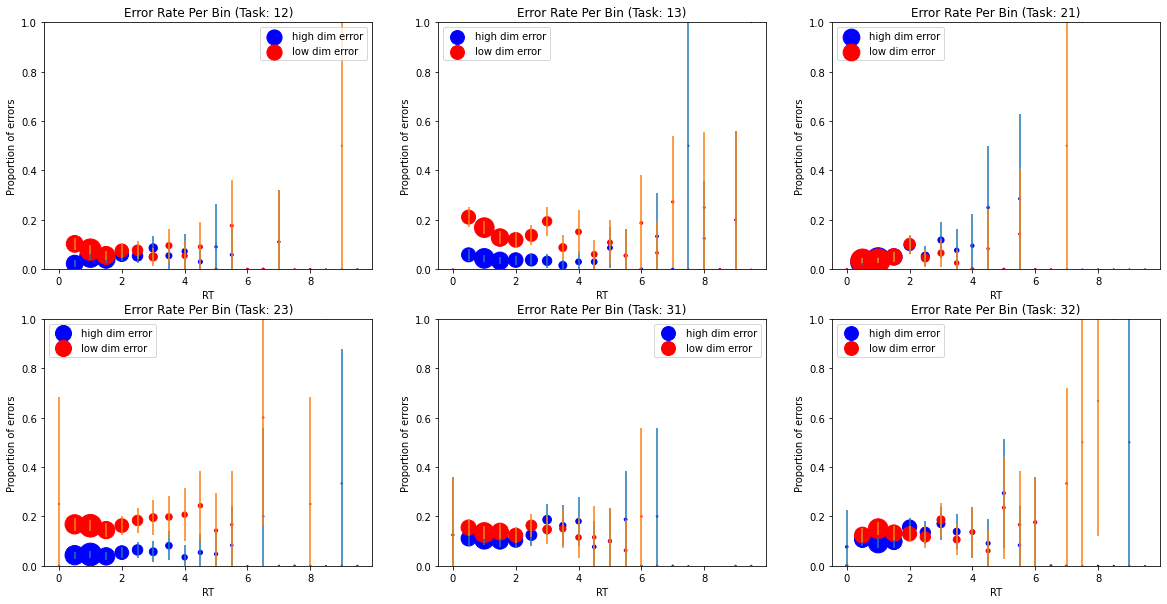

In [ ]:
#Plot each condition
conditions = np.unique(chong_data['stim'])
plt.figure(figsize=(20,10))
for i in range(6):
  plt.subplot(2,3,i+1,ylim=(0,1))
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_cond_high_err[i,:],yerr=chong_cond_high_err_bar[i,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_cond_high_err[i,:],s=chong_cond_totals[i]/2,color='b')
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_cond_low_err[i,:],yerr=chong_cond_low_err_bar[i,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_cond_low_err[i,:],s=chong_cond_totals[i]/2,color='r')
  plt.legend(['high dim error', 'low dim error'])
  plt.title('Error Rate Per Bin (Task: {})'.format(conditions[i]))
  plt.xlabel("RT")
  plt.ylabel('Proportion of errors')

In [ ]:
chong_cond_group_high_err = []
chong_cond_group_low_err = []
for j in range(6):
  chong_cond_high_err = []
  chong_cond_low_err = []
  for k in range(len(cond_subj_id[j])):
    chong_high_err = []
    chong_low_err = []
    for i in bins:
      err_high = np.sum((chong_cond_group_data[j][k][chong_cond_group_data[j][k].response==1]['rt'][chong_cond_group_data[j][k][chong_cond_group_data[j][k].response==1]['rt']<(i+0.5)])>=i)
      total = np.sum((chong_cond_group_data[j][k]['rt'][chong_cond_group_data[j][k]['rt']<(i+0.5)])>=i)
      #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
      err_low = np.sum((chong_cond_group_data[j][k][(chong_cond_group_data[j][k].response==2) | (chong_cond_group_data[j][k].response==2)]['rt'][chong_cond_group_data[j][k][(chong_cond_group_data[j][k].response==2) | (chong_cond_group_data[j][k].response==2)]['rt']<(i+0.5)])>=i)
      chong_high_err.append(err_high/total)
      chong_low_err.append(err_low/total)
    chong_cond_high_err.append(chong_high_err)
    chong_cond_low_err.append(chong_low_err)
  chong_cond_high_err = np.nan_to_num(chong_cond_high_err)
  chong_cond_low_err = np.nan_to_num(chong_cond_low_err)
  chong_cond_group_high_err.append(chong_cond_high_err)
  chong_cond_group_low_err.append(chong_cond_low_err)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1593939319.py:14: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1593939319.py:15: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


Add graphs across those groups (check for changes between groups)

In [ ]:
# conditions = np.unique(chong_data['stim'])
# plt.figure(figsize=(30,45))
# for i in range(6):
#   plt.subplot(4,3,i+1,ylim=(0,1))
#   plt.boxplot(chong_cond_group_high_err[i]);
#   plt.title('Boxplot of Error Rate Per Subject For Each Bin (High Dim)(Condition: {})'.format(conditions[i]))
#   plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));
#   #plt.hist(np.arange(0, 10, step=0.5),bins=20, histtype='step', weights=chong_group_low_err[i,:])
#   #plt.legend(['high dim error', 'low dim error'])
#   #plt.title('Error Rate Per Bin (Condition: {})'.format(conditions[i]))
#   plt.xlabel("RT")
#   plt.ylabel('Proportion of errors')

# for i in range(6):
#   plt.subplot(4,3,i+7,ylim=(0,1))
#   plt.boxplot(chong_cond_group_low_err[i]);
#   plt.title('Boxplot of Error Rate Per Subject For Each Bin (Low Dim)(Condition: {})'.format(conditions[i]))
#   plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));
#   #plt.hist(np.arange(0, 10, step=0.5),bins=20, histtype='step', weights=chong_group_low_err[i,:])
#   #plt.legend(['high dim error', 'low dim error'])
#   #plt.title('Error Rate Per Bin (Condition: {})'.format(conditions[i]))
#   plt.xlabel("RT")
#   plt.ylabel('Proportion of errors')

In [ ]:
# plt.figure(figsize=(20,10))
# for i in range(2):
#   plt.subplot(2,3,1,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i],axis=0),'o-');
#   plt.title('"1" group high dim err')
#   plt.legend(['12','13'])
#   plt.xticks(np.arange(0,20),np.arange(0,10,step=0.5))
# for i in range(2):
#   plt.subplot(2,3,2,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i+2],axis=0),'o-');
#   plt.title('"2" group high dim err')
#   plt.legend(['21','23'])
#   plt.xticks(np.arange(0,20),np.arange(0,10,step=0.5))
# for i in range(2):
#   plt.subplot(2,3,3,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i+4],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,4,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,5,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i+2],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,6,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i+4],axis=0),'o-');

### Reaction Time Behavior

#### Super-subject RT behavior

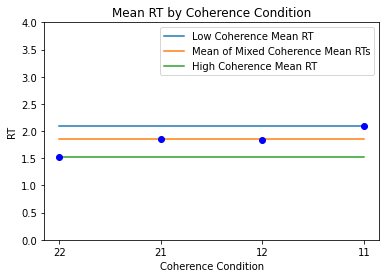

In [ ]:
# Calculate median rt for each coherence level
chong_median_rt = []
chong_sterr_rt = []
coh_conds = ['22','21','12','11']
top_line = np.mean(chong_data.rt[chong_data.cond2=='11'])
bottom_line = np.mean(chong_data.rt[chong_data.cond2=='22'])
middle_line = np.mean([np.mean(chong_data.rt[chong_data.cond2=='21']),np.mean(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
  chong_sterr_rt.append(np.std(chong_data.rt[chong_data.cond2==i])/np.sqrt(len(chong_data.rt[chong_data.cond2==i])))
plt.ylim((0,4))
plt.plot(coh_conds,[top_line,top_line,top_line,top_line])
plt.plot(coh_conds,[middle_line,middle_line,middle_line,middle_line])
plt.plot(coh_conds,[bottom_line,bottom_line,bottom_line,bottom_line])
#plt.plot(coh_conds,chong_median_rt,'bo')
plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"])
plt.ylabel("RT")
plt.xlabel("Coherence Condition")
plt.title("Mean RT by Coherence Condition");

#### Per subject RT behavior

In [ ]:
# # Plotting summary stats
# chong_median_rt = []
# coh_conds = ['22','21','12','11']
# #top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
# #bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
# #middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
# for i in coh_conds:
#   chong_median_rt.append(np.median(chong_data.rt[chong_data.cond2==i]))
# top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
# bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
# mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
# middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
# plt.ylim((0,4))
# chong_group_median_rt = []
# for j in range(36):
#   chong_median_rt = []
#   for i in coh_conds:
#     chong_median_rt.append(np.median(chong_group_data[j].rt[chong_group_data[j].cond2==i]))
#   chong_group_median_rt.append(chong_median_rt)
# chong_group_median_rt = np.array(chong_group_median_rt)
# plt.plot(coh_conds,top_line)
# plt.plot(coh_conds,middle_line)
# plt.plot(coh_conds,bottom_line)
# plt.boxplot(chong_group_median_rt,positions=[0,1,2,3])
# plt.xticks([0,1,2,3],coh_conds)
# plt.legend(["Low Coherence Median RT","Mean of Mixed Coherence Median RTs","High Coherence Median RT"])
# plt.ylabel("RT")
# plt.xlabel("Coherence Condition")
# plt.title("Boxplot of Subject Median RTs by Coherence Condition");

Add Error bars

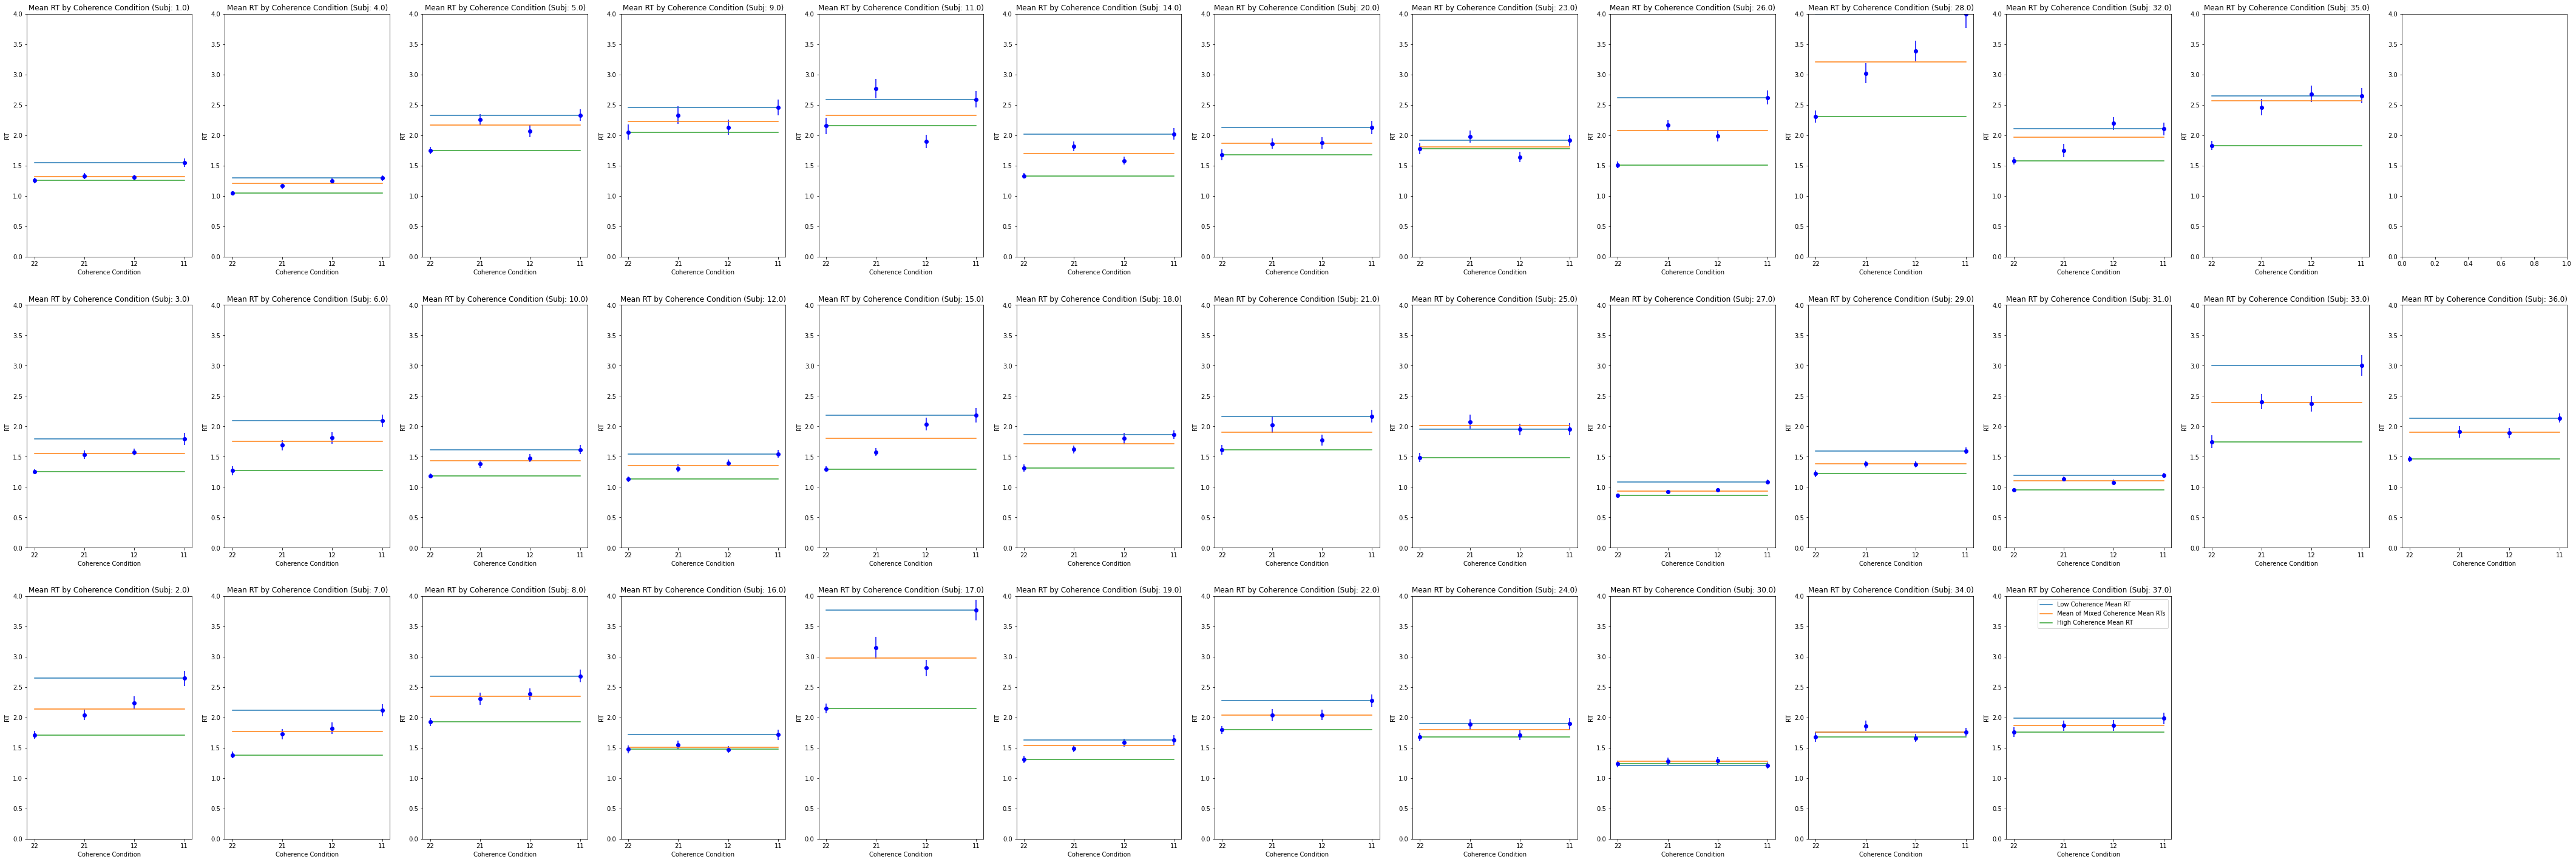

In [ ]:
# Plotting each subject
chong_median_rt = []
coh_conds = ['22','21','12','11']
#top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
#bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
#middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
#plt.ylim((0,4))
chong_group_median_rt = []
plt.figure(figsize=(75,25))
for j,i in enumerate(np.unique(chong_data.subj_idx)):
  if i+1 in cond_subj_id[0]:
    loc = np.where(cond_subj_id[0]==i+1)[0][0] + 1
  if i+1 in cond_subj_id[2]:
    loc = np.where(cond_subj_id[2]==i+1)[0][0] + 14
  if i+1 in cond_subj_id[4]:
    loc = np.where(cond_subj_id[4]==i+1)[0][0] + 27
  plt.subplot(3,13,j+1,ylim=(0,4))
  chong_median_rt = []
  chong_sterr_rt = []
  for i in coh_conds:
    chong_median_rt.append(np.mean(chong_group_data[j].rt[chong_group_data[j].cond2==i]))
    chong_sterr_rt.append(np.std(chong_group_data[j].rt[chong_group_data[j].cond2==i])/np.sqrt(len(chong_group_data[j].rt[chong_group_data[j].cond2==i])))
  top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
  bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
  mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
  middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
#chong_group_median_rt = np.array(chong_group_median_rt)
  plt.subplot(3,13,loc,ylim=(0,4))
  plt.plot(coh_conds,top_line)
  plt.plot(coh_conds,middle_line)
  plt.plot(coh_conds,bottom_line)
  #plt.plot(coh_conds,chong_median_rt,'bo')
  plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
  #plt.xticks([0,1,2,3],coh_conds)
  plt.ylabel("RT")
  plt.xlabel("Coherence Condition")
  plt.title("Mean RT by Coherence Condition (Subj: {})".format(subj_id[j]));
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

#### Super-subject RT behavior by task condition

In [ ]:
# # Plotting each subject
# chong_median_rt = []
# coh_conds = ['22','21','12','11']
# #top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
# #bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
# #middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
# for i in coh_conds:
#   chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))

# #plt.ylim((0,4))
# #chong_cond_median_rt = []
# plt.figure(figsize=(15,10))
# for j in range(6):
#   plt.subplot(2,3,j+1,ylim=(0,4))
#   chong_median_rt = []
#   chong_sterr_rt = []
#   for i in coh_conds:
#     chong_median_rt.append(np.mean(chong_cond_data[j].rt[chong_cond_data[j].cond2==i]))
#     chong_sterr_rt.append(np.std(chong_cond_data[j].rt[chong_cond_data[j].cond2==i])/np.sqrt(len(chong_cond_data[j].rt[chong_cond_data[j].cond2==i])))
#   top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
#   bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
#   mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
#   middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
# #chong_group_median_rt = np.array(chong_group_median_rt)
#   plt.plot(coh_conds,top_line)
#   plt.plot(coh_conds,middle_line)
#   plt.plot(coh_conds,bottom_line)
#   #plt.plot(coh_conds,chong_median_rt,'bo')
#   plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
#   #plt.xticks([0,1,2,3],coh_conds)
#   plt.ylabel("RT")
#   plt.xlabel("Coherence Condition")
#   plt.title("Mean RT by Coherence Condition (Cond: {})".format(conditions[j]));
# plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

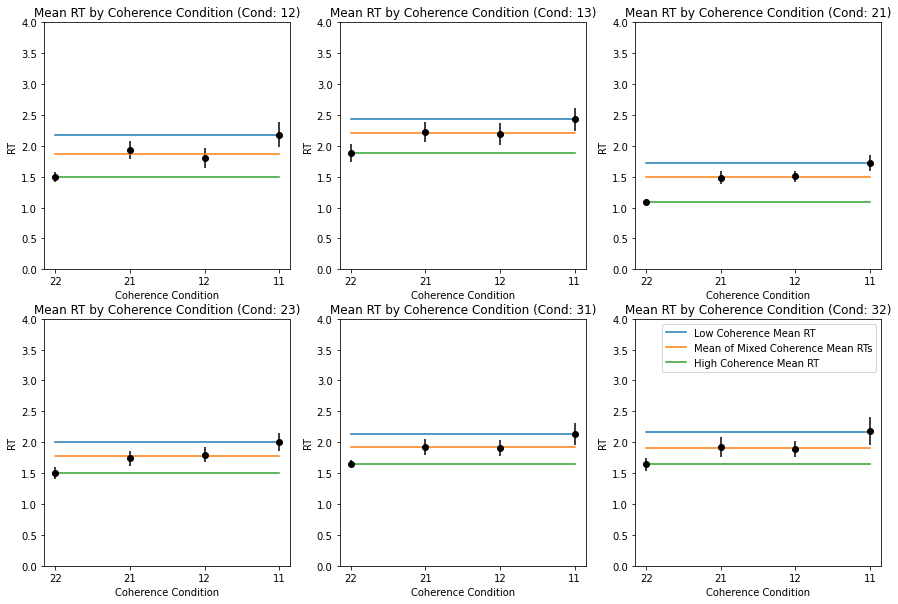

In [ ]:
# Plotting each subject
chong_median_rt = []
coh_conds = ['22','21','12','11']
#top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
#bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
#middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
chong_cond_group_median_rt = []
chong_sterr_coh_cond_rt = []
#plt.ylim((0,4))
#chong_cond_median_rt = []
plt.figure(figsize=(15,10))
for j in range(6):
  plt.subplot(2,3,j+1,ylim=(0,4))
  chong_median_rt = []
  chong_cond_subj_coh_median_rt = []
  
  chong_sterr_coh_rt = []
  for k in coh_conds:
    chong_cond_subj_median_rt = []
    
    for i in range(len(cond_subj_id[j])):
      chong_cond_subj_median_rt.append(np.mean(chong_cond_group_data[j][i].rt[chong_cond_group_data[j][i].cond2==k]))
    chong_cond_subj_coh_median_rt.append(np.mean(chong_cond_subj_median_rt))
    chong_sterr_coh_rt.append(np.std(chong_cond_subj_median_rt)/np.sqrt(len(chong_cond_subj_median_rt)))
  chong_cond_group_median_rt.append(chong_cond_subj_coh_median_rt)
  chong_sterr_coh_cond_rt.append(chong_sterr_coh_rt)
  for i in coh_conds:
    chong_median_rt.append(np.mean(chong_cond_data[j].rt[chong_cond_data[j].cond2==i]))
  top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
  bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
  mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
  middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
#chong_group_median_rt = np.array(chong_group_median_rt)
  plt.plot(coh_conds,top_line)
  plt.plot(coh_conds,middle_line)
  plt.plot(coh_conds,bottom_line)
  #plt.boxplot(chong_cond_group_median_rt[j],positions=[0,1,2,3])
  plt.errorbar(x=coh_conds,y=chong_cond_group_median_rt[j],yerr=chong_sterr_coh_cond_rt[j],fmt='ko')
  plt.xticks([0,1,2,3],coh_conds)
  plt.ylabel("RT")
  plt.xlabel("Coherence Condition")
  plt.title("Mean RT by Coherence Condition (Cond: {})".format(conditions[j]));
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

In [ ]:
#par2_no_bias = hddm.load('data/tsumme/hddm_out/ddm_par2_no_bias_chong_cond_group_True_model')
par2_no_bias.dic_info

{'DIC': 64266.021142957106,
 'deviance': 63984.745874940105,
 'pD': 281.2752680170015}

# Only Seq2 Data

## Preprocessing

In [ ]:
chong_data = hddm.load_csv('downloads/chong_data/chongdata.csv')

In [ ]:
chong_data['rt'] = chong_data['rxtime']
chong_data['stim'] = chong_data.highDim.astype(str) + chong_data.lowDim.astype(str)
chong_data['subj_idx'] = chong_data['subj'] - 1
chong_data['response'] = chong_data.isHighCorrect*2 + chong_data.isLowCorrect*1
chong_data['cond'] = chong_data.highDimCoh.astype(str) + chong_data.irrDimCoh.astype(str) + chong_data.lowDimCoh.astype(str)
chong_data['cond2'] = chong_data.highDimCoh.astype(str) + chong_data.lowDimCoh.astype(str)

In [ ]:
chong_data = chong_data[chong_data.subj!=13]

In [ ]:
def model_preprocess(model):
  par2_data = hddm.load('data/tsumme/hddm_out/{}.db'.format(model))
  par2_keys = [i for i in par2_data.keys()][1:-1]
  par2_keys.sort()
  par2_keys = par2_keys[2:]+par2_keys[0:2]
  par2_data = pd.DataFrame(par2_data)
  par2_data = np.stack(par2_data[par2_keys].to_numpy()[0,:])
  par2_data = pd.DataFrame(data=par2_data.T,columns=par2_keys)
  static = ['zh','zl1','zl2']
  par2_data[static] = 0.5
  par2_keys = par2_keys[0:-1] + static + [par2_keys[-1]]
  par2_data = par2_data[par2_keys]
  par2_out = {}
  np.random.seed(2)
  thetas = par2_data.sample(n=10000,replace=True)
  for i in [1,2]:
    for j in [1,2]:
      for k in [1,2]:
        theta_list = ['vh({})'.format(i),'vl1({})'.format(j),'vl2({})'.format(k),'a','zh','zl1','zl2','t']
        par2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]
  par2_choice = []
  par2_rt = []
  for key in par2_out.keys():
    par2_rt.append(par2_out[key][0])
    par2_choice.append(par2_out[key][1])
  par2_choice = np.concatenate(par2_choice)
  par2_rt = np.concatenate(par2_rt)
  return par2_data, par2_choice, par2_rt, par2_out

In [ ]:
nmcmc = 10 #5000
burn = 1#20 #500
model = 'ddm_mic2_no_bias'
n_samples_by_subject = 512
n_subjects = 36
is_group_model = True

depends_on = {'vh': ['highDimCoh','highDim'],'vl1': ['irrDimCoh','irrDim'],'vl2': ['lowDimCoh','lowDim']}
hddmnn_model_chong = hddm.HDDMnn(chong_data,
                         model = model,
                         informative = False,
                         include = ['vh','vl1','vl2','a','t'],
                         is_group_model = is_group_model,
                         depends_on = depends_on,
                         p_outlier = 0.05)

Setting priors uninformative (LANs only work with uninformative priors for now)


INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmpickt3mqk/assets


INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmpickt3mqk/assets


printing self.nn
True
passed through flip errors nn


2021-09-08 02:01:49.451804: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-09-08 02:01:49.451858: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-09-08 02:01:49.451956: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-08 02:01:49.451969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-09-08 02:01:49.452434: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: funct

In [ ]:
hddmnn_model_chong.sample(nmcmc, burn = burn)

 [------------------110%-------------------] 11 of 10 complete in 34.3 sec

irr = irrelevant

In [ ]:
par2_no_bias = hddm.load('data/tsumme/hddm_out/ddm_seq2_no_bias_chong_cond_group_True.db')
par2_keys = [i for i in par2_no_bias.keys()][1:-1]
par2_keys.sort()
par2_keys = par2_keys[2:]+par2_keys[0:2]
par2_no_bias = pd.DataFrame(par2_no_bias)
par2_no_bias = np.stack(par2_no_bias[par2_keys].to_numpy()[0,:])
par2_no_bias = pd.DataFrame(data=par2_no_bias.T,columns=par2_keys)
static = ['zh','zl1','zl2']
par2_no_bias[static] = 0.5
par2_keys = par2_keys[0:-1] + static + [par2_keys[-1]]
par2_no_bias = par2_no_bias[par2_keys]

In [ ]:
par2_data = pd.DataFrame(np.zeros((chong_data.shape[0],13)),
  columns=['highDim','highDimCoh','irrDim','irrDimCoh','lowDim','lowDimCoh','response','subj','rt','stim','subj_idx','cond','cond2'])

In [ ]:
counter = 0
#traces = par2_no_bias.get_traces()
traces = par2_no_bias
#static = ['zh','zl1','zl2']
#traces[static] = 0.5
np.random.seed(2)
for i in np.unique(chong_data.subj_idx):
  subj_chong = chong_data[chong_data.subj_idx==i]
  high_task = np.unique(subj_chong.highDim)[0]
  low_tasks = np.unique(subj_chong.lowDim)
  for highDimCoh in [1,2]:
    for low_task in low_tasks:
      subj_task_chong = subj_chong[subj_chong.lowDim==low_task]
      irr_task = low_tasks[low_tasks!=low_task][0]
      for lowDimCoh in [1,2]:
        for irrDimCoh in [1,2]:
          n = len(subj_task_chong[subj_task_chong.cond=='{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)])
          #thetas = traces.sample(n=n,replace=True)
          thetas = 
          theta_list = ['vh_subj({}.{}).{}'.format(high_task,highDimCoh,i),
                        'vl1_subj({}.{}).{}'.format(irr_task,irrDimCoh,i),
                        'vl2_subj({}.{}).{}'.format(low_task,lowDimCoh,i),
                        'a_subj.{}'.format(i),
                        'zh',
                        'zl1',
                        'zl2',
                        't_subj.{}'.format(i)]
          out = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]
          par2_data['highDim'][counter:counter+n] = high_task
          par2_data['highDimCoh'][counter:counter+n] = highDimCoh
          par2_data['irrDim'][counter:counter+n] = irr_task
          par2_data['irrDimCoh'][counter:counter+n] = irrDimCoh
          par2_data['lowDim'][counter:counter+n] = low_task
          par2_data['lowDimCoh'][counter:counter+n] = lowDimCoh
          par2_data['response'][counter:counter+n] = out[1][:,0]
          par2_data['subj'][counter:counter+n] = i+1
          par2_data['rt'][counter:counter+n] = out[0][:,0]
          par2_data['stim'][counter:counter+n] = '{}{}'.format(high_task,low_task)
          par2_data['subj_idx'][counter:counter+n] = i
          par2_data['cond'][counter:counter+n] = '{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)
          par2_data['cond2'][counter:counter+n] = '{}{}'.format(highDimCoh,lowDimCoh)
          counter += n

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1996921410.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par2_data['subj_idx'][counter:counter+n] = i
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1996921410.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par2_data['cond'][counter:counter+n] = '{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1996921410.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [ ]:
chong_data = par2_data

## Data Analysis

### Error rates

#### Super-subject error rates

In [ ]:
# Defining RT bins and calculating the proportion of errors in each bin
bins = np.array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5 ])
chong_high_err = []
chong_low_err = []
for i in bins:
  err_high = np.sum((chong_data[chong_data.response<2]['rt'][chong_data[chong_data.response<2]['rt']<(i+0.5)])>=i)
  total = np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((chong_data[(chong_data.response==0) | (chong_data.response==2)]['rt'][chong_data[(chong_data.response==0) | (chong_data.response==2)]['rt']<(i+0.5)])>=i)
  chong_high_err.append(err_high/total)
  chong_low_err.append(err_low/total)

In [ ]:
# Defining RT bins and calculating the proportion of exclusive errors in each bin
bins = np.array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5 ])
chong_high_err = []
chong_low_err = []
chong_high_err_bar = []
chong_low_err_bar = []
chong_totals = []
for i in bins:
  err_high = np.sum((chong_data[chong_data.response==1]['rt'][chong_data[chong_data.response==1]['rt']<(i+0.5)])>=i)
  total = np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((chong_data[(chong_data.response==2) | (chong_data.response==2)]['rt'][chong_data[(chong_data.response==2) | (chong_data.response==2)]['rt']<(i+0.5)])>=i)
  chong_high_err.append(err_high/total)
  chong_low_err.append(err_low/total)
  chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
  chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
  chong_totals.append(total)

In [ ]:
chong_high_err = np.nan_to_num(np.array(chong_high_err))
chong_low_err = np.nan_to_num(np.array(chong_low_err))
chong_high_err_bar = np.nan_to_num(chong_high_err_bar)
chong_low_err_bar = np.nan_to_num(chong_low_err_bar)
chong_totals = np.nan_to_num(chong_totals)

Separate out into exclusive error patterns

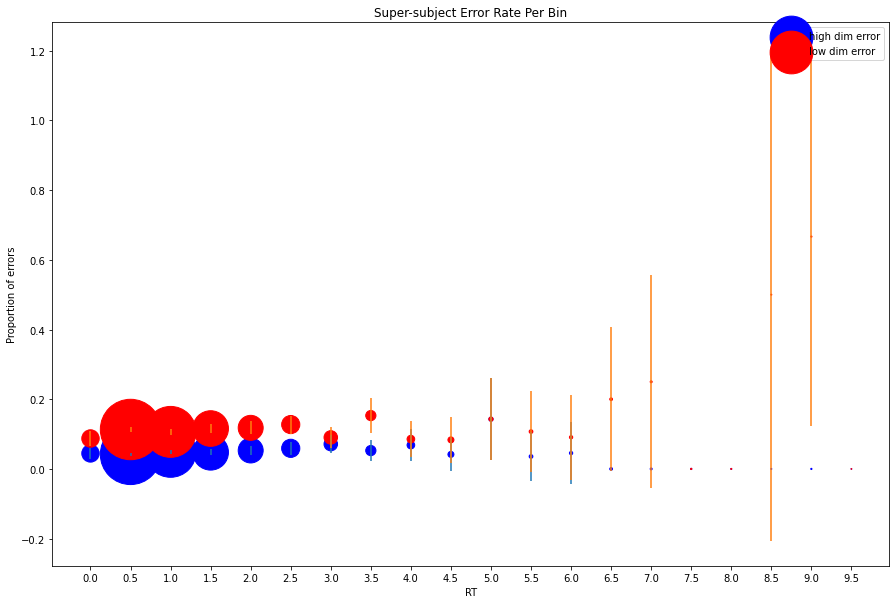

In [ ]:
plt.figure(figsize=(15,10))
plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_high_err,yerr=chong_high_err_bar,ls = "None")
plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_high_err,s=chong_totals/2,color='b')
plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_low_err,yerr=chong_low_err_bar,ls = "None")
plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_low_err,s=chong_totals/2,color='r')
plt.legend(['high dim error', 'low dim error'])
plt.title('Super-subject Error Rate Per Bin')
plt.xlabel("RT")
plt.ylabel('Proportion of errors')
plt.xticks(np.arange(0, 10, step=0.5),np.arange(0, 10, step=0.5));

#### Error rates by participant

In [ ]:
chong_group_data = []
for i in np.unique(chong_data['subj']):
  chong_group_data.append(chong_data[chong_data['subj']==i])

In [ ]:
# Calculate error rate per bin for each subject
chong_group_high_err = []
chong_group_low_err = []
chong_group_high_err_bar = []
chong_group_low_err_bar = []
chong_group_totals = []
for j in range(36):
  chong_high_err = []
  chong_low_err = []
  chong_high_err_bar = []
  chong_low_err_bar = []
  chong_totals = []
  for i in bins:
    err_high = np.sum((chong_group_data[j][chong_group_data[j].response==1]['rt'][chong_group_data[j][chong_group_data[j].response==1]['rt']<(i+0.5)])>=i)
    total = np.sum((chong_group_data[j]['rt'][chong_group_data[j]['rt']<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((chong_group_data[j][(chong_group_data[j].response==2) | (chong_group_data[j].response==2)]['rt'][chong_group_data[j][(chong_group_data[j].response==2) | (chong_group_data[j].response==2)]['rt']<(i+0.5)])>=i)
    chong_high_err.append(err_high/total)
    chong_low_err.append(err_low/total)
    chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
    chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
    chong_totals.append(total)
  chong_group_totals.append(chong_totals)
  chong_group_high_err.append(chong_high_err)
  chong_group_low_err.append(chong_low_err)
  chong_group_high_err_bar.append(chong_high_err_bar)
  chong_group_low_err_bar.append(chong_low_err_bar)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/3839202324.py:18: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/3839202324.py:19: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


In [ ]:
chong_group_high_err = np.nan_to_num(np.array(chong_group_high_err))
chong_group_low_err = np.nan_to_num(np.array(chong_group_low_err))
chong_group_high_err_bar = np.nan_to_num(chong_group_high_err_bar)
chong_group_low_err_bar = np.nan_to_num(chong_group_low_err_bar)
chong_group_totals = np.nan_to_num(chong_group_totals)

Not for today

In [ ]:
# # Plotting Summary Stats
# plt.figure(figsize=(20,5))
# plt.subplot(1,2,1)
# plt.boxplot(chong_group_high_err);
# plt.title('Boxplot of Error Rate Per Subject For Each Bin (High Dim)')
# plt.xlabel("RT")
# plt.ylabel('Proportion of errors')
# plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));

# plt.subplot(1,2,2)
# plt.boxplot(chong_group_low_err);
# plt.title('Boxplot of Error Rate Per Subject For Each Bin (Low Dim)')
# plt.xlabel("RT")
# plt.ylabel('Proportion of errors')
# plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));

Specify rejection criteria (such as not showing bin if below certain total count)

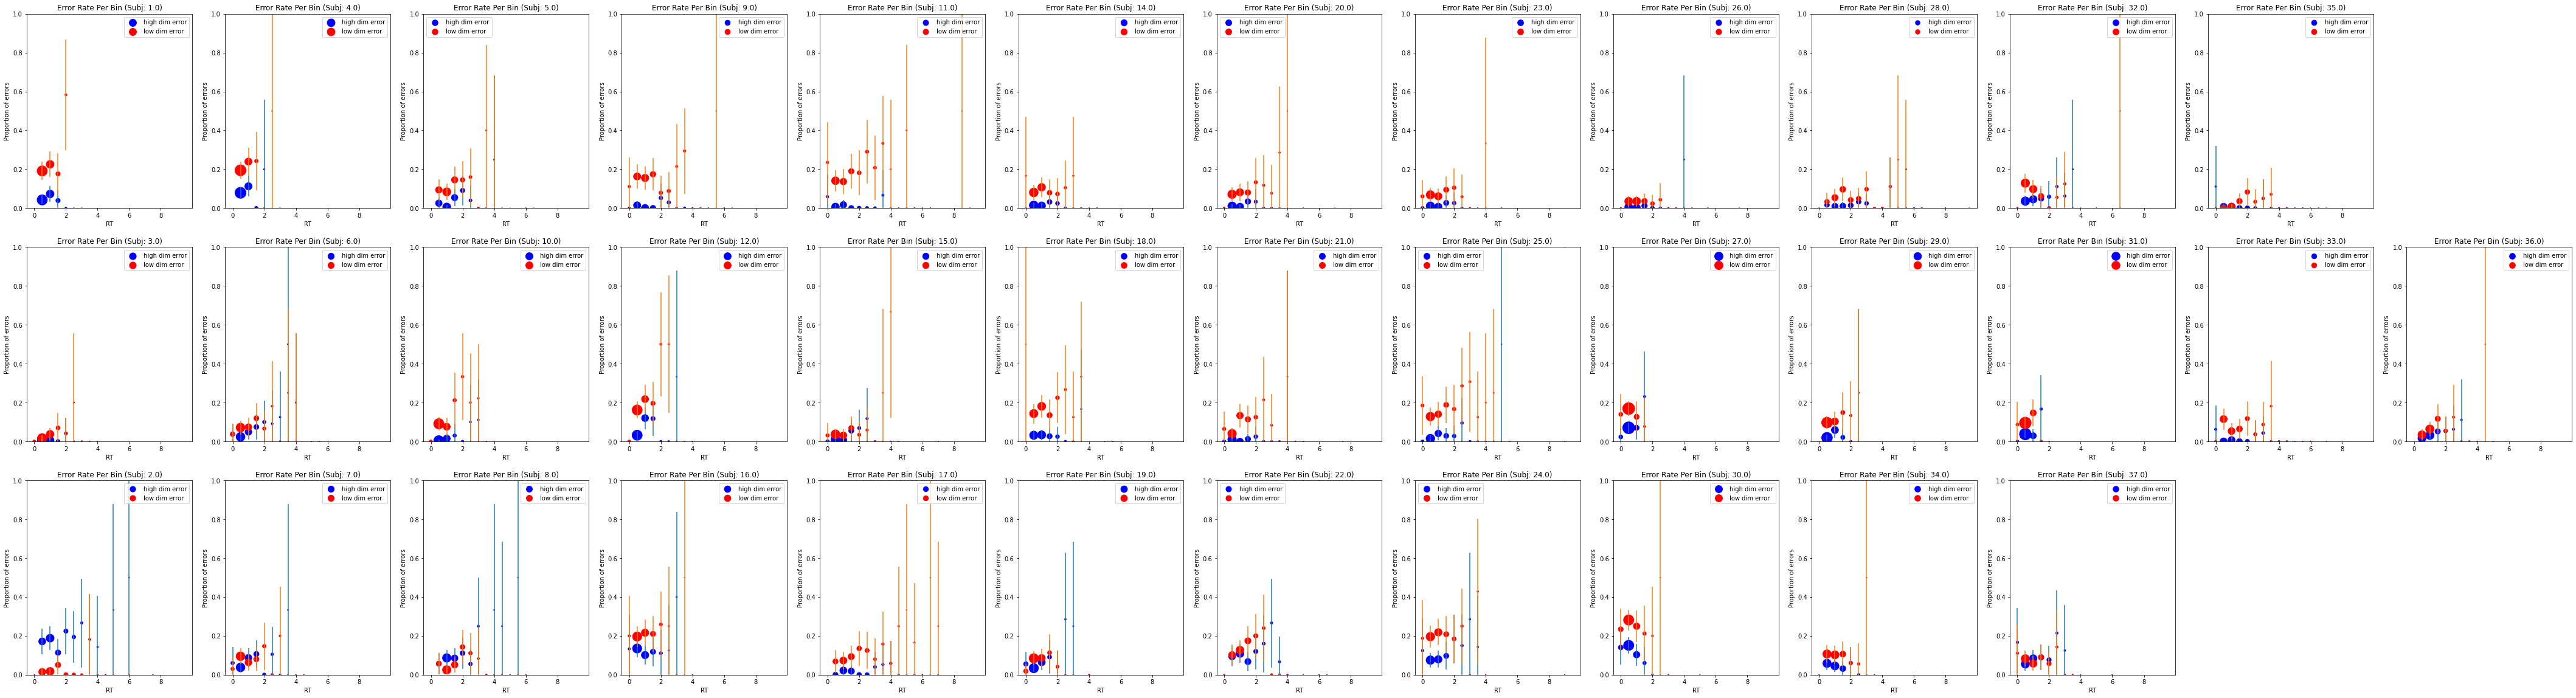

In [ ]:
#Plot each subject
subj_order = np.concatenate([cond_subj_id[0],cond_subj_id[2],cond_subj_id[4]]) #run condition cells first
#subj_loc = np.concatenate([cond_subj_id[0],cond_subj_id[2]+13,cond_subj_id[4]+26])
subj_id = np.unique(chong_data.subj)
plt.figure(figsize=(75,20))
for ind,i in enumerate(np.unique(chong_data.subj_idx)):
  if i+1 in cond_subj_id[0]:
    loc = np.where(cond_subj_id[0]==i+1)[0][0] + 1
  if i+1 in cond_subj_id[2]:
    loc = np.where(cond_subj_id[2]==i+1)[0][0] + 14
  if i+1 in cond_subj_id[4]:
    loc = np.where(cond_subj_id[4]==i+1)[0][0] + 27
  plt.subplot(3,13,loc,ylim=(0,1))
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_group_high_err[ind,:],yerr=chong_group_high_err_bar[ind,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_group_high_err[ind,:],s=chong_group_totals[ind],color='b')
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_group_low_err[ind,:],yerr=chong_group_low_err_bar[ind,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_group_low_err[ind,:],s=chong_group_totals[ind],color='r')
  plt.legend(['high dim error', 'low dim error'])
  plt.title('Error Rate Per Bin (Subj: {})'.format(i+1))
  plt.xlabel("RT")
  plt.ylabel('Proportion of errors')

#### Super-subject error rates by task dimension

In [ ]:
chong_cond_data = []
for i in np.unique(chong_data['stim']):
  chong_cond_data.append(chong_data[chong_data['stim']==i])

In [ ]:
chong_cond_group_data = []
cond_subj_id = []
for i in range(6):
  chong_cond_subj_data = []
  cond_subj_id.append(np.unique(chong_cond_data[i]['subj']))
  for j in np.unique(chong_cond_data[i]['subj']):
    chong_cond_subj_data.append(chong_cond_data[i][chong_cond_data[i]['subj']==j])
  chong_cond_group_data.append(chong_cond_subj_data)

In [ ]:
chong_cond_high_err = []
chong_cond_low_err = []
chong_cond_high_err_bar = []
chong_cond_low_err_bar = []
chong_cond_totals = []
for j in range(6):
  chong_high_err = []
  chong_low_err = []
  chong_high_err_bar = []
  chong_low_err_bar = []
  chong_totals = []
  for i in bins:
    err_high = np.sum((chong_cond_data[j][chong_cond_data[j].response<2]['rt'][chong_cond_data[j][chong_cond_data[j].response<2]['rt']<(i+0.5)])>=i)
    total = np.sum((chong_cond_data[j]['rt'][chong_cond_data[j]['rt']<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((chong_cond_data[j][(chong_cond_data[j].response==0) | (chong_cond_data[j].response==2)]['rt'][chong_cond_data[j][(chong_cond_data[j].response==0) | (chong_cond_data[j].response==2)]['rt']<(i+0.5)])>=i)
    chong_high_err.append(err_high/total)
    chong_low_err.append(err_low/total)
    chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
    chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
    chong_totals.append(total)
  chong_cond_totals.append(chong_totals)
  chong_cond_high_err.append(chong_high_err)
  chong_cond_low_err.append(chong_low_err)
  chong_cond_high_err_bar.append(chong_high_err_bar)
  chong_cond_low_err_bar.append(chong_low_err_bar)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/997457980.py:17: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/997457980.py:18: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


In [ ]:
chong_cond_high_err = np.nan_to_num(chong_cond_high_err)
chong_cond_low_err = np.nan_to_num(chong_cond_low_err)
chong_cond_high_err_bar = np.nan_to_num(chong_cond_high_err_bar)
chong_cond_low_err_bar = np.nan_to_num(chong_cond_low_err_bar)
chong_cond_totals = np.nan_to_num(chong_cond_totals)

1 is lineDir

2 is colorPer

3 is anglePer/angleOption



Also split by coherence level

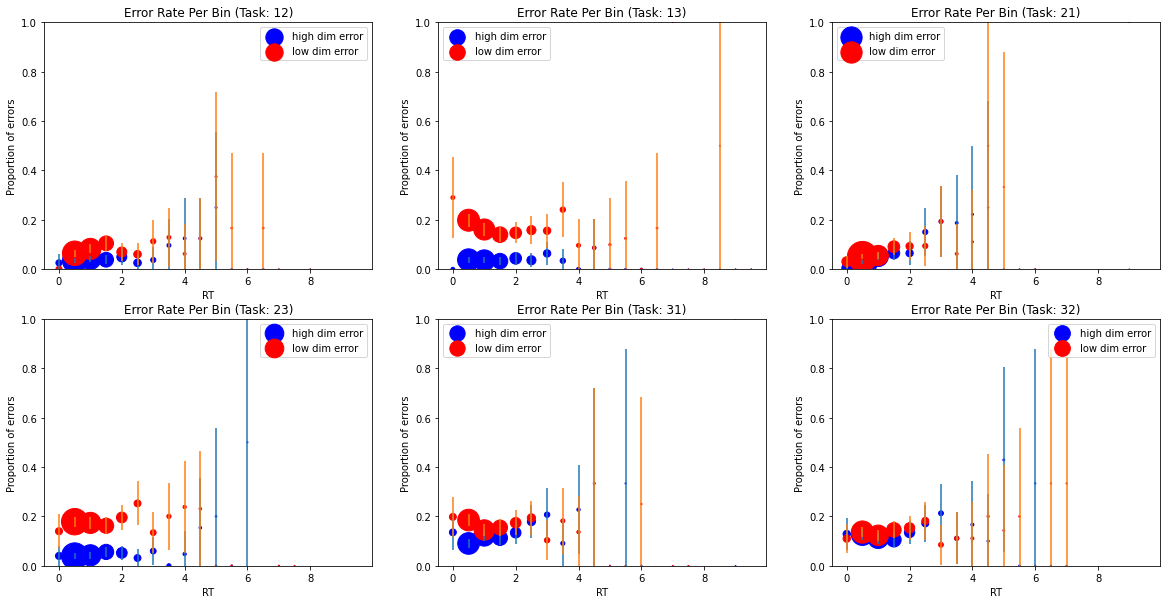

In [ ]:
#Plot each condition
conditions = np.unique(chong_data['stim'])
plt.figure(figsize=(20,10))
for i in range(6):
  plt.subplot(2,3,i+1,ylim=(0,1))
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_cond_high_err[i,:],yerr=chong_cond_high_err_bar[i,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_cond_high_err[i,:],s=chong_cond_totals[i]/2,color='b')
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_cond_low_err[i,:],yerr=chong_cond_low_err_bar[i,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_cond_low_err[i,:],s=chong_cond_totals[i]/2,color='r')
  plt.legend(['high dim error', 'low dim error'])
  plt.title('Error Rate Per Bin (Task: {})'.format(conditions[i]))
  plt.xlabel("RT")
  plt.ylabel('Proportion of errors')

In [ ]:
chong_cond_group_high_err = []
chong_cond_group_low_err = []
for j in range(6):
  chong_cond_high_err = []
  chong_cond_low_err = []
  for k in range(len(cond_subj_id[j])):
    chong_high_err = []
    chong_low_err = []
    for i in bins:
      err_high = np.sum((chong_cond_group_data[j][k][chong_cond_group_data[j][k].response==1]['rt'][chong_cond_group_data[j][k][chong_cond_group_data[j][k].response==1]['rt']<(i+0.5)])>=i)
      total = np.sum((chong_cond_group_data[j][k]['rt'][chong_cond_group_data[j][k]['rt']<(i+0.5)])>=i)
      #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
      err_low = np.sum((chong_cond_group_data[j][k][(chong_cond_group_data[j][k].response==2) | (chong_cond_group_data[j][k].response==2)]['rt'][chong_cond_group_data[j][k][(chong_cond_group_data[j][k].response==2) | (chong_cond_group_data[j][k].response==2)]['rt']<(i+0.5)])>=i)
      chong_high_err.append(err_high/total)
      chong_low_err.append(err_low/total)
    chong_cond_high_err.append(chong_high_err)
    chong_cond_low_err.append(chong_low_err)
  chong_cond_high_err = np.nan_to_num(chong_cond_high_err)
  chong_cond_low_err = np.nan_to_num(chong_cond_low_err)
  chong_cond_group_high_err.append(chong_cond_high_err)
  chong_cond_group_low_err.append(chong_cond_low_err)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1593939319.py:14: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1593939319.py:15: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


Add graphs across those groups (check for changes between groups)

In [ ]:
# conditions = np.unique(chong_data['stim'])
# plt.figure(figsize=(30,45))
# for i in range(6):
#   plt.subplot(4,3,i+1,ylim=(0,1))
#   plt.boxplot(chong_cond_group_high_err[i]);
#   plt.title('Boxplot of Error Rate Per Subject For Each Bin (High Dim)(Condition: {})'.format(conditions[i]))
#   plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));
#   #plt.hist(np.arange(0, 10, step=0.5),bins=20, histtype='step', weights=chong_group_low_err[i,:])
#   #plt.legend(['high dim error', 'low dim error'])
#   #plt.title('Error Rate Per Bin (Condition: {})'.format(conditions[i]))
#   plt.xlabel("RT")
#   plt.ylabel('Proportion of errors')

# for i in range(6):
#   plt.subplot(4,3,i+7,ylim=(0,1))
#   plt.boxplot(chong_cond_group_low_err[i]);
#   plt.title('Boxplot of Error Rate Per Subject For Each Bin (Low Dim)(Condition: {})'.format(conditions[i]))
#   plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));
#   #plt.hist(np.arange(0, 10, step=0.5),bins=20, histtype='step', weights=chong_group_low_err[i,:])
#   #plt.legend(['high dim error', 'low dim error'])
#   #plt.title('Error Rate Per Bin (Condition: {})'.format(conditions[i]))
#   plt.xlabel("RT")
#   plt.ylabel('Proportion of errors')

In [ ]:
# plt.figure(figsize=(20,10))
# for i in range(2):
#   plt.subplot(2,3,1,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i],axis=0),'o-');
#   plt.title('"1" group high dim err')
#   plt.legend(['12','13'])
#   plt.xticks(np.arange(0,20),np.arange(0,10,step=0.5))
# for i in range(2):
#   plt.subplot(2,3,2,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i+2],axis=0),'o-');
#   plt.title('"2" group high dim err')
#   plt.legend(['21','23'])
#   plt.xticks(np.arange(0,20),np.arange(0,10,step=0.5))
# for i in range(2):
#   plt.subplot(2,3,3,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i+4],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,4,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,5,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i+2],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,6,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i+4],axis=0),'o-');

### Reaction Time Behavior

#### Super-subject RT behavior

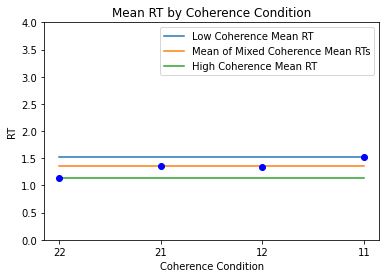

In [ ]:
# Calculate median rt for each coherence level
chong_median_rt = []
chong_sterr_rt = []
coh_conds = ['22','21','12','11']
top_line = np.mean(chong_data.rt[chong_data.cond2=='11'])
bottom_line = np.mean(chong_data.rt[chong_data.cond2=='22'])
middle_line = np.mean([np.mean(chong_data.rt[chong_data.cond2=='21']),np.mean(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
  chong_sterr_rt.append(np.std(chong_data.rt[chong_data.cond2==i])/np.sqrt(len(chong_data.rt[chong_data.cond2==i])))
plt.ylim((0,4))
plt.plot(coh_conds,[top_line,top_line,top_line,top_line])
plt.plot(coh_conds,[middle_line,middle_line,middle_line,middle_line])
plt.plot(coh_conds,[bottom_line,bottom_line,bottom_line,bottom_line])
#plt.plot(coh_conds,chong_median_rt,'bo')
plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"])
plt.ylabel("RT")
plt.xlabel("Coherence Condition")
plt.title("Mean RT by Coherence Condition");

#### Per subject RT behavior

In [ ]:
# # Plotting summary stats
# chong_median_rt = []
# coh_conds = ['22','21','12','11']
# #top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
# #bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
# #middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
# for i in coh_conds:
#   chong_median_rt.append(np.median(chong_data.rt[chong_data.cond2==i]))
# top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
# bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
# mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
# middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
# plt.ylim((0,4))
# chong_group_median_rt = []
# for j in range(36):
#   chong_median_rt = []
#   for i in coh_conds:
#     chong_median_rt.append(np.median(chong_group_data[j].rt[chong_group_data[j].cond2==i]))
#   chong_group_median_rt.append(chong_median_rt)
# chong_group_median_rt = np.array(chong_group_median_rt)
# plt.plot(coh_conds,top_line)
# plt.plot(coh_conds,middle_line)
# plt.plot(coh_conds,bottom_line)
# plt.boxplot(chong_group_median_rt,positions=[0,1,2,3])
# plt.xticks([0,1,2,3],coh_conds)
# plt.legend(["Low Coherence Median RT","Mean of Mixed Coherence Median RTs","High Coherence Median RT"])
# plt.ylabel("RT")
# plt.xlabel("Coherence Condition")
# plt.title("Boxplot of Subject Median RTs by Coherence Condition");

Add Error bars

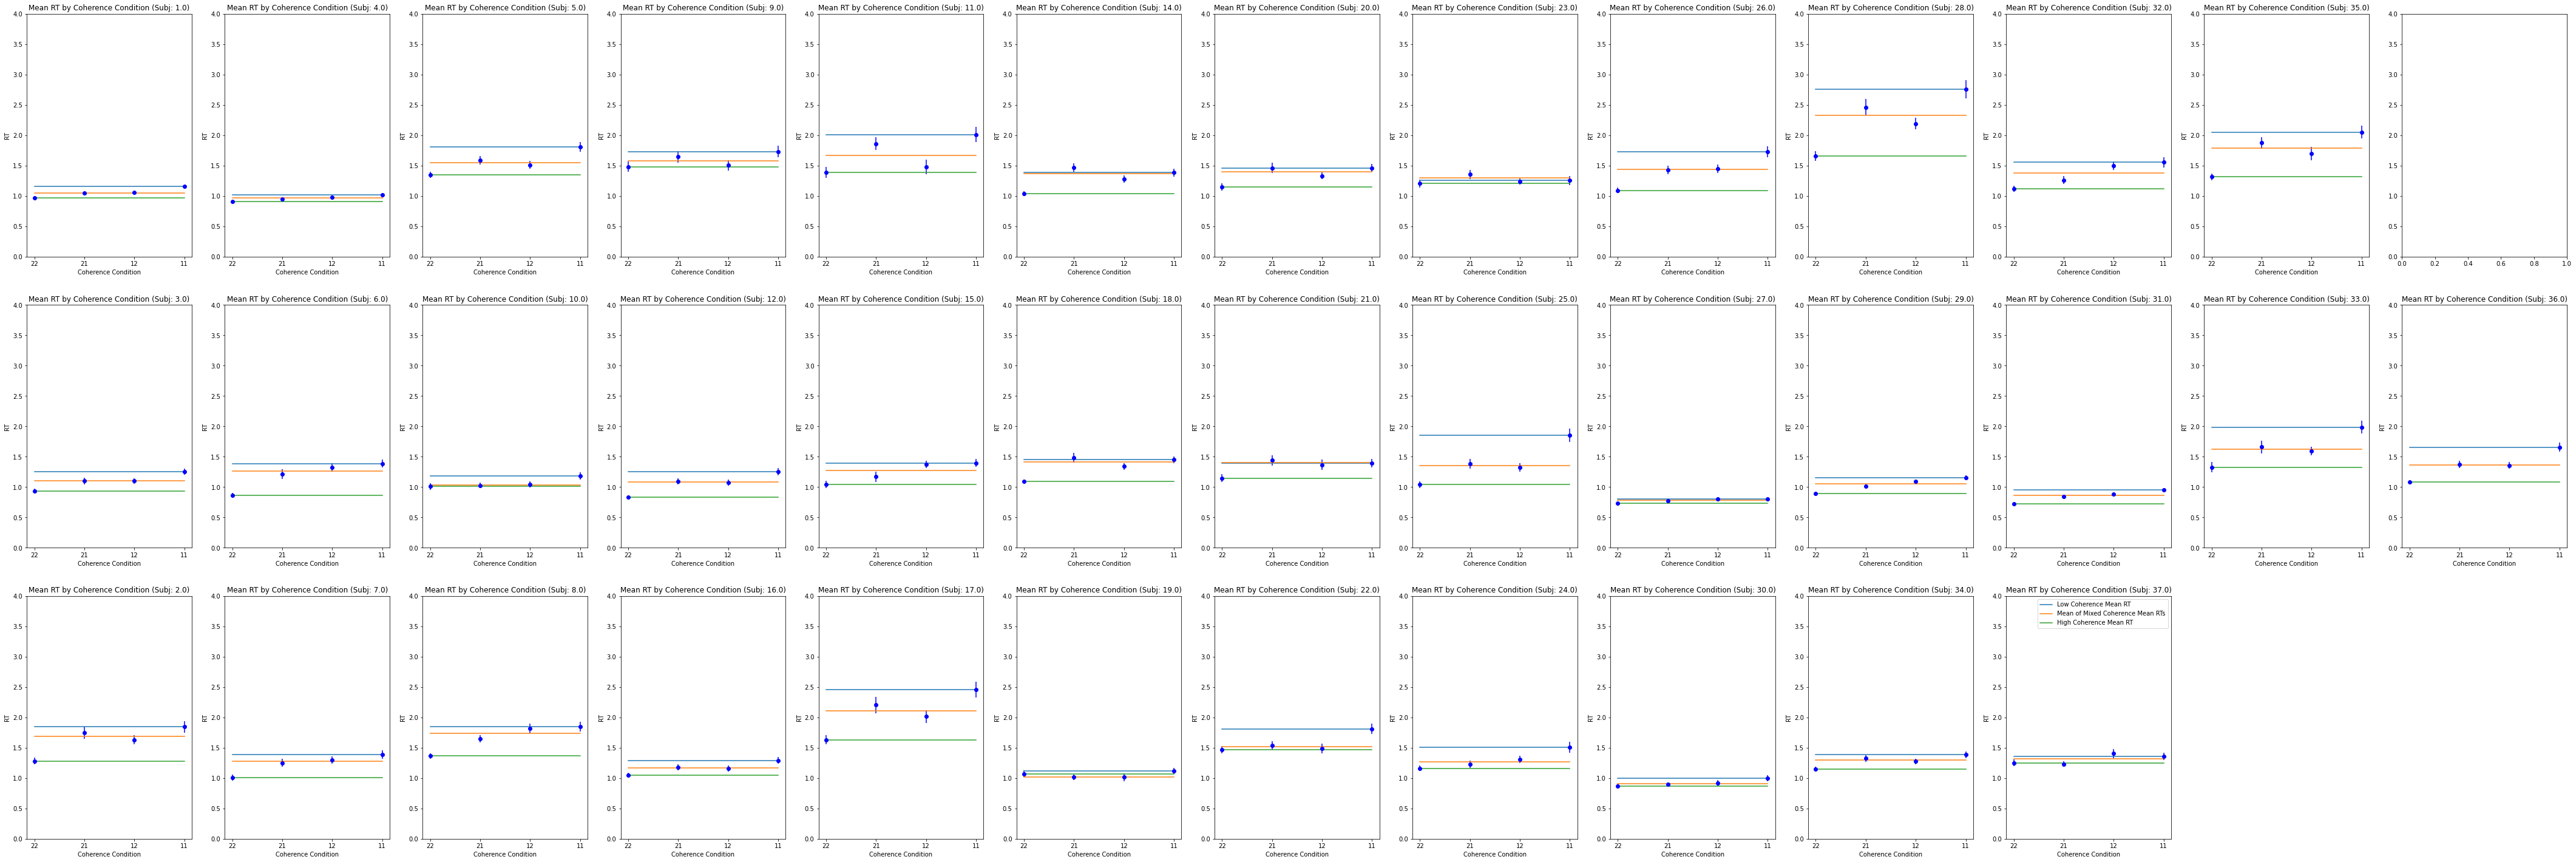

In [ ]:
# Plotting each subject
chong_median_rt = []
coh_conds = ['22','21','12','11']
#top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
#bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
#middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
#plt.ylim((0,4))
chong_group_median_rt = []
plt.figure(figsize=(75,25))
for j,i in enumerate(np.unique(chong_data.subj_idx)):
  if i+1 in cond_subj_id[0]:
    loc = np.where(cond_subj_id[0]==i+1)[0][0] + 1
  if i+1 in cond_subj_id[2]:
    loc = np.where(cond_subj_id[2]==i+1)[0][0] + 14
  if i+1 in cond_subj_id[4]:
    loc = np.where(cond_subj_id[4]==i+1)[0][0] + 27
  plt.subplot(3,13,j+1,ylim=(0,4))
  chong_median_rt = []
  chong_sterr_rt = []
  for i in coh_conds:
    chong_median_rt.append(np.mean(chong_group_data[j].rt[chong_group_data[j].cond2==i]))
    chong_sterr_rt.append(np.std(chong_group_data[j].rt[chong_group_data[j].cond2==i])/np.sqrt(len(chong_group_data[j].rt[chong_group_data[j].cond2==i])))
  top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
  bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
  mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
  middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
#chong_group_median_rt = np.array(chong_group_median_rt)
  plt.subplot(3,13,loc,ylim=(0,4))
  plt.plot(coh_conds,top_line)
  plt.plot(coh_conds,middle_line)
  plt.plot(coh_conds,bottom_line)
  #plt.plot(coh_conds,chong_median_rt,'bo')
  plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
  #plt.xticks([0,1,2,3],coh_conds)
  plt.ylabel("RT")
  plt.xlabel("Coherence Condition")
  plt.title("Mean RT by Coherence Condition (Subj: {})".format(subj_id[j]));
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

#### Super-subject RT behavior by task condition

In [ ]:
# # Plotting each subject
# chong_median_rt = []
# coh_conds = ['22','21','12','11']
# #top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
# #bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
# #middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
# for i in coh_conds:
#   chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))

# #plt.ylim((0,4))
# #chong_cond_median_rt = []
# plt.figure(figsize=(15,10))
# for j in range(6):
#   plt.subplot(2,3,j+1,ylim=(0,4))
#   chong_median_rt = []
#   chong_sterr_rt = []
#   for i in coh_conds:
#     chong_median_rt.append(np.mean(chong_cond_data[j].rt[chong_cond_data[j].cond2==i]))
#     chong_sterr_rt.append(np.std(chong_cond_data[j].rt[chong_cond_data[j].cond2==i])/np.sqrt(len(chong_cond_data[j].rt[chong_cond_data[j].cond2==i])))
#   top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
#   bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
#   mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
#   middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
# #chong_group_median_rt = np.array(chong_group_median_rt)
#   plt.plot(coh_conds,top_line)
#   plt.plot(coh_conds,middle_line)
#   plt.plot(coh_conds,bottom_line)
#   #plt.plot(coh_conds,chong_median_rt,'bo')
#   plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
#   #plt.xticks([0,1,2,3],coh_conds)
#   plt.ylabel("RT")
#   plt.xlabel("Coherence Condition")
#   plt.title("Mean RT by Coherence Condition (Cond: {})".format(conditions[j]));
# plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

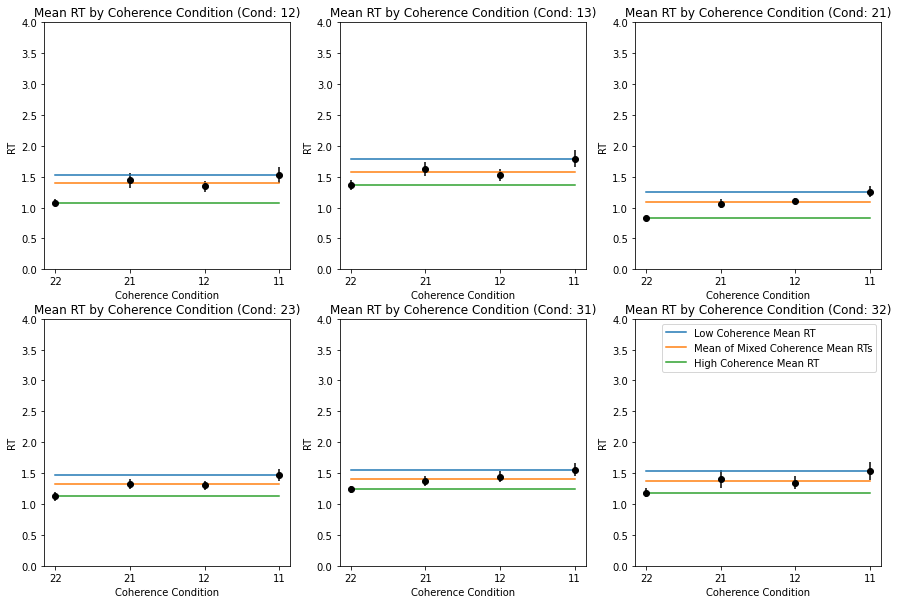

In [ ]:
# Plotting each subject
chong_median_rt = []
coh_conds = ['22','21','12','11']
#top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
#bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
#middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
chong_cond_group_median_rt = []
chong_sterr_coh_cond_rt = []
#plt.ylim((0,4))
#chong_cond_median_rt = []
plt.figure(figsize=(15,10))
for j in range(6):
  plt.subplot(2,3,j+1,ylim=(0,4))
  chong_median_rt = []
  chong_cond_subj_coh_median_rt = []
  
  chong_sterr_coh_rt = []
  for k in coh_conds:
    chong_cond_subj_median_rt = []
    
    for i in range(len(cond_subj_id[j])):
      chong_cond_subj_median_rt.append(np.mean(chong_cond_group_data[j][i].rt[chong_cond_group_data[j][i].cond2==k]))
    chong_cond_subj_coh_median_rt.append(np.mean(chong_cond_subj_median_rt))
    chong_sterr_coh_rt.append(np.std(chong_cond_subj_median_rt)/np.sqrt(len(chong_cond_subj_median_rt)))
  chong_cond_group_median_rt.append(chong_cond_subj_coh_median_rt)
  chong_sterr_coh_cond_rt.append(chong_sterr_coh_rt)
  for i in coh_conds:
    chong_median_rt.append(np.mean(chong_cond_data[j].rt[chong_cond_data[j].cond2==i]))
  top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
  bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
  mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
  middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
#chong_group_median_rt = np.array(chong_group_median_rt)
  plt.plot(coh_conds,top_line)
  plt.plot(coh_conds,middle_line)
  plt.plot(coh_conds,bottom_line)
  #plt.boxplot(chong_cond_group_median_rt[j],positions=[0,1,2,3])
  plt.errorbar(x=coh_conds,y=chong_cond_group_median_rt[j],yerr=chong_sterr_coh_cond_rt[j],fmt='ko')
  plt.xticks([0,1,2,3],coh_conds)
  plt.ylabel("RT")
  plt.xlabel("Coherence Condition")
  plt.title("Mean RT by Coherence Condition (Cond: {})".format(conditions[j]));
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

# Only Par2_angle Data

## Preprocessing

In [ ]:
chong_data = hddm.load_csv('downloads/chong_data/chongdata.csv')

In [ ]:
chong_data['rt'] = chong_data['rxtime']
chong_data['stim'] = chong_data.highDim.astype(str) + chong_data.lowDim.astype(str)
chong_data['subj_idx'] = chong_data['subj'] - 1
chong_data['response'] = chong_data.isHighCorrect*2 + chong_data.isLowCorrect*1
chong_data['cond'] = chong_data.highDimCoh.astype(str) + chong_data.irrDimCoh.astype(str) + chong_data.lowDimCoh.astype(str)
chong_data['cond2'] = chong_data.highDimCoh.astype(str) + chong_data.lowDimCoh.astype(str)

In [ ]:
chong_data = chong_data[chong_data.subj!=13]

In [ ]:
def model_preprocess(model):
  par2_data = hddm.load('data/tsumme/hddm_out/{}.db'.format(model))
  par2_keys = [i for i in par2_data.keys()][1:-1]
  par2_keys.sort()
  par2_keys = par2_keys[2:]+par2_keys[0:2]
  par2_data = pd.DataFrame(par2_data)
  par2_data = np.stack(par2_data[par2_keys].to_numpy()[0,:])
  par2_data = pd.DataFrame(data=par2_data.T,columns=par2_keys)
  static = ['zh','zl1','zl2']
  par2_data[static] = 0.5
  par2_keys = par2_keys[0:-1] + static + [par2_keys[-1]]
  par2_data = par2_data[par2_keys]
  par2_out = {}
  np.random.seed(2)
  thetas = par2_data.sample(n=10000,replace=True)
  for i in [1,2]:
    for j in [1,2]:
      for k in [1,2]:
        theta_list = ['vh({})'.format(i),'vl1({})'.format(j),'vl2({})'.format(k),'a','zh','zl1','zl2','t']
        par2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]
  par2_choice = []
  par2_rt = []
  for key in par2_out.keys():
    par2_rt.append(par2_out[key][0])
    par2_choice.append(par2_out[key][1])
  par2_choice = np.concatenate(par2_choice)
  par2_rt = np.concatenate(par2_rt)
  return par2_data, par2_choice, par2_rt, par2_out

In [ ]:
nmcmc = 10 #5000
burn = 1#20 #500
model = 'ddm_mic2_no_bias'
n_samples_by_subject = 512
n_subjects = 36
is_group_model = True

depends_on = {'vh': ['highDimCoh','highDim'],'vl1': ['irrDimCoh','irrDim'],'vl2': ['lowDimCoh','lowDim']}
hddmnn_model_chong = hddm.HDDMnn(chong_data,
                         model = model,
                         informative = False,
                         include = ['vh','vl1','vl2','a','t'],
                         is_group_model = is_group_model,
                         depends_on = depends_on,
                         p_outlier = 0.05)

Setting priors uninformative (LANs only work with uninformative priors for now)


INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmpickt3mqk/assets


INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmpickt3mqk/assets


printing self.nn
True
passed through flip errors nn


2021-09-08 02:01:49.451804: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-09-08 02:01:49.451858: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-09-08 02:01:49.451956: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-08 02:01:49.451969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-09-08 02:01:49.452434: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: funct

In [ ]:
hddmnn_model_chong.sample(nmcmc, burn = burn)

 [------------------110%-------------------] 11 of 10 complete in 34.3 sec

irr = irrelevant

In [ ]:
par2_no_bias = hddm.load('data/tsumme/hddm_out/ddm_par2_angle_no_bias_chong_cond_group_True.db')
par2_keys = [i for i in par2_no_bias.keys()][1:-1]
par2_keys.sort()
par2_keys = par2_keys[2:]+par2_keys[0:2]
par2_no_bias = pd.DataFrame(par2_no_bias)
par2_no_bias = np.stack(par2_no_bias[par2_keys].to_numpy()[0,:])
par2_no_bias = pd.DataFrame(data=par2_no_bias.T,columns=par2_keys)
static = ['zh','zl1','zl2']
par2_no_bias[static] = 0.5
par2_keys = par2_keys[0:-1] + static + [par2_keys[-1]]
par2_no_bias = par2_no_bias[par2_keys]

In [ ]:
par2_data = pd.DataFrame(np.zeros((chong_data.shape[0],13)),
  columns=['highDim','highDimCoh','irrDim','irrDimCoh','lowDim','lowDimCoh','response','subj','rt','stim','subj_idx','cond','cond2'])

In [ ]:
counter = 0
#traces = par2_no_bias.get_traces()
traces = par2_no_bias
#static = ['zh','zl1','zl2']
#traces[static] = 0.5
np.random.seed(2)
for i in np.unique(chong_data.subj_idx):
  subj_chong = chong_data[chong_data.subj_idx==i]
  high_task = np.unique(subj_chong.highDim)[0]
  low_tasks = np.unique(subj_chong.lowDim)
  for highDimCoh in [1,2]:
    for low_task in low_tasks:
      subj_task_chong = subj_chong[subj_chong.lowDim==low_task]
      irr_task = low_tasks[low_tasks!=low_task][0]
      for lowDimCoh in [1,2]:
        for irrDimCoh in [1,2]:
          n = len(subj_task_chong[subj_task_chong.cond=='{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)])
          thetas = traces.sample(n=n,replace=True)
          theta_list = ['vh_subj({}.{}).{}'.format(high_task,highDimCoh,i),
                        'vl1_subj({}.{}).{}'.format(irr_task,irrDimCoh,i),
                        'vl2_subj({}.{}).{}'.format(low_task,lowDimCoh,i),
                        'a_subj.{}'.format(i),
                        'zh',
                        'zl1',
                        'zl2',
                        't_subj.{}'.format(i)]
          out = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]
          par2_data['highDim'][counter:counter+n] = high_task
          par2_data['highDimCoh'][counter:counter+n] = highDimCoh
          par2_data['irrDim'][counter:counter+n] = irr_task
          par2_data['irrDimCoh'][counter:counter+n] = irrDimCoh
          par2_data['lowDim'][counter:counter+n] = low_task
          par2_data['lowDimCoh'][counter:counter+n] = lowDimCoh
          par2_data['response'][counter:counter+n] = out[1][:,0]
          par2_data['subj'][counter:counter+n] = i+1
          par2_data['rt'][counter:counter+n] = out[0][:,0]
          par2_data['stim'][counter:counter+n] = '{}{}'.format(high_task,low_task)
          par2_data['subj_idx'][counter:counter+n] = i
          par2_data['cond'][counter:counter+n] = '{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)
          par2_data['cond2'][counter:counter+n] = '{}{}'.format(highDimCoh,lowDimCoh)
          counter += n

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1996921410.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par2_data['subj_idx'][counter:counter+n] = i
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1996921410.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par2_data['cond'][counter:counter+n] = '{}{}{}'.format(highDimCoh,irrDimCoh,lowDimCoh)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1996921410.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [ ]:
chong_data = par2_data

## Data Analysis

### Error rates

#### Super-subject error rates

In [ ]:
# Defining RT bins and calculating the proportion of errors in each bin
bins = np.array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5 ])
chong_high_err = []
chong_low_err = []
for i in bins:
  err_high = np.sum((chong_data[chong_data.response<2]['rt'][chong_data[chong_data.response<2]['rt']<(i+0.5)])>=i)
  total = np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((chong_data[(chong_data.response==0) | (chong_data.response==2)]['rt'][chong_data[(chong_data.response==0) | (chong_data.response==2)]['rt']<(i+0.5)])>=i)
  chong_high_err.append(err_high/total)
  chong_low_err.append(err_low/total)

In [ ]:
# Defining RT bins and calculating the proportion of exclusive errors in each bin
bins = np.array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5 ])
chong_high_err = []
chong_low_err = []
chong_high_err_bar = []
chong_low_err_bar = []
chong_totals = []
for i in bins:
  err_high = np.sum((chong_data[chong_data.response==1]['rt'][chong_data[chong_data.response==1]['rt']<(i+0.5)])>=i)
  total = np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((chong_data[(chong_data.response==2) | (chong_data.response==2)]['rt'][chong_data[(chong_data.response==2) | (chong_data.response==2)]['rt']<(i+0.5)])>=i)
  chong_high_err.append(err_high/total)
  chong_low_err.append(err_low/total)
  chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
  chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
  chong_totals.append(total)

In [ ]:
chong_high_err = np.nan_to_num(np.array(chong_high_err))
chong_low_err = np.nan_to_num(np.array(chong_low_err))
chong_high_err_bar = np.nan_to_num(chong_high_err_bar)
chong_low_err_bar = np.nan_to_num(chong_low_err_bar)
chong_totals = np.nan_to_num(chong_totals)

Separate out into exclusive error patterns

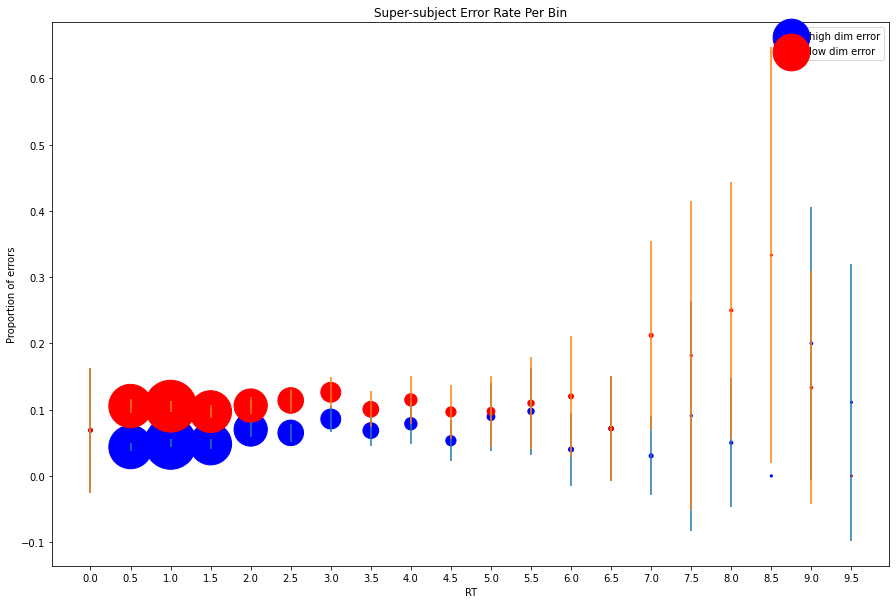

In [ ]:
plt.figure(figsize=(15,10))
plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_high_err,yerr=chong_high_err_bar,ls = "None")
plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_high_err,s=chong_totals/2,color='b')
plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_low_err,yerr=chong_low_err_bar,ls = "None")
plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_low_err,s=chong_totals/2,color='r')
plt.legend(['high dim error', 'low dim error'])
plt.title('Super-subject Error Rate Per Bin')
plt.xlabel("RT")
plt.ylabel('Proportion of errors')
plt.xticks(np.arange(0, 10, step=0.5),np.arange(0, 10, step=0.5));

#### Error rates by participant

In [ ]:
chong_group_data = []
for i in np.unique(chong_data['subj']):
  chong_group_data.append(chong_data[chong_data['subj']==i])

In [ ]:
# Calculate error rate per bin for each subject
chong_group_high_err = []
chong_group_low_err = []
chong_group_high_err_bar = []
chong_group_low_err_bar = []
chong_group_totals = []
for j in range(36):
  chong_high_err = []
  chong_low_err = []
  chong_high_err_bar = []
  chong_low_err_bar = []
  chong_totals = []
  for i in bins:
    err_high = np.sum((chong_group_data[j][chong_group_data[j].response==1]['rt'][chong_group_data[j][chong_group_data[j].response==1]['rt']<(i+0.5)])>=i)
    total = np.sum((chong_group_data[j]['rt'][chong_group_data[j]['rt']<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((chong_group_data[j][(chong_group_data[j].response==2) | (chong_group_data[j].response==2)]['rt'][chong_group_data[j][(chong_group_data[j].response==2) | (chong_group_data[j].response==2)]['rt']<(i+0.5)])>=i)
    chong_high_err.append(err_high/total)
    chong_low_err.append(err_low/total)
    chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
    chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
    chong_totals.append(total)
  chong_group_totals.append(chong_totals)
  chong_group_high_err.append(chong_high_err)
  chong_group_low_err.append(chong_low_err)
  chong_group_high_err_bar.append(chong_high_err_bar)
  chong_group_low_err_bar.append(chong_low_err_bar)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/3839202324.py:18: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/3839202324.py:19: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


In [ ]:
chong_group_high_err = np.nan_to_num(np.array(chong_group_high_err))
chong_group_low_err = np.nan_to_num(np.array(chong_group_low_err))
chong_group_high_err_bar = np.nan_to_num(chong_group_high_err_bar)
chong_group_low_err_bar = np.nan_to_num(chong_group_low_err_bar)
chong_group_totals = np.nan_to_num(chong_group_totals)

Not for today

In [ ]:
# # Plotting Summary Stats
# plt.figure(figsize=(20,5))
# plt.subplot(1,2,1)
# plt.boxplot(chong_group_high_err);
# plt.title('Boxplot of Error Rate Per Subject For Each Bin (High Dim)')
# plt.xlabel("RT")
# plt.ylabel('Proportion of errors')
# plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));

# plt.subplot(1,2,2)
# plt.boxplot(chong_group_low_err);
# plt.title('Boxplot of Error Rate Per Subject For Each Bin (Low Dim)')
# plt.xlabel("RT")
# plt.ylabel('Proportion of errors')
# plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));

Specify rejection criteria (such as not showing bin if below certain total count)

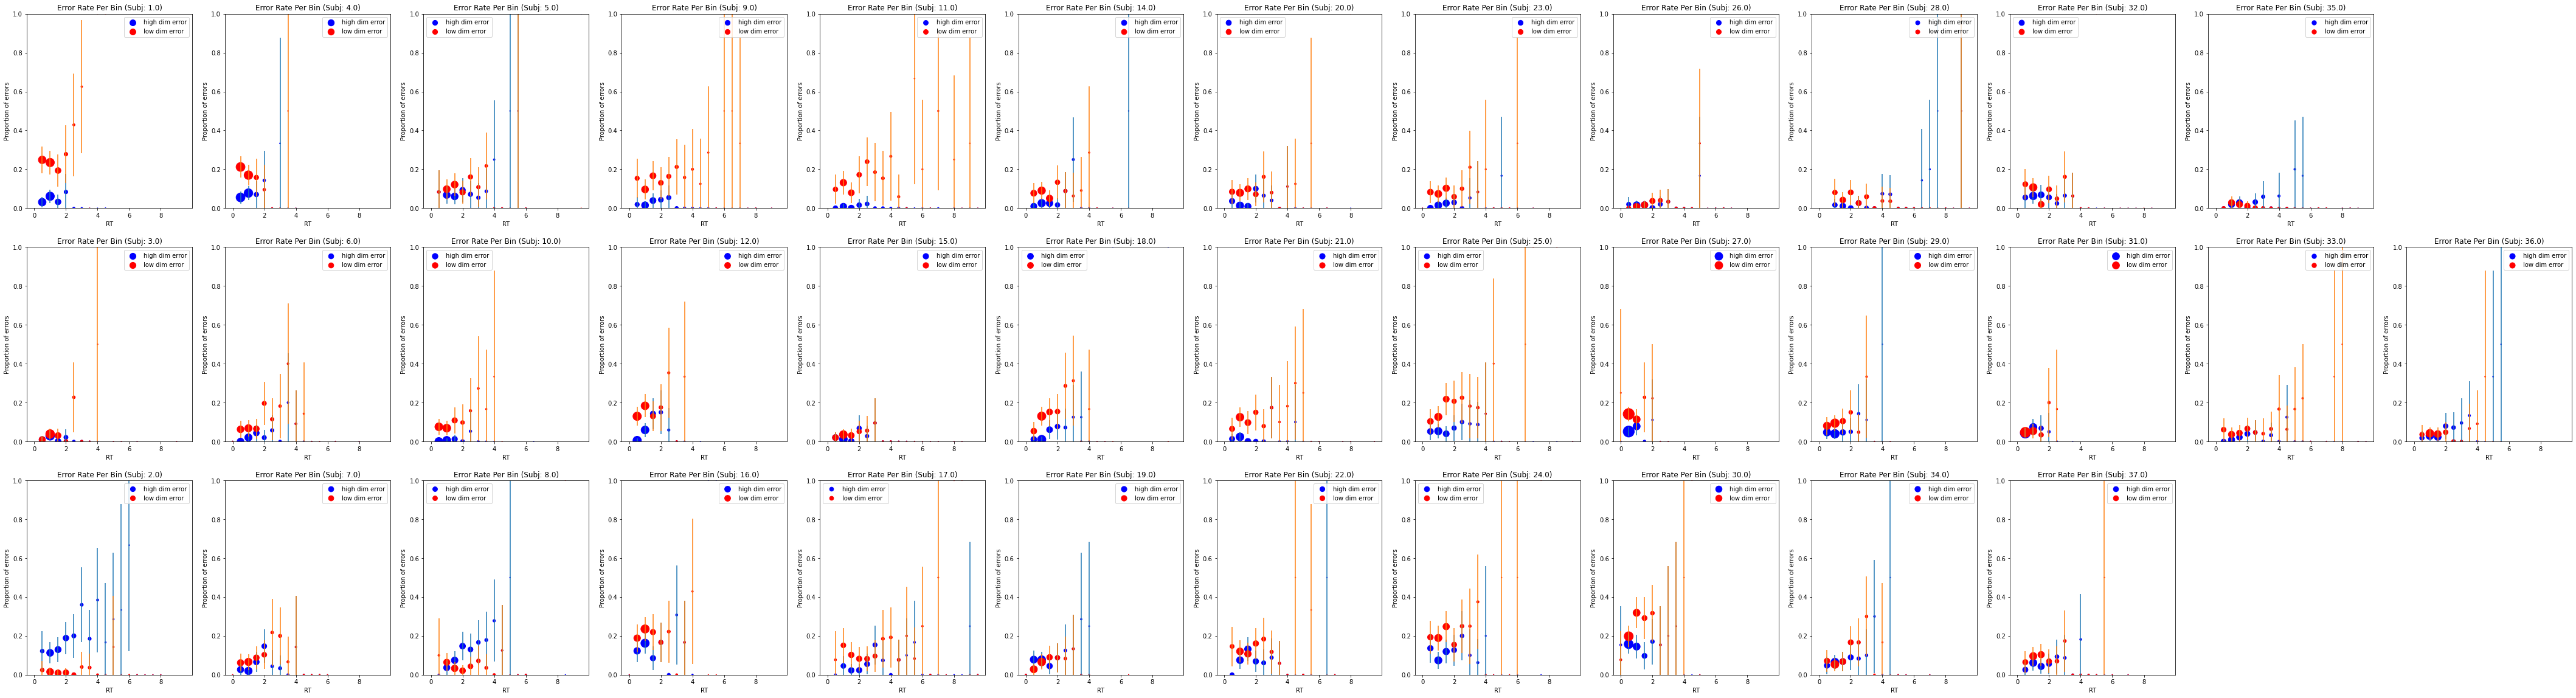

In [ ]:
#Plot each subject
subj_order = np.concatenate([cond_subj_id[0],cond_subj_id[2],cond_subj_id[4]]) #run condition cells first
#subj_loc = np.concatenate([cond_subj_id[0],cond_subj_id[2]+13,cond_subj_id[4]+26])
subj_id = np.unique(chong_data.subj)
plt.figure(figsize=(75,20))
for ind,i in enumerate(np.unique(chong_data.subj_idx)):
  if i+1 in cond_subj_id[0]:
    loc = np.where(cond_subj_id[0]==i+1)[0][0] + 1
  if i+1 in cond_subj_id[2]:
    loc = np.where(cond_subj_id[2]==i+1)[0][0] + 14
  if i+1 in cond_subj_id[4]:
    loc = np.where(cond_subj_id[4]==i+1)[0][0] + 27
  plt.subplot(3,13,loc,ylim=(0,1))
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_group_high_err[ind,:],yerr=chong_group_high_err_bar[ind,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_group_high_err[ind,:],s=chong_group_totals[ind],color='b')
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_group_low_err[ind,:],yerr=chong_group_low_err_bar[ind,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_group_low_err[ind,:],s=chong_group_totals[ind],color='r')
  plt.legend(['high dim error', 'low dim error'])
  plt.title('Error Rate Per Bin (Subj: {})'.format(i+1))
  plt.xlabel("RT")
  plt.ylabel('Proportion of errors')

#### Super-subject error rates by task dimension

In [ ]:
chong_cond_data = []
for i in np.unique(chong_data['stim']):
  chong_cond_data.append(chong_data[chong_data['stim']==i])

In [ ]:
chong_cond_group_data = []
cond_subj_id = []
for i in range(6):
  chong_cond_subj_data = []
  cond_subj_id.append(np.unique(chong_cond_data[i]['subj']))
  for j in np.unique(chong_cond_data[i]['subj']):
    chong_cond_subj_data.append(chong_cond_data[i][chong_cond_data[i]['subj']==j])
  chong_cond_group_data.append(chong_cond_subj_data)

In [ ]:
chong_cond_high_err = []
chong_cond_low_err = []
chong_cond_high_err_bar = []
chong_cond_low_err_bar = []
chong_cond_totals = []
for j in range(6):
  chong_high_err = []
  chong_low_err = []
  chong_high_err_bar = []
  chong_low_err_bar = []
  chong_totals = []
  for i in bins:
    err_high = np.sum((chong_cond_data[j][chong_cond_data[j].response<2]['rt'][chong_cond_data[j][chong_cond_data[j].response<2]['rt']<(i+0.5)])>=i)
    total = np.sum((chong_cond_data[j]['rt'][chong_cond_data[j]['rt']<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((chong_cond_data[j][(chong_cond_data[j].response==0) | (chong_cond_data[j].response==2)]['rt'][chong_cond_data[j][(chong_cond_data[j].response==0) | (chong_cond_data[j].response==2)]['rt']<(i+0.5)])>=i)
    chong_high_err.append(err_high/total)
    chong_low_err.append(err_low/total)
    chong_high_err_bar.append(2*np.sqrt(chong_high_err[-1]*(1 - chong_high_err[-1]) / total))
    chong_low_err_bar.append(2*np.sqrt(chong_low_err[-1]*(1 - chong_low_err[-1]) / total))
    chong_totals.append(total)
  chong_cond_totals.append(chong_totals)
  chong_cond_high_err.append(chong_high_err)
  chong_cond_low_err.append(chong_low_err)
  chong_cond_high_err_bar.append(chong_high_err_bar)
  chong_cond_low_err_bar.append(chong_low_err_bar)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/997457980.py:17: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/997457980.py:18: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


In [ ]:
chong_cond_high_err = np.nan_to_num(chong_cond_high_err)
chong_cond_low_err = np.nan_to_num(chong_cond_low_err)
chong_cond_high_err_bar = np.nan_to_num(chong_cond_high_err_bar)
chong_cond_low_err_bar = np.nan_to_num(chong_cond_low_err_bar)
chong_cond_totals = np.nan_to_num(chong_cond_totals)

1 is lineDir

2 is colorPer

3 is anglePer/angleOption



Also split by coherence level

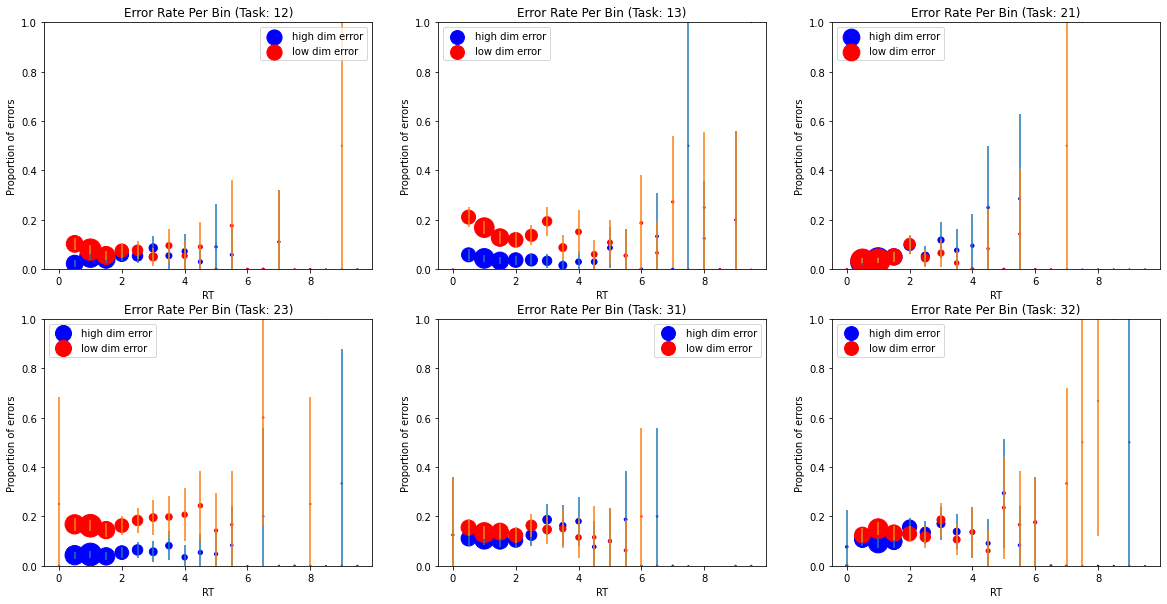

In [ ]:
#Plot each condition
conditions = np.unique(chong_data['stim'])
plt.figure(figsize=(20,10))
for i in range(6):
  plt.subplot(2,3,i+1,ylim=(0,1))
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_cond_high_err[i,:],yerr=chong_cond_high_err_bar[i,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_cond_high_err[i,:],s=chong_cond_totals[i]/2,color='b')
  plt.errorbar(x=np.arange(0, 10, step=0.5),y=chong_cond_low_err[i,:],yerr=chong_cond_low_err_bar[i,:],ls = "None")
  plt.scatter(x=np.arange(0, 10, step=0.5),y=chong_cond_low_err[i,:],s=chong_cond_totals[i]/2,color='r')
  plt.legend(['high dim error', 'low dim error'])
  plt.title('Error Rate Per Bin (Task: {})'.format(conditions[i]))
  plt.xlabel("RT")
  plt.ylabel('Proportion of errors')

In [ ]:
chong_cond_group_high_err = []
chong_cond_group_low_err = []
for j in range(6):
  chong_cond_high_err = []
  chong_cond_low_err = []
  for k in range(len(cond_subj_id[j])):
    chong_high_err = []
    chong_low_err = []
    for i in bins:
      err_high = np.sum((chong_cond_group_data[j][k][chong_cond_group_data[j][k].response==1]['rt'][chong_cond_group_data[j][k][chong_cond_group_data[j][k].response==1]['rt']<(i+0.5)])>=i)
      total = np.sum((chong_cond_group_data[j][k]['rt'][chong_cond_group_data[j][k]['rt']<(i+0.5)])>=i)
      #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
      err_low = np.sum((chong_cond_group_data[j][k][(chong_cond_group_data[j][k].response==2) | (chong_cond_group_data[j][k].response==2)]['rt'][chong_cond_group_data[j][k][(chong_cond_group_data[j][k].response==2) | (chong_cond_group_data[j][k].response==2)]['rt']<(i+0.5)])>=i)
      chong_high_err.append(err_high/total)
      chong_low_err.append(err_low/total)
    chong_cond_high_err.append(chong_high_err)
    chong_cond_low_err.append(chong_low_err)
  chong_cond_high_err = np.nan_to_num(chong_cond_high_err)
  chong_cond_low_err = np.nan_to_num(chong_cond_low_err)
  chong_cond_group_high_err.append(chong_cond_high_err)
  chong_cond_group_low_err.append(chong_cond_low_err)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1593939319.py:14: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_1106/1593939319.py:15: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


Add graphs across those groups (check for changes between groups)

In [ ]:
# conditions = np.unique(chong_data['stim'])
# plt.figure(figsize=(30,45))
# for i in range(6):
#   plt.subplot(4,3,i+1,ylim=(0,1))
#   plt.boxplot(chong_cond_group_high_err[i]);
#   plt.title('Boxplot of Error Rate Per Subject For Each Bin (High Dim)(Condition: {})'.format(conditions[i]))
#   plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));
#   #plt.hist(np.arange(0, 10, step=0.5),bins=20, histtype='step', weights=chong_group_low_err[i,:])
#   #plt.legend(['high dim error', 'low dim error'])
#   #plt.title('Error Rate Per Bin (Condition: {})'.format(conditions[i]))
#   plt.xlabel("RT")
#   plt.ylabel('Proportion of errors')

# for i in range(6):
#   plt.subplot(4,3,i+7,ylim=(0,1))
#   plt.boxplot(chong_cond_group_low_err[i]);
#   plt.title('Boxplot of Error Rate Per Subject For Each Bin (Low Dim)(Condition: {})'.format(conditions[i]))
#   plt.xticks(np.arange(0,21),np.arange(0,10.5,step=0.5));
#   #plt.hist(np.arange(0, 10, step=0.5),bins=20, histtype='step', weights=chong_group_low_err[i,:])
#   #plt.legend(['high dim error', 'low dim error'])
#   #plt.title('Error Rate Per Bin (Condition: {})'.format(conditions[i]))
#   plt.xlabel("RT")
#   plt.ylabel('Proportion of errors')

In [ ]:
# plt.figure(figsize=(20,10))
# for i in range(2):
#   plt.subplot(2,3,1,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i],axis=0),'o-');
#   plt.title('"1" group high dim err')
#   plt.legend(['12','13'])
#   plt.xticks(np.arange(0,20),np.arange(0,10,step=0.5))
# for i in range(2):
#   plt.subplot(2,3,2,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i+2],axis=0),'o-');
#   plt.title('"2" group high dim err')
#   plt.legend(['21','23'])
#   plt.xticks(np.arange(0,20),np.arange(0,10,step=0.5))
# for i in range(2):
#   plt.subplot(2,3,3,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_high_err[i+4],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,4,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,5,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i+2],axis=0),'o-');
# for i in range(2):
#   plt.subplot(2,3,6,ylim=(0,1))
#   plt.plot(np.mean(chong_cond_group_low_err[i+4],axis=0),'o-');

### Reaction Time Behavior

#### Super-subject RT behavior

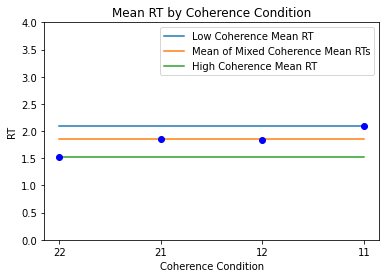

In [ ]:
# Calculate median rt for each coherence level
chong_median_rt = []
chong_sterr_rt = []
coh_conds = ['22','21','12','11']
top_line = np.mean(chong_data.rt[chong_data.cond2=='11'])
bottom_line = np.mean(chong_data.rt[chong_data.cond2=='22'])
middle_line = np.mean([np.mean(chong_data.rt[chong_data.cond2=='21']),np.mean(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
  chong_sterr_rt.append(np.std(chong_data.rt[chong_data.cond2==i])/np.sqrt(len(chong_data.rt[chong_data.cond2==i])))
plt.ylim((0,4))
plt.plot(coh_conds,[top_line,top_line,top_line,top_line])
plt.plot(coh_conds,[middle_line,middle_line,middle_line,middle_line])
plt.plot(coh_conds,[bottom_line,bottom_line,bottom_line,bottom_line])
#plt.plot(coh_conds,chong_median_rt,'bo')
plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"])
plt.ylabel("RT")
plt.xlabel("Coherence Condition")
plt.title("Mean RT by Coherence Condition");

#### Per subject RT behavior

In [ ]:
# # Plotting summary stats
# chong_median_rt = []
# coh_conds = ['22','21','12','11']
# #top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
# #bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
# #middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
# for i in coh_conds:
#   chong_median_rt.append(np.median(chong_data.rt[chong_data.cond2==i]))
# top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
# bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
# mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
# middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
# plt.ylim((0,4))
# chong_group_median_rt = []
# for j in range(36):
#   chong_median_rt = []
#   for i in coh_conds:
#     chong_median_rt.append(np.median(chong_group_data[j].rt[chong_group_data[j].cond2==i]))
#   chong_group_median_rt.append(chong_median_rt)
# chong_group_median_rt = np.array(chong_group_median_rt)
# plt.plot(coh_conds,top_line)
# plt.plot(coh_conds,middle_line)
# plt.plot(coh_conds,bottom_line)
# plt.boxplot(chong_group_median_rt,positions=[0,1,2,3])
# plt.xticks([0,1,2,3],coh_conds)
# plt.legend(["Low Coherence Median RT","Mean of Mixed Coherence Median RTs","High Coherence Median RT"])
# plt.ylabel("RT")
# plt.xlabel("Coherence Condition")
# plt.title("Boxplot of Subject Median RTs by Coherence Condition");

Add Error bars

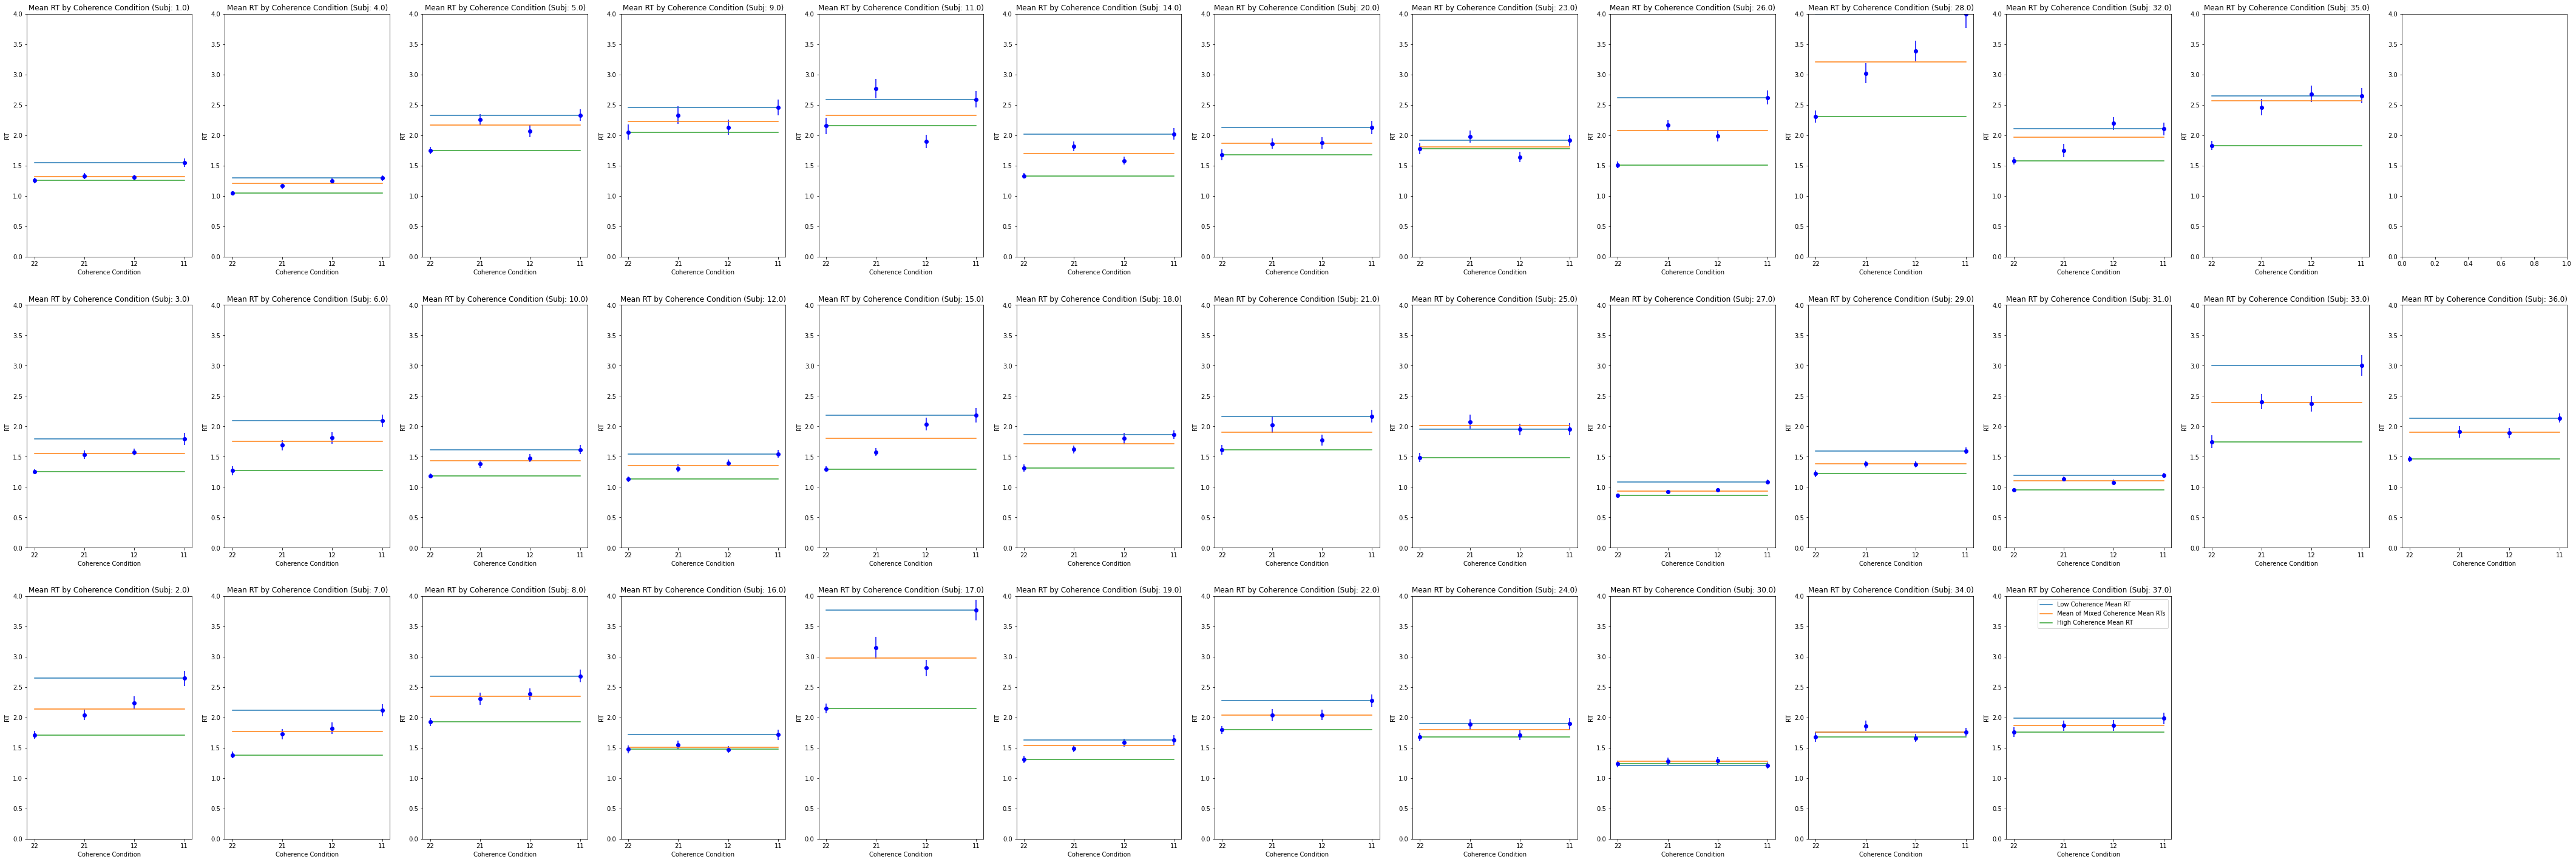

In [ ]:
# Plotting each subject
chong_median_rt = []
coh_conds = ['22','21','12','11']
#top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
#bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
#middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
#plt.ylim((0,4))
chong_group_median_rt = []
plt.figure(figsize=(75,25))
for j,i in enumerate(np.unique(chong_data.subj_idx)):
  if i+1 in cond_subj_id[0]:
    loc = np.where(cond_subj_id[0]==i+1)[0][0] + 1
  if i+1 in cond_subj_id[2]:
    loc = np.where(cond_subj_id[2]==i+1)[0][0] + 14
  if i+1 in cond_subj_id[4]:
    loc = np.where(cond_subj_id[4]==i+1)[0][0] + 27
  plt.subplot(3,13,j+1,ylim=(0,4))
  chong_median_rt = []
  chong_sterr_rt = []
  for i in coh_conds:
    chong_median_rt.append(np.mean(chong_group_data[j].rt[chong_group_data[j].cond2==i]))
    chong_sterr_rt.append(np.std(chong_group_data[j].rt[chong_group_data[j].cond2==i])/np.sqrt(len(chong_group_data[j].rt[chong_group_data[j].cond2==i])))
  top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
  bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
  mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
  middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
#chong_group_median_rt = np.array(chong_group_median_rt)
  plt.subplot(3,13,loc,ylim=(0,4))
  plt.plot(coh_conds,top_line)
  plt.plot(coh_conds,middle_line)
  plt.plot(coh_conds,bottom_line)
  #plt.plot(coh_conds,chong_median_rt,'bo')
  plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
  #plt.xticks([0,1,2,3],coh_conds)
  plt.ylabel("RT")
  plt.xlabel("Coherence Condition")
  plt.title("Mean RT by Coherence Condition (Subj: {})".format(subj_id[j]));
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

#### Super-subject RT behavior by task condition

In [ ]:
# # Plotting each subject
# chong_median_rt = []
# coh_conds = ['22','21','12','11']
# #top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
# #bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
# #middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
# for i in coh_conds:
#   chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))

# #plt.ylim((0,4))
# #chong_cond_median_rt = []
# plt.figure(figsize=(15,10))
# for j in range(6):
#   plt.subplot(2,3,j+1,ylim=(0,4))
#   chong_median_rt = []
#   chong_sterr_rt = []
#   for i in coh_conds:
#     chong_median_rt.append(np.mean(chong_cond_data[j].rt[chong_cond_data[j].cond2==i]))
#     chong_sterr_rt.append(np.std(chong_cond_data[j].rt[chong_cond_data[j].cond2==i])/np.sqrt(len(chong_cond_data[j].rt[chong_cond_data[j].cond2==i])))
#   top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
#   bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
#   mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
#   middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
# #chong_group_median_rt = np.array(chong_group_median_rt)
#   plt.plot(coh_conds,top_line)
#   plt.plot(coh_conds,middle_line)
#   plt.plot(coh_conds,bottom_line)
#   #plt.plot(coh_conds,chong_median_rt,'bo')
#   plt.errorbar(x=coh_conds,y=chong_median_rt,yerr=chong_sterr_rt,fmt='bo')
#   #plt.xticks([0,1,2,3],coh_conds)
#   plt.ylabel("RT")
#   plt.xlabel("Coherence Condition")
#   plt.title("Mean RT by Coherence Condition (Cond: {})".format(conditions[j]));
# plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

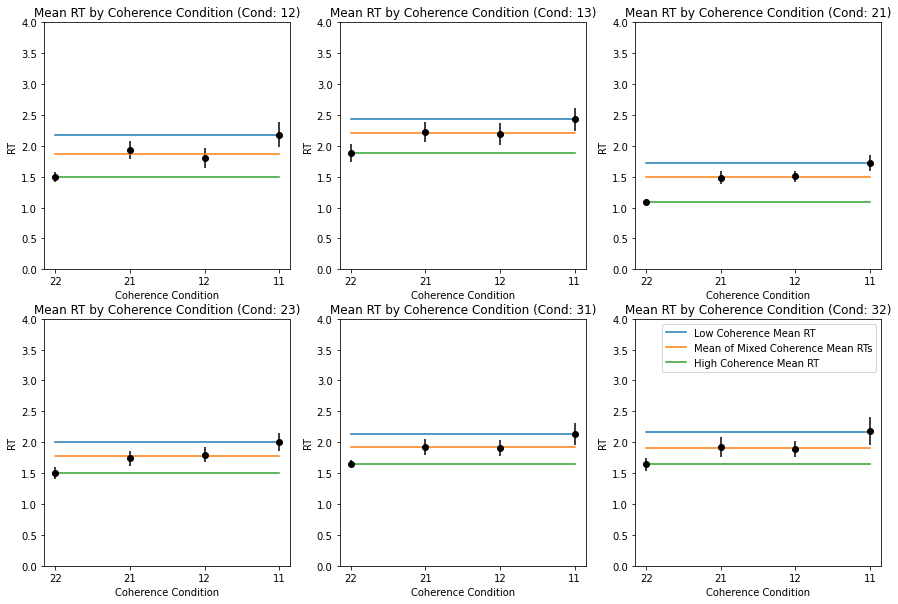

In [ ]:
# Plotting each subject
chong_median_rt = []
coh_conds = ['22','21','12','11']
#top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
#bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
#middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_median_rt.append(np.mean(chong_data.rt[chong_data.cond2==i]))
chong_cond_group_median_rt = []
chong_sterr_coh_cond_rt = []
#plt.ylim((0,4))
#chong_cond_median_rt = []
plt.figure(figsize=(15,10))
for j in range(6):
  plt.subplot(2,3,j+1,ylim=(0,4))
  chong_median_rt = []
  chong_cond_subj_coh_median_rt = []
  
  chong_sterr_coh_rt = []
  for k in coh_conds:
    chong_cond_subj_median_rt = []
    
    for i in range(len(cond_subj_id[j])):
      chong_cond_subj_median_rt.append(np.mean(chong_cond_group_data[j][i].rt[chong_cond_group_data[j][i].cond2==k]))
    chong_cond_subj_coh_median_rt.append(np.mean(chong_cond_subj_median_rt))
    chong_sterr_coh_rt.append(np.std(chong_cond_subj_median_rt)/np.sqrt(len(chong_cond_subj_median_rt)))
  chong_cond_group_median_rt.append(chong_cond_subj_coh_median_rt)
  chong_sterr_coh_cond_rt.append(chong_sterr_coh_rt)
  for i in coh_conds:
    chong_median_rt.append(np.mean(chong_cond_data[j].rt[chong_cond_data[j].cond2==i]))
  top_line = [chong_median_rt[3],chong_median_rt[3],chong_median_rt[3],chong_median_rt[3]]
  bottom_line = [chong_median_rt[0],chong_median_rt[0],chong_median_rt[0],chong_median_rt[0]]
  mid_mean = np.mean([chong_median_rt[1],chong_median_rt[2]])
  middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
#chong_group_median_rt = np.array(chong_group_median_rt)
  plt.plot(coh_conds,top_line)
  plt.plot(coh_conds,middle_line)
  plt.plot(coh_conds,bottom_line)
  #plt.boxplot(chong_cond_group_median_rt[j],positions=[0,1,2,3])
  plt.errorbar(x=coh_conds,y=chong_cond_group_median_rt[j],yerr=chong_sterr_coh_cond_rt[j],fmt='ko')
  plt.xticks([0,1,2,3],coh_conds)
  plt.ylabel("RT")
  plt.xlabel("Coherence Condition")
  plt.title("Mean RT by Coherence Condition (Cond: {})".format(conditions[j]));
plt.legend(["Low Coherence Mean RT","Mean of Mixed Coherence Mean RTs","High Coherence Mean RT"]);

# From Oscar

In [ ]:
#par2_model = hddm.load('downloads/ddm_par2_chong_model')
#mic2_model = hddm.load('downloads/ddm_mic2_chong_model')
#seq2_model = hddm.load('downloads/ddm_seq2_chong_model')
par2_data = hddm.load('ddm_par2_chong.db')
mic2_data = hddm.load('ddm_mic2_chong.db')
seq2_data = hddm.load('ddm_seq2_chong.db')

## Par2

In [ ]:
par2_keys = [i for i in par2_data.keys()][1:-1]
par2_keys.sort()
par2_keys = par2_keys[2:]+par2_keys[0:2]
par2_data = pd.DataFrame(par2_data)
par2_data = np.stack(par2_data[par2_keys].to_numpy()[0,:])
par2_data = pd.DataFrame(data=par2_data.T,columns=par2_keys)
static = ['zh','zl1','zl2']
par2_data[static] = 0.5
par2_keys = par2_keys[0:-1] + static + [par2_keys[-1]]
par2_data = par2_data[par2_keys]

In [ ]:
hddm.model_config.model_config['ddm_par2']

In [ ]:
vhs = [i for i in par2_data.columns if 'vh' in i]
vl1s = [i for i in par2_data.columns if 'vl1' in i]
vl2s = [i for i in par2_data.columns if 'vl2' in i]

In [ ]:
par2_out = {}
np.random.seed(2)
n=10000
thetas = par2_data.sample(n=n,replace=True)
for i in [1,2]:
  for j in [1,2]:
    for k in [1,2]:
      theta_list = ['vh({}.{}.{})'.format(i,j,k),'vh({}.{}.{})'.format(i,j,k),'vh({}.{}.{})'.format(i,j,k),'a','zh','zl1','zl2','t']
      par2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]

In [ ]:
par2_out = {}
np.random.seed(2)
n=10000
thetas = par2_data.sample(n=n,replace=True)
for i in [1,2]:
  for j in [1,2]:
    for k in [1,2]:
      theta_list = ['vh({}.{}.{})'.format(i,j,k),'vh({}.{}.{})'.format(i,j,k),'vh({}.{}.{})'.format(i,j,k),'a','zh','zl1','zl2','t']
      par2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]

In [ ]:
cond_keys = [i for i in par2_out.keys()]

In [ ]:
par2_out[cond_keys[i-1]][0][par2_out[cond_keys[i-1]][1] == 3]

array([1.1612948 , 0.5780635 , 0.79082596, ..., 1.2172834 , 0.91426194,
       0.88938797], dtype=float32)

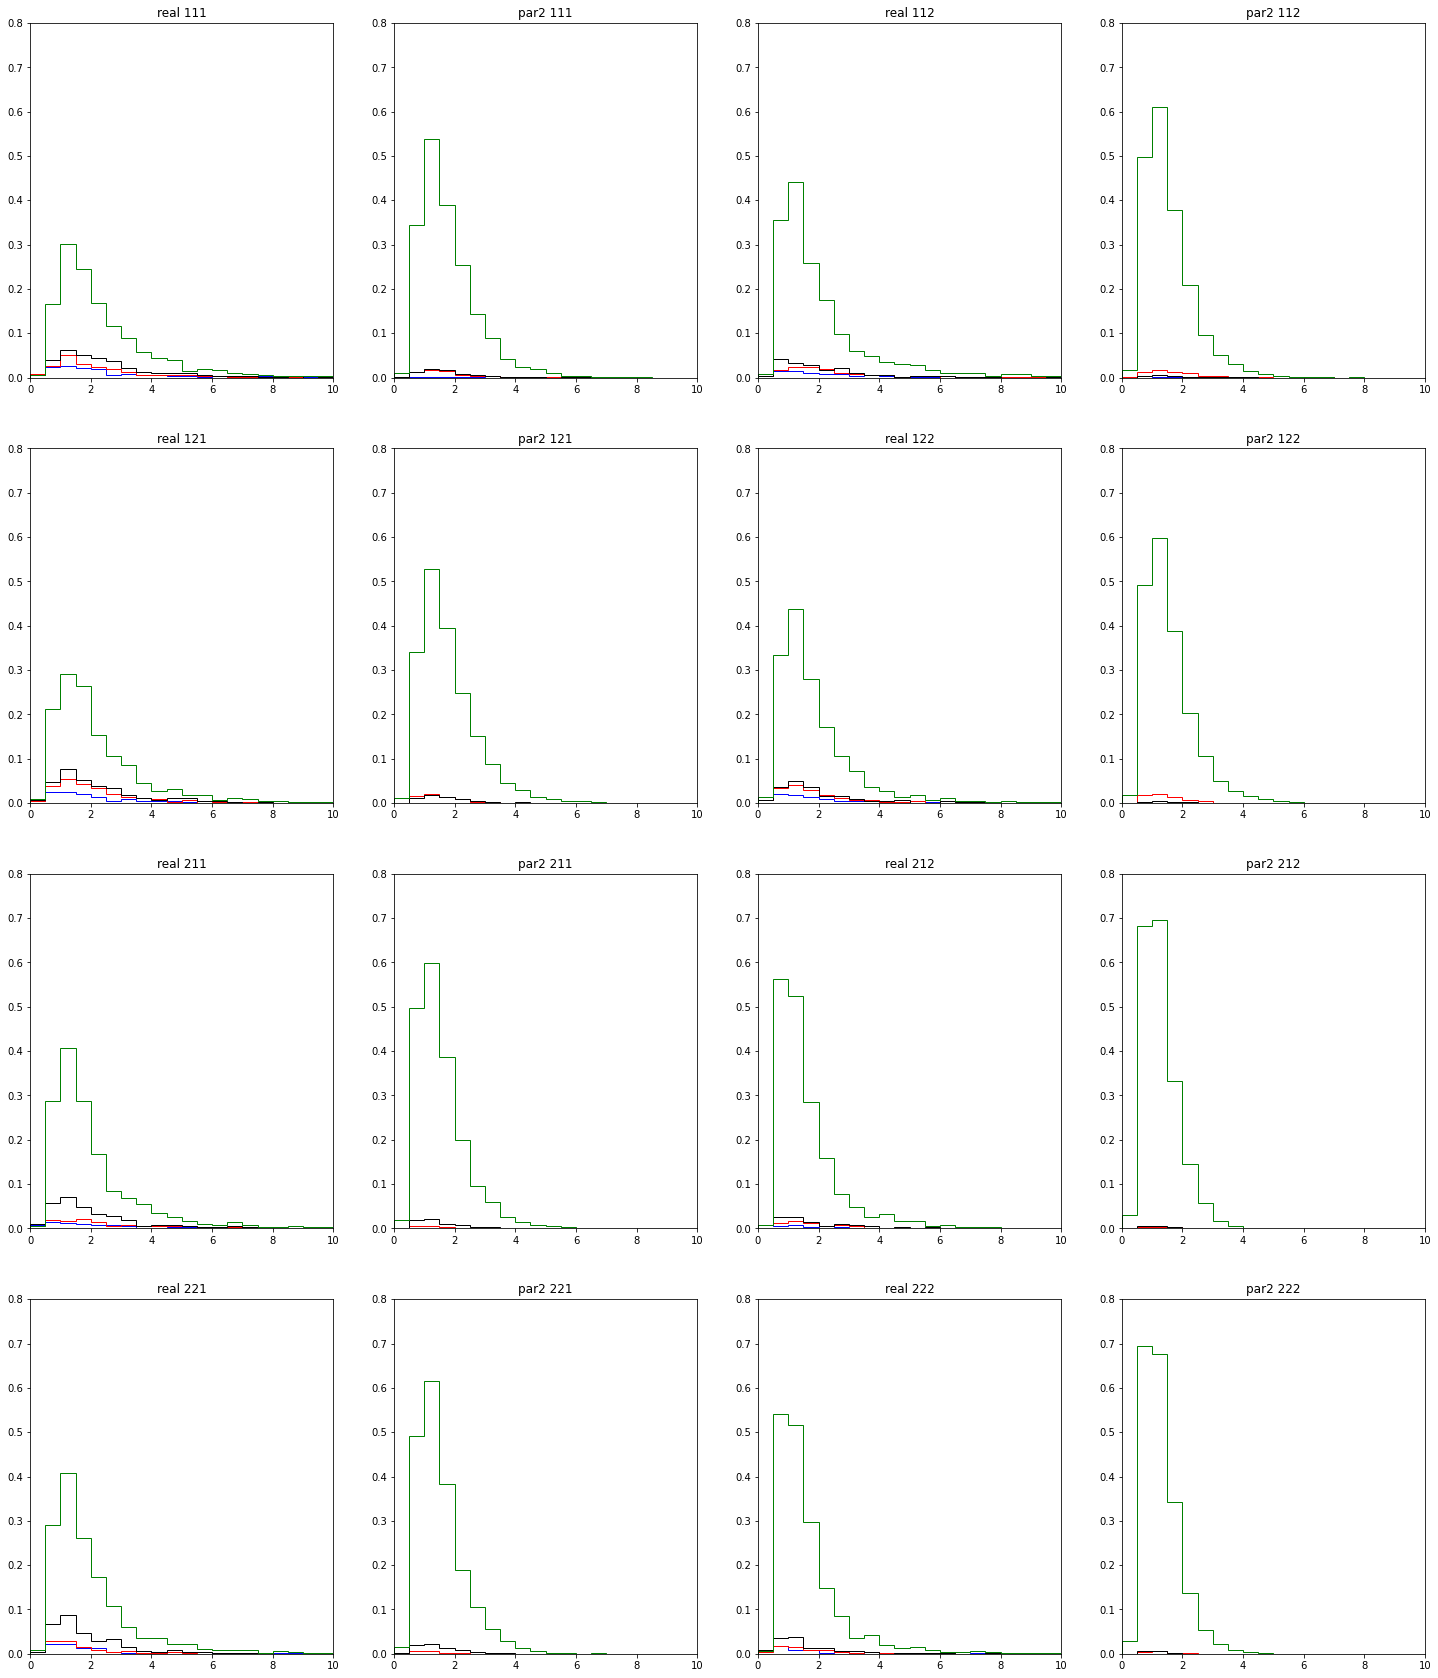

In [ ]:
fig = plt.figure(figsize=(25,30))
color = ['blue','red', 'black', 'green']
for i in range(1,len(cond_keys)+1):
  for j in range(4):
    plt.subplot(4,4,i*2,xlim=(0,10),ylim=(0,0.8))
    plt.hist(par2_out[cond_keys[i-1]][0][par2_out[cond_keys[i-1]][1] == j],
            density=False,
            histtype = 'step',
            color = color[j],
            range=(0,10),
            bins=20,
            weights=np.ones(par2_out[cond_keys[i-1]][0][par2_out[cond_keys[i-1]][1] == j].shape[0])/(n/2))
    plt.title('par2 {}'.format(cond_keys[i-1]))
#for i in range(1,9):
    plt.subplot(4,4,i*2 - 1,xlim=(0,10),ylim=(0,0.8))
    plt.hist(chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'][chong_data[chong_data['cond']==cond_keys[i-1]]['response'] == j],
            density=False,
            histtype='step',
            color = color[j],
            range=(0,10),
            bins=20,
            weights=np.ones(chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'][chong_data[chong_data['cond']==cond_keys[i-1]]['response'] == j].shape[0])*2/chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'].shape[0])
    plt.title('real {}'.format(cond_keys[i-1]))

In [ ]:
par2_model = hddm.load('ddm_par2_chong_model')

INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmp8qa3o0nh/assets


INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmp8qa3o0nh/assets
2021-08-20 12:26:41.993764: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-08-20 12:26:41.993825: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-08-20 12:26:41.993927: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-20 12:26:41.993940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-08-20 12:26:41.994371: I tensorflow/core/grappler/optimizers/meta_o

Plotting vh(1)
Plotting vh(2)
Plotting vl1(1)
Plotting vl1(2)
Plotting vl2(1)
Plotting vl2(2)
Plotting a
Plotting t


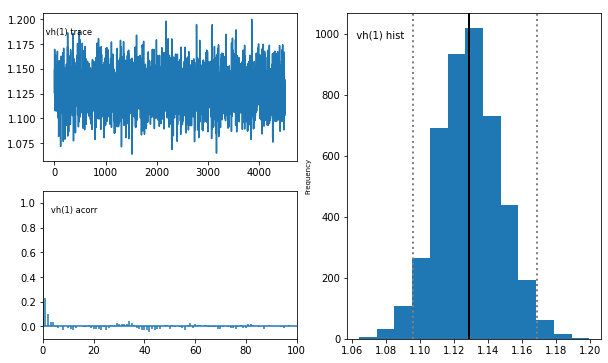

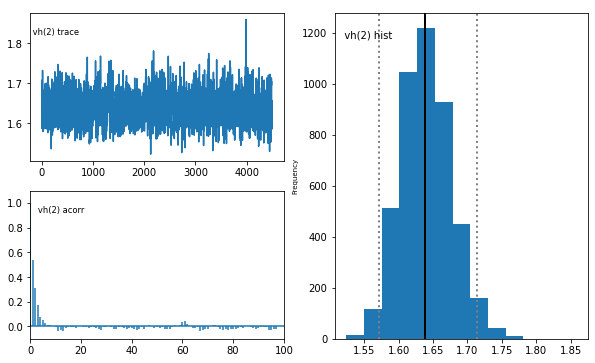

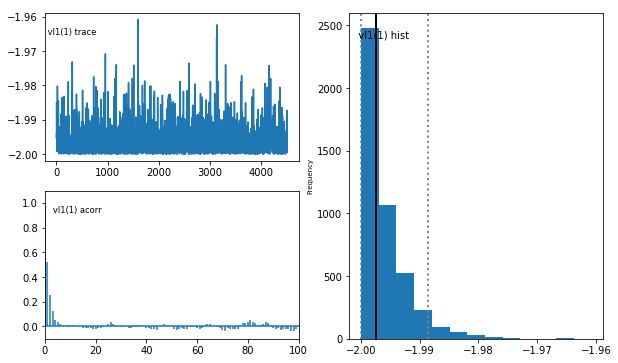

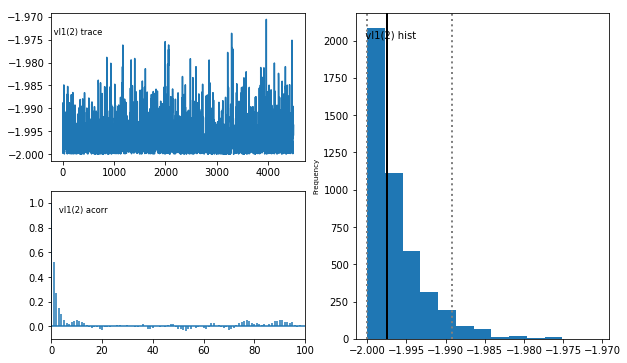

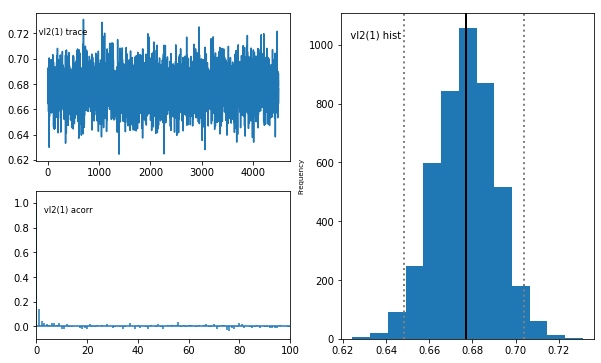

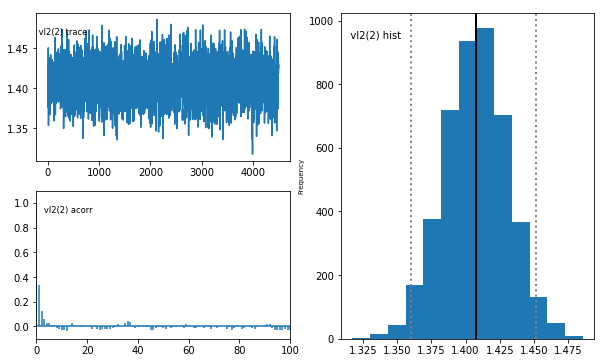

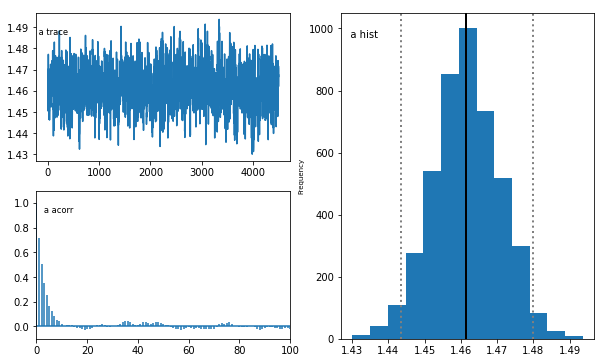

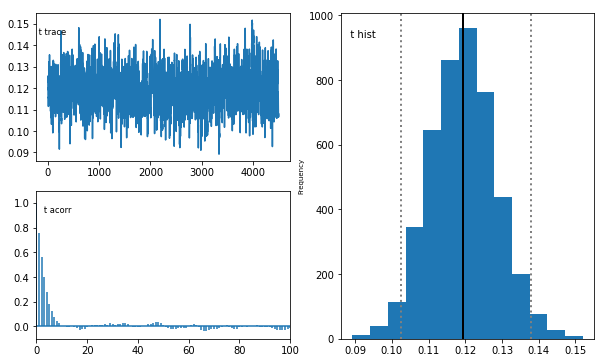

In [ ]:
par2_model.plot_posteriors()

## Mic2

In [ ]:
mic2_keys = [i for i in mic2_data.keys()][1:-1]
mic2_keys.sort()
mic2_keys = mic2_keys[2:]+mic2_keys[0:2]
mic2_data = pd.DataFrame(mic2_data)
mic2_data = np.stack(mic2_data[mic2_keys].to_numpy()[0,:])
mic2_data = pd.DataFrame(data=mic2_data.T,columns=mic2_keys)
static = ['zh','zl1','zl2','d']
mic2_data[static] = 0.5
mic2_keys = mic2_keys[0:-1] + static + [mic2_keys[-1]]
mic2_data = mic2_data[mic2_keys]

In [ ]:
mic2_out = {}
thetas = mic2_data.sample(n=10000,replace=True)
for i in [1,2]:
  for j in [1,2]:
    for k in [1,2]:
      theta_list = ['vh({}.{}.{})'.format(i,j,k),'vh({}.{}.{})'.format(i,j,k),'vh({}.{}.{})'.format(i,j,k),'a','zh','zl1','zl2','d','t']
      mic2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_mic2',n_samples=1)[0:2]

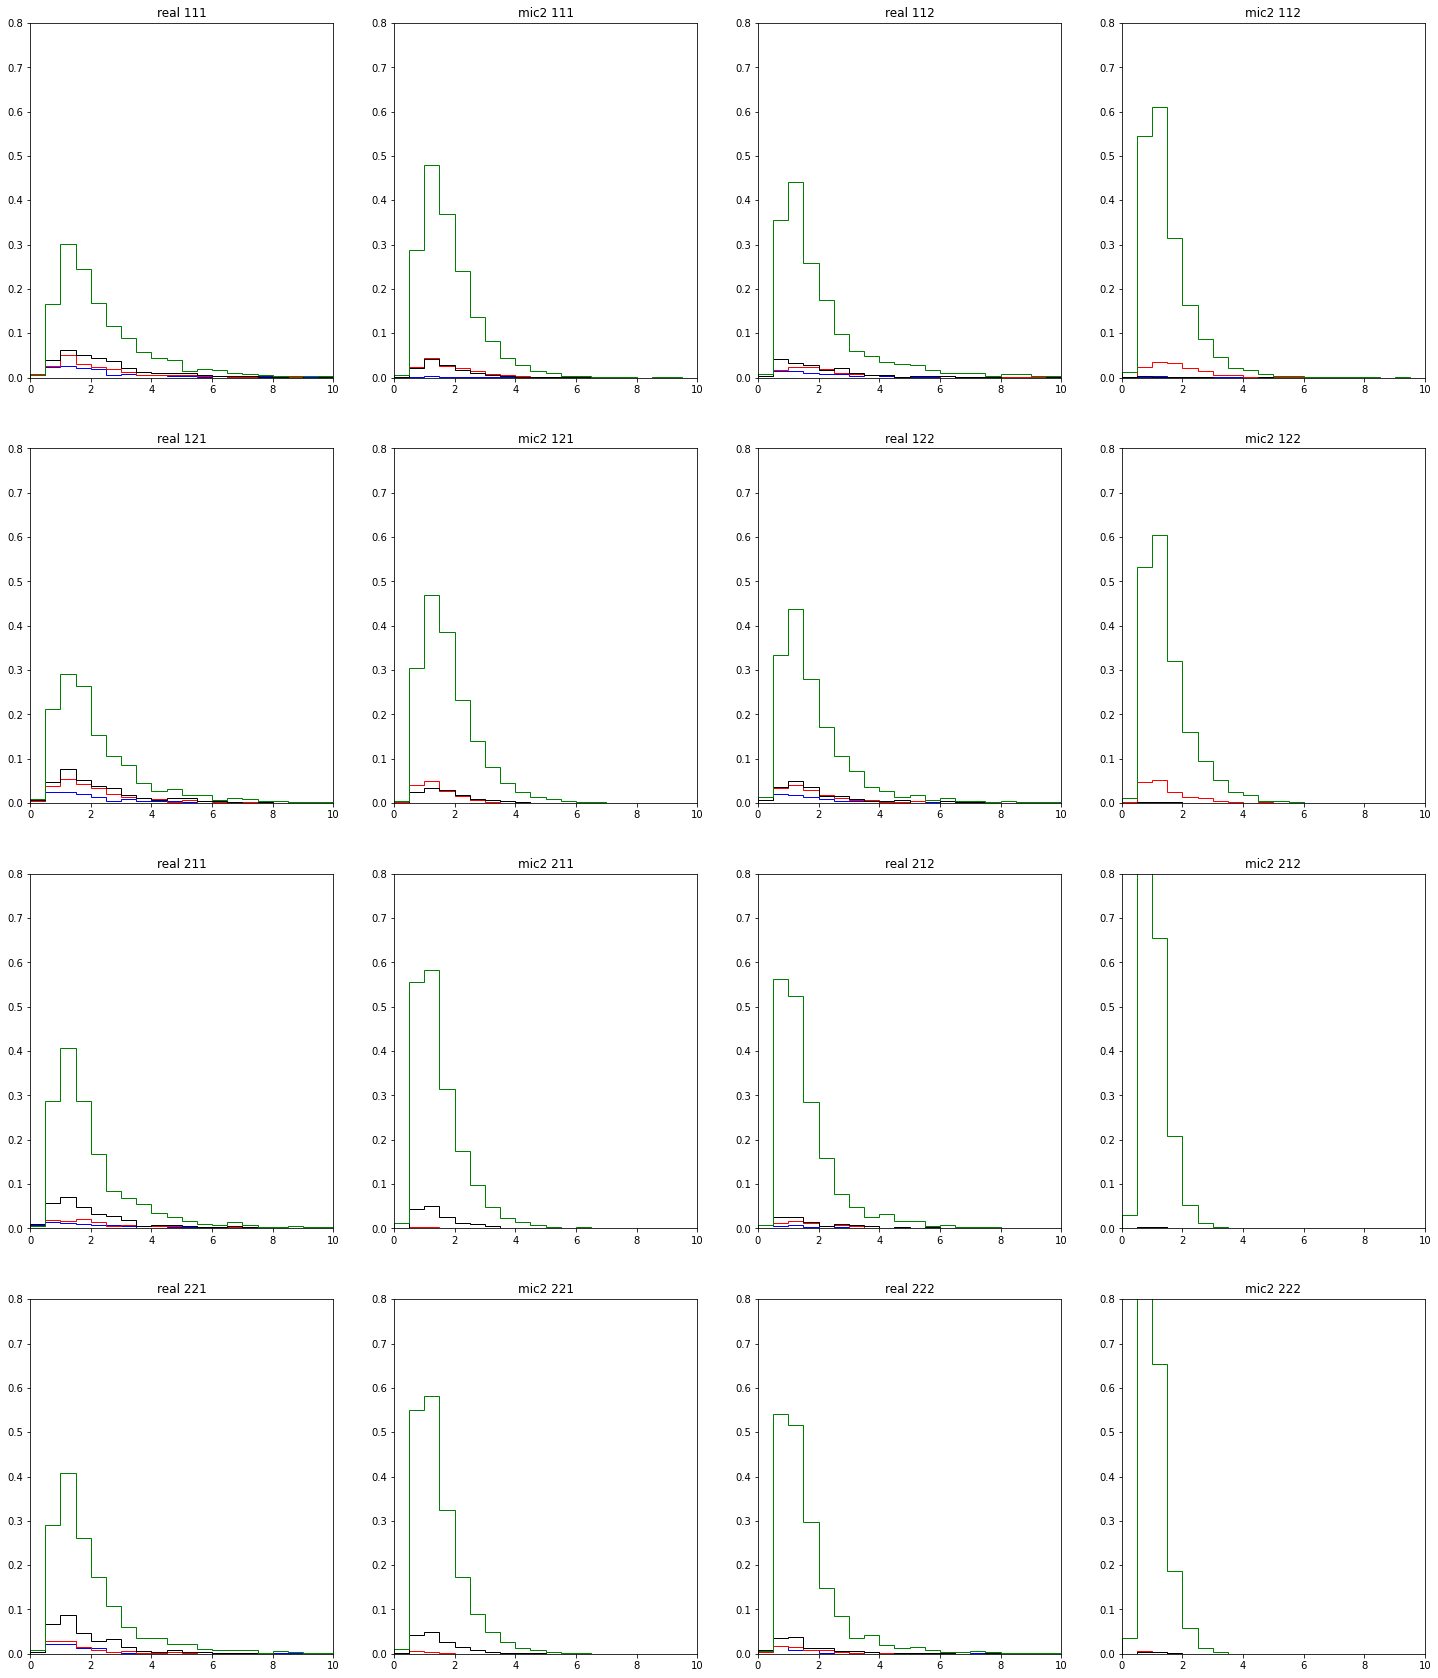

In [ ]:
fig = plt.figure(figsize=(25,30))
color = ['blue','red', 'black', 'green']
for i in range(1,len(cond_keys)+1):
  for j in range(4):
    plt.subplot(4,4,i*2,xlim=(0,10),ylim=(0,0.8))
    plt.hist(mic2_out[cond_keys[i-1]][0][mic2_out[cond_keys[i-1]][1] == j],
            density=False,
            histtype = 'step',
            color = color[j],
            range=(0,10),
            bins=20, #20
            weights=np.ones(mic2_out[cond_keys[i-1]][0][mic2_out[cond_keys[i-1]][1] == j].shape[0])/5000)
    plt.title('mic2 {}'.format(cond_keys[i-1]))
#for i in range(1,9):
    plt.subplot(4,4,i*2 - 1,xlim=(0,10),ylim=(0,0.8))
    plt.hist(chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'][chong_data[chong_data['cond']==cond_keys[i-1]]['response'] == j],
            density=False,
            histtype='step',
            color = color[j],
            range=(0,10),
            bins=20, #20
            weights=np.ones(chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'][chong_data[chong_data['cond']==cond_keys[i-1]]['response'] == j].shape[0])*2/chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'].shape[0])
    plt.title('real {}'.format(cond_keys[i-1]))

In [ ]:
mic2_model = hddm.load('ddm_mic2_chong_model')

INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmp1ujx3ck1/assets


INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmp1ujx3ck1/assets
2021-08-20 12:27:26.244625: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-08-20 12:27:26.244697: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-08-20 12:27:26.244805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-20 12:27:26.244817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-08-20 12:27:26.245268: I tensorflow/core/grappler/optimizers/meta_o

Plotting vh(1)
Plotting vh(2)
Plotting vl1(1)
Plotting vl1(2)
Plotting vl2(1)
Plotting vl2(2)
Plotting a
Plotting d
Plotting t


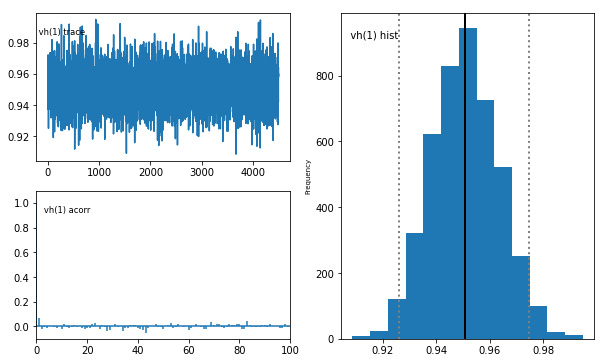

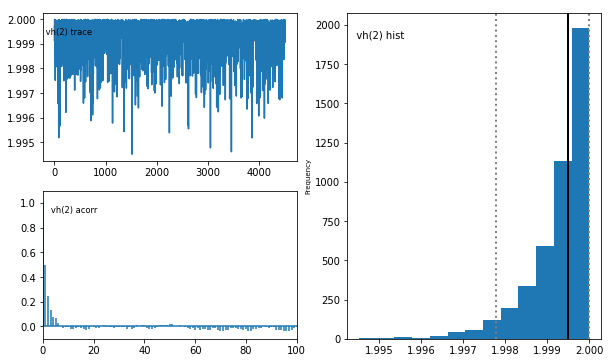

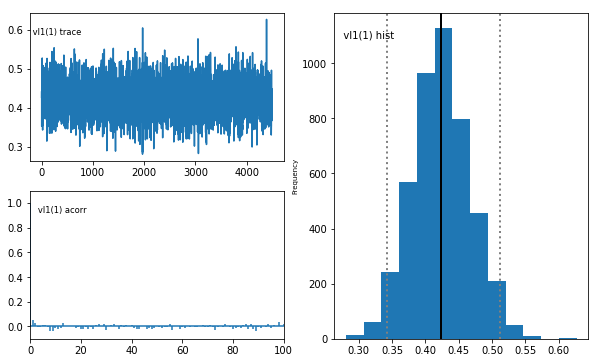

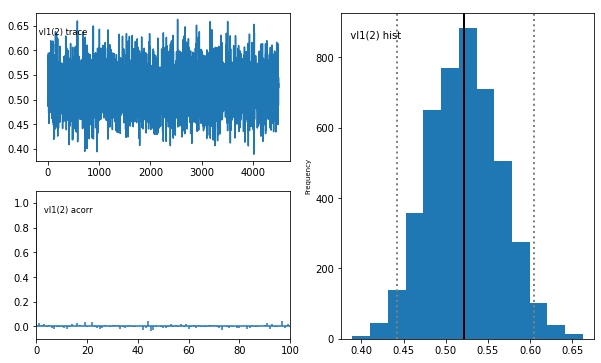

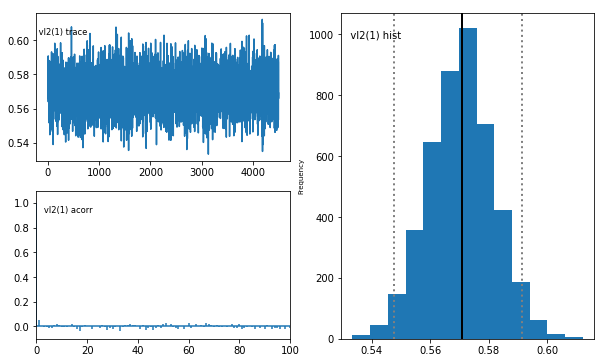

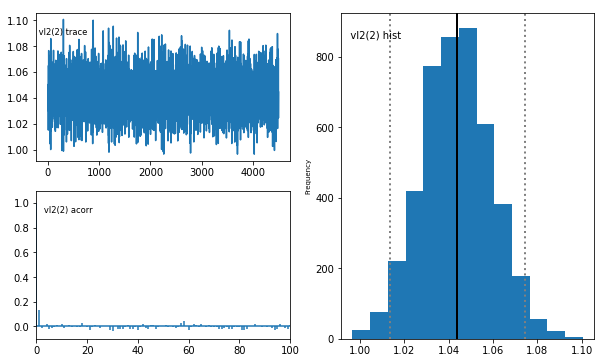

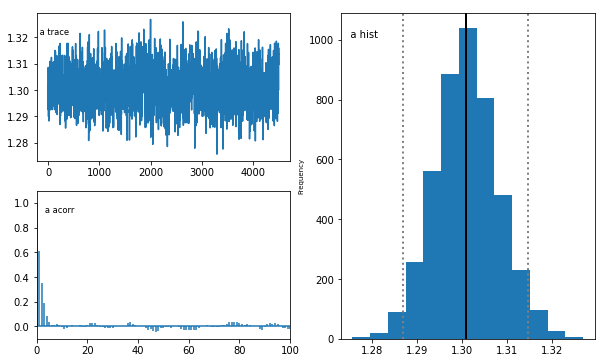

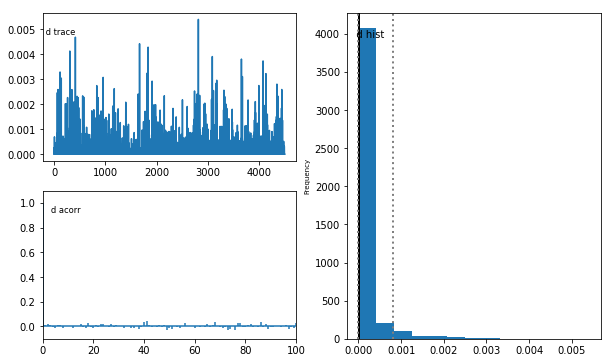

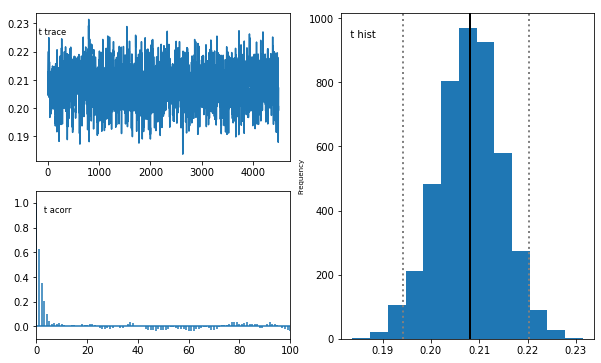

In [ ]:
mic2_model.plot_posteriors()

## Seq2

In [ ]:
seq2_keys = [i for i in seq2_data.keys()][1:-1]
seq2_keys.sort()
seq2_keys = seq2_keys[2:]+seq2_keys[0:2]
seq2_data = pd.DataFrame(seq2_data)
seq2_data = np.stack(seq2_data[seq2_keys].to_numpy()[0,:])
seq2_data = pd.DataFrame(data=seq2_data.T,columns=seq2_keys)
static = ['zh','zl1','zl2']
seq2_data[static] = 0.5
seq2_keys = seq2_keys[0:-1] + static + [seq2_keys[-1]]
seq2_data = seq2_data[seq2_keys]

In [ ]:
seq2_out = {}
thetas = seq2_data.sample(n=10000,replace=True)
for i in [1,2]:
  for j in [1,2]:
    for k in [1,2]:
      theta_list = ['vh({}.{}.{})'.format(i,j,k),'vh({}.{}.{})'.format(i,j,k),'vh({}.{}.{})'.format(i,j,k),'a','zh','zl1','zl2','t']
      seq2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_seq2',n_samples=1)[0:2]

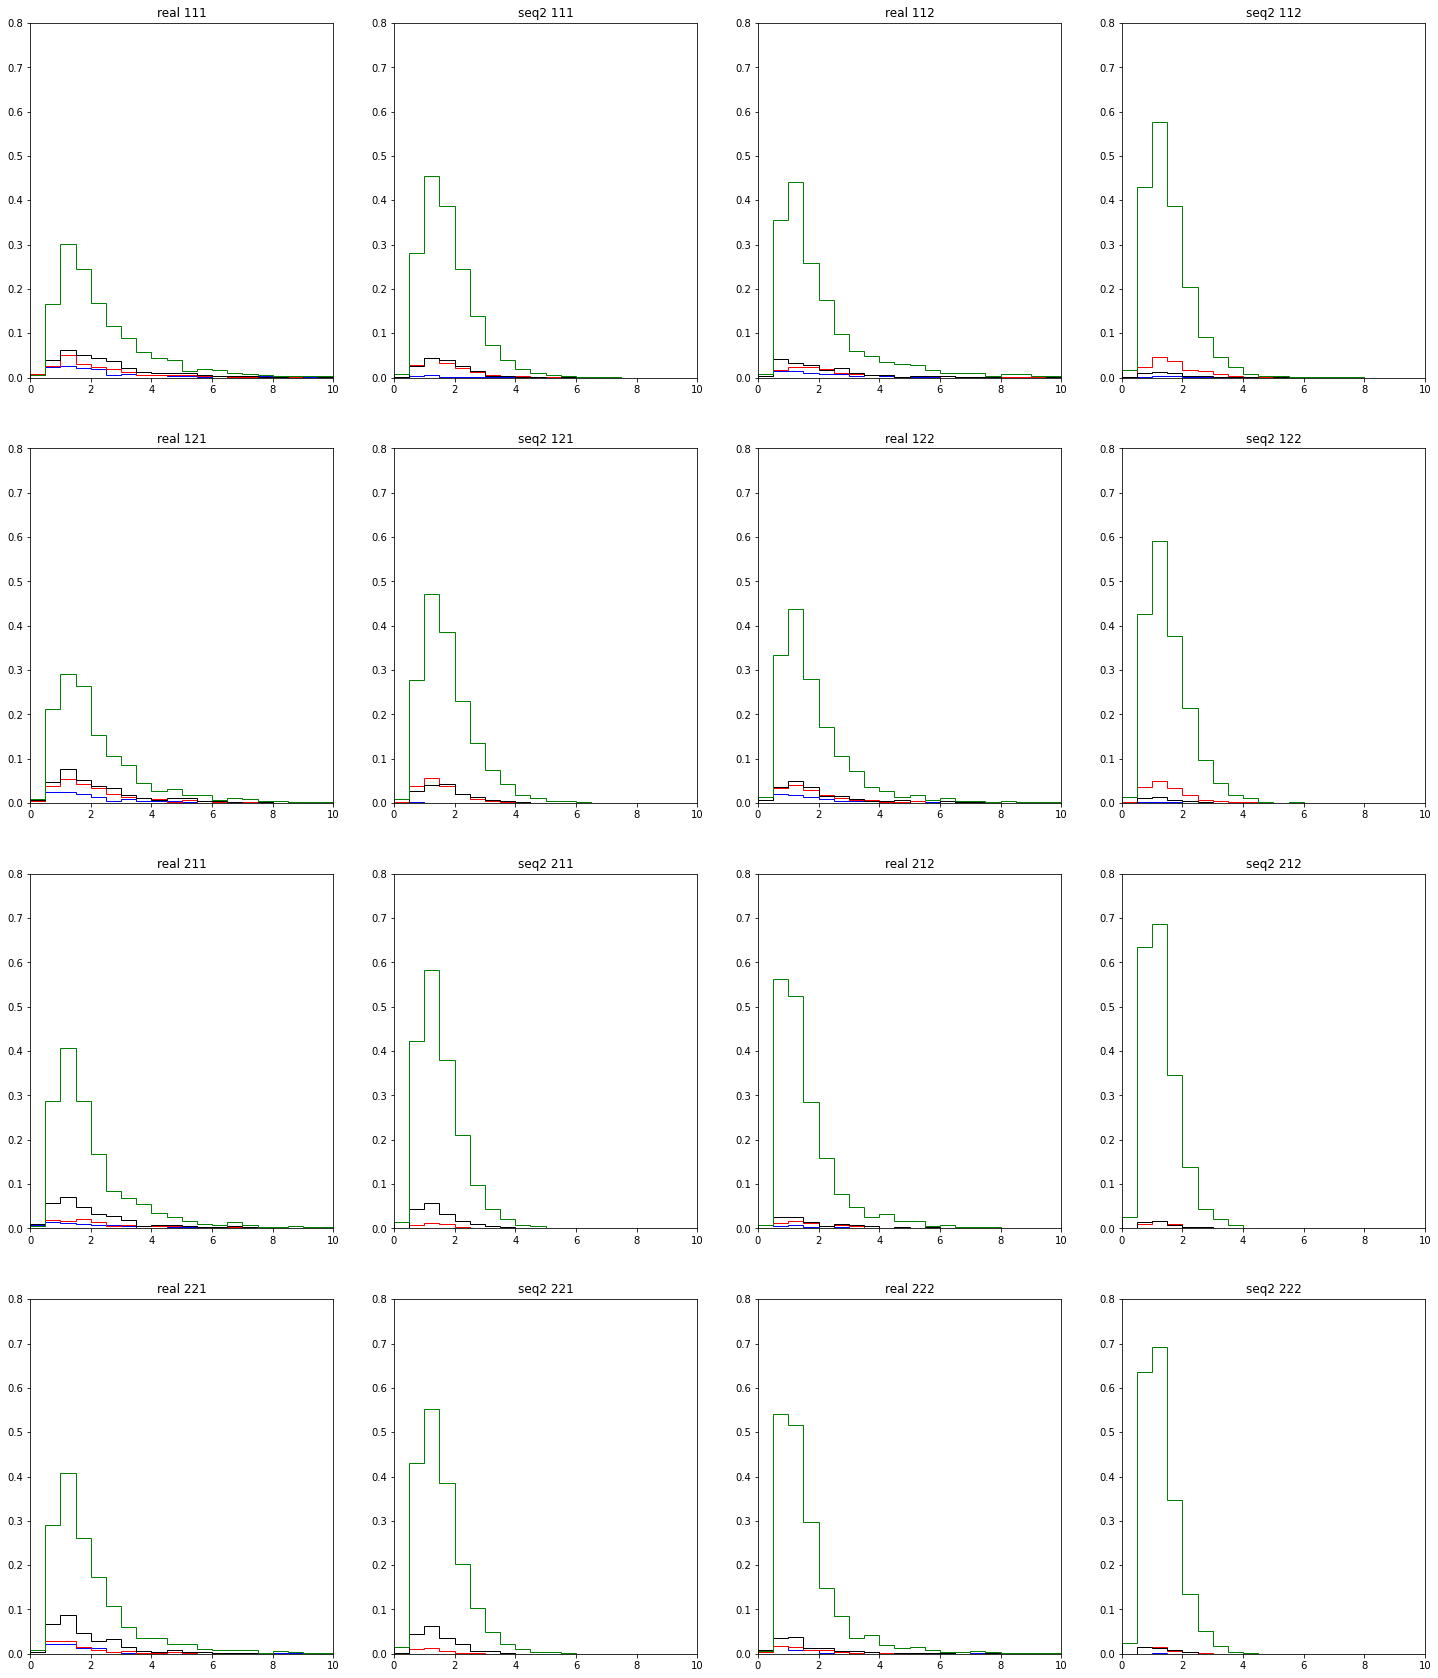

In [ ]:
fig = plt.figure(figsize=(25,30))
color = ['blue','red', 'black', 'green']
for i in range(1,len(cond_keys)+1):
  for j in range(4):
    plt.subplot(4,4,i*2,xlim=(0,10),ylim=(0,0.8))
    plt.hist(seq2_out[cond_keys[i-1]][0][seq2_out[cond_keys[i-1]][1] == j],
            density=False,
            histtype = 'step',
            color = color[j],
            range=(0,10),
            bins=20,
            weights=np.ones(seq2_out[cond_keys[i-1]][0][seq2_out[cond_keys[i-1]][1] == j].shape[0])/5000)
    plt.title('seq2 {}'.format(cond_keys[i-1]))
#for i in range(1,9):
    plt.subplot(4,4,i*2 - 1,xlim=(0,10),ylim=(0,0.8))
    plt.hist(chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'][chong_data[chong_data['cond']==cond_keys[i-1]]['response'] == j],
            density=False,
            histtype='step',
            color = color[j],
            range=(0,10),
            bins=20,
            weights=np.ones(chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'][chong_data[chong_data['cond']==cond_keys[i-1]]['response'] == j].shape[0])*2/chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'].shape[0])
    plt.title('real {}'.format(cond_keys[i-1]))

In [ ]:
seq2_model = hddm.load('ddm_seq2_chong_model')

INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmps3wrj0g9/assets


INFO:tensorflow:Assets written to: /var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/tmps3wrj0g9/assets
2021-08-20 12:28:28.227741: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-08-20 12:28:28.227822: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-08-20 12:28:28.227928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-20 12:28:28.227938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-08-20 12:28:28.228358: I tensorflow/core/grappler/optimizers/meta_o

Plotting vh(1)
Plotting vh(2)
Plotting vl1(1)
Plotting vl1(2)
Plotting vl2(1)
Plotting vl2(2)
Plotting a
Plotting t


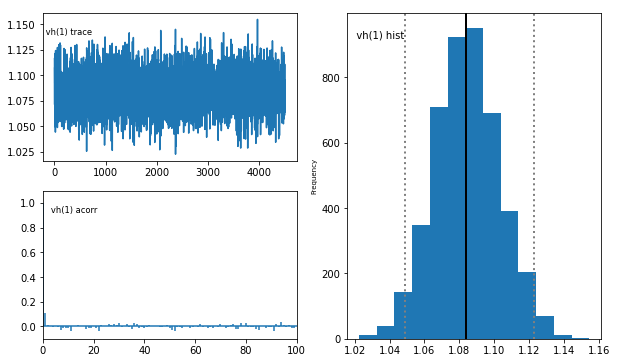

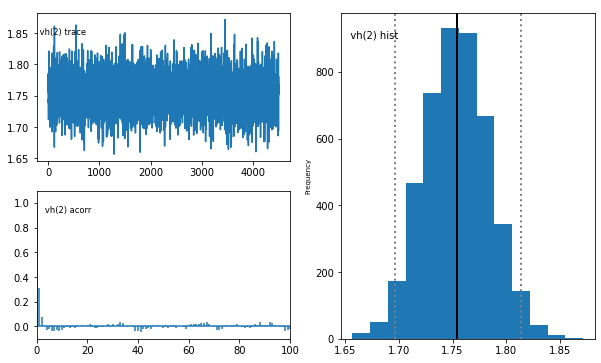

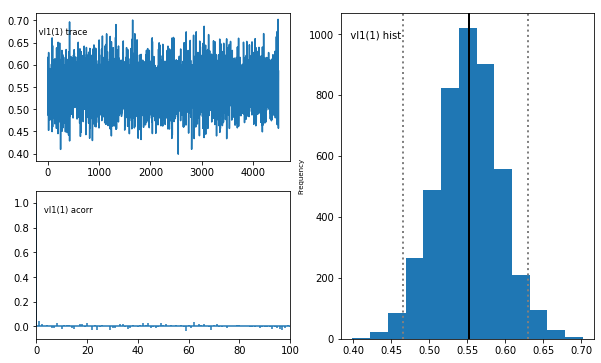

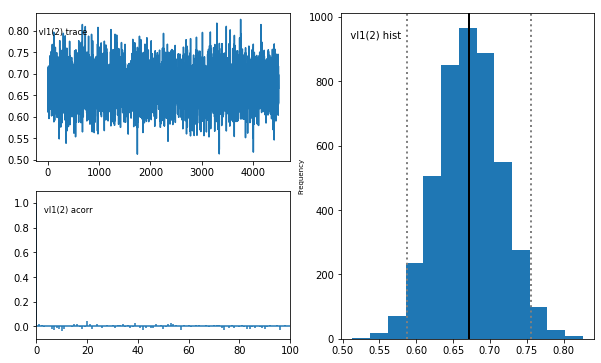

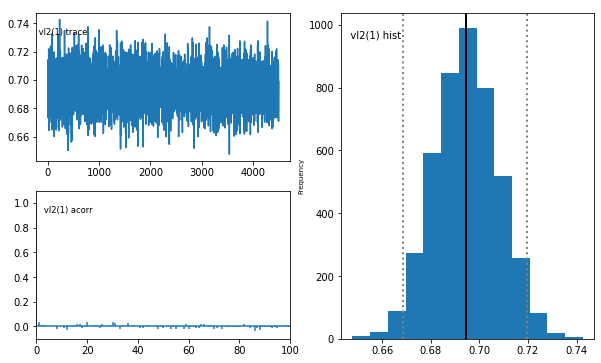

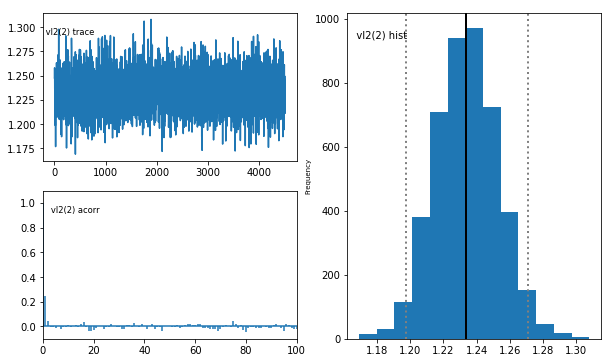

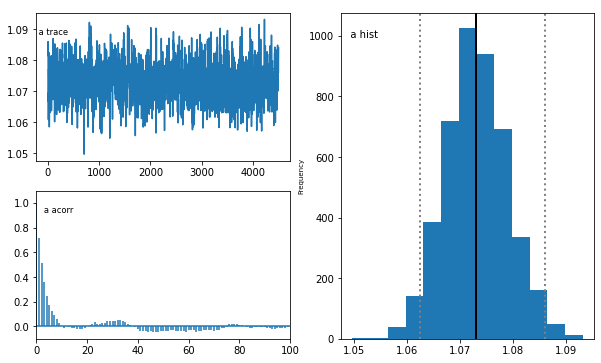

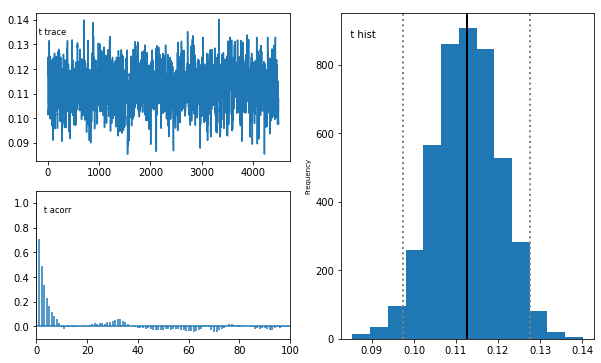

In [ ]:
seq2_model.plot_posteriors()

# Recover Self

In [16]:
# Metadata
nmcmc = 500
model = 'ddm_par2_no_bias'
n_samples_by_subject = 500
n_subjects = 1

In [ ]:
thetas = np.ones((500,8))*np.array([2.3,2.1,1.8,0.4,0.5,0.5,0.5,0.6])

In [ ]:
out = hddm.simulators.basic_simulator.simulator(theta=thetas[1,:], model='ddm_par2',n_samples=500)

In [ ]:
par2_data=np.concatenate([np.concatenate(out[0]).reshape((-1,1)),np.concatenate(out[1]).reshape((-1,1)),np.zeros((500,1)),thetas],axis=1)

In [ ]:
par2_data = pd.DataFrame(data=par2_data,columns=['rt','response','subj_idx','vh','vl1','vl2','a','zh','zl1','zl2','t'])

In [5]:
# test regressors only False
# add p_outliers to the generator !
#depends_on = {'vh': 'highDimCoh','vl1': 'irrDimCoh','vl2': 'lowDimCoh'}
#conditions = {'highDimCoh': [1,2],'irrDimCoh': [1,2],'lowDimCoh': [1,2]}
data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = n_subjects,
                                                                                  n_trials_per_subject = n_samples_by_subject,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, 
                                                                                  depends_on = None,
                                                                                  regression_models = None,
                                                                                  regression_covariates = None,
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None
                                                                                  )

None
{'vl2', 't', 'vl1', 'vh', 'a'}
          vh       vl1       vl2         a         t
0   -2.54704 -1.723959  2.101299  0.615725 -0.106516
1   -2.54704 -1.723959  2.101299  0.615725 -0.106516
2   -2.54704 -1.723959  2.101299  0.615725 -0.106516
3   -2.54704 -1.723959  2.101299  0.615725 -0.106516
4   -2.54704 -1.723959  2.101299  0.615725 -0.106516
..       ...       ...       ...       ...       ...
495 -2.54704 -1.723959  2.101299  0.615725 -0.106516
496 -2.54704 -1.723959  2.101299  0.615725 -0.106516
497 -2.54704 -1.723959  2.101299  0.615725 -0.106516
498 -2.54704 -1.723959  2.101299  0.615725 -0.106516
499 -2.54704 -1.723959  2.101299  0.615725 -0.106516

[500 rows x 5 columns]
new round of data simulation because parameter bounds where violated
           vh       vl1       vl2         a         t
0   -0.704106  1.952877 -2.396719  1.019703  0.229612
1   -0.704106  1.952877 -2.396719  1.019703  0.229612
2   -0.704106  1.952877 -2.396719  1.019703  0.229612
3   -0.704106  1.95

In [12]:
hddmnn_model = hddm.HDDMnn(data,#data[['rt','response','t', 'a', 'vl1', 'vh', 'vl2']],
                           model = model,
                           informative = False,
                           is_group_model = False,
                           include = hddm.simulators.model_config[model]['hddm_include'],
                           #include = ['t', 'a', 'vl1', 'vh', 'vl2'],
                           p_outlier = 0.0,
                           network_type='torch_mlp')

Setting priors uninformative (LANs only work with uninformative priors for now)
tanh
tanh
tanh
linear
def custom_likelihood(x, vh, vl1, vl2, a, t, p_outlier=0.0, w_outlier=0.1, network = None):
    return hddm.wfpt.wiener_like_nn_mlp(x["rt"].values, x["response"].values, np.array([vh, vl1, vl2, a, t], dtype = np.float32), p_outlier=p_outlier, w_outlier=w_outlier, network=network)
{'model': 'ddm_par2_no_bias', 'likelihood_str': 'def custom_likelihood(x, vh, vl1, vl2, a, t, p_outlier=0.0, w_outlier=0.1, network = None):\n    return hddm.wfpt.wiener_like_nn_mlp(x["rt"].values, x["response"].values, np.array([vh, vl1, vl2, a, t], dtype = np.float32), p_outlier=p_outlier, w_outlier=w_outlier, network=network)', 'custom_likelihood': <function custom_likelihood at 0x298c0bee0>}
<function custom_likelihood at 0x298c0bee0>
{'is_group_model': False}
['vh', 'vl1', 'vl2', 'a', 't']
printing self.nn
True
More than 2-choice model --> don't flip any responses.
Make sure you supplied rt and choice dat

In [13]:
hddmnn_model.sample(nmcmc,
                    burn = 50) # if you want to save the model specify extra arguments --> dbname='traces.db', db='pickle'. # hddmnn_model.save('test_model')

 [-----------------100%-----------------] 500 of 500 complete in 7.0 sec

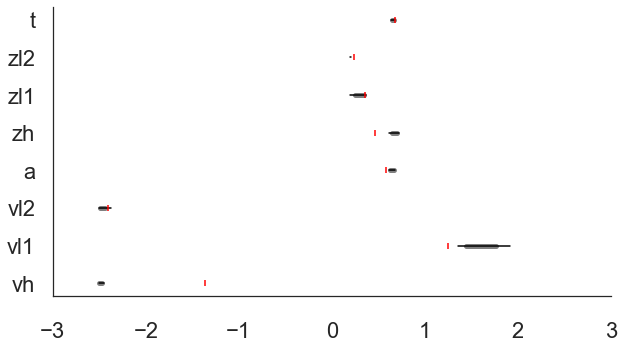

In [ ]:
hddm.plotting.caterpillar_plot(hddm_model = hddmnn_model,
                               ground_truth_parameter_dict = full_parameter_dict,
                               drop_sd = False,
                               x_limits=[-3,3]
                               )

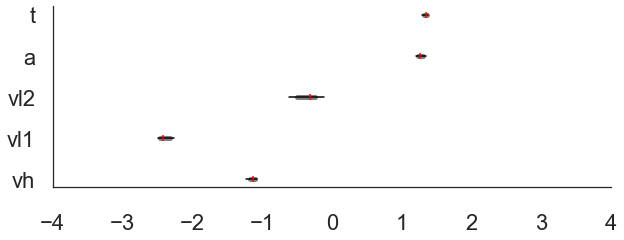

In [ ]:
hddm.plotting.caterpillar_plot(hddm_model = hddmnn_model,
                               ground_truth_parameter_dict = full_parameter_dict,
                               drop_sd = False,
                               x_limits=[-4,4]
                               )

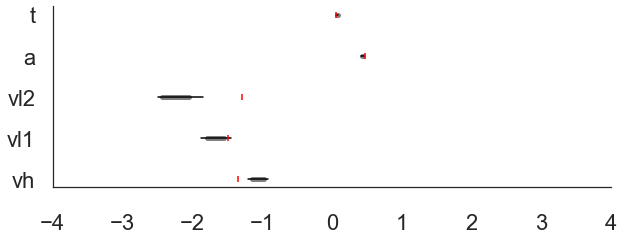

In [ ]:
hddm.plotting.caterpillar_plot(hddm_model = hddmnn_model,
                               ground_truth_parameter_dict = full_parameter_dict,
                               drop_sd = False,
                               x_limits=[-4,4]
                               )

In [ ]:
full_parameter_dict

{'zh': 0.4163426348794187,
 'zh_std': 0.04042168433318547,
 't': 0.0919944999487064,
 't_std': 0.094836685731274,
 'zl1': 0.32553665503067936,
 'zl1_std': 0.02266388378501417,
 'vh': -0.5491965217342404,
 'vh_std': 0.014119225453140417,
 'vl1': -1.1483666738641205,
 'vl1_std': 0.21206598996951154,
 'vl2': 1.134939976316561,
 'vl2_std': 0.3182593193052516,
 'zl2': 0.6070494067298544,
 'zl2_std': 0.022847669123297783,
 'a': 0.8650493186305553,
 'a_std': 0.12127401072894987}

In [ ]:
hddm.model_config.model_config['ddm_par2_no_bias']

{'params': ['vh', 'vl1', 'vl2', 'a', 't'],
 'param_bounds': [[-2.5, -2.5, -2.5, 0.3, 0.0], [2.5, 2.5, 2.5, 2.0, 2.0]],
 'params_trans': [0, 0, 0, 0, 0],
 'params_std_upper': [1.5, 1.5, 1.5, 1.0, 1.0],
 'boundary': <function hddm.simulators.boundary_functions.constant(t=0)>,
 'n_params': 5,
 'default_params': [0.0, 0.0, 0.0, 1.0, 1.0],
 'hddm_include': ['vh', 'vl1', 'vl2', 'a', 't'],
 'n_choices': 4,
 'choices': [0, 1, 2, 3],
 'slice_widths': {'vh': 1.5,
  'vh_std': 0.5,
  'vl1': 1.5,
  'vl1_std': 0.5,
  'vl2': 1.5,
  'vl2_std': 0.5,
  'a': 1,
  'a_std': 1,
  't': 0.01,
  't_std': 0.15}}

(array([ 179.,    0.,    0.,  480.,    0.,    0.,  681.,    0.,    0.,
        8660.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

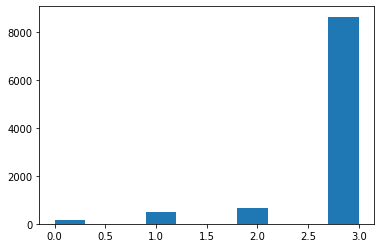

In [19]:
#theta = [1.6562490592806174,0.5373936509144944,1.906132739269382,1.2818890236244702,0.3456810487466709]
theta = [1.0302559248630594,0.4293928817650971,0.9866247451779903,1.2818890236244702,0.3456810487466709]
data = ssms.basic_simulators.simulator(theta=np.tile(theta,(10,1)),model='ddm_par2_no_bias',n_samples=1000)
plt.hist(data['choices'].flatten())

# Plots

## Chong Data

In [ ]:
fig = plt.figure(figsize=(25,30))
color = ['blue','red', 'black', 'green']
for i in range(1,len(cond_keys)+1):
  for j in range(4):
    plt.subplot(4,4,i*2,xlim=(0,10),ylim=(0,0.8))
    plt.hist(mic2_out[cond_keys[i-1]][0][mic2_out[cond_keys[i-1]][1] == j],
            density=False,
            histtype = 'step',
            color = color[j],
            range=(0,10),
            bins=20, #20
            weights=np.ones(mic2_out[cond_keys[i-1]][0][mic2_out[cond_keys[i-1]][1] == j].shape[0])/5000)
    plt.title('mic2 {}'.format(cond_keys[i-1]))
#for i in range(1,9):
    plt.subplot(4,4,i*2 - 1,xlim=(0,10),ylim=(0,0.8))
    plt.hist(chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'][chong_data[chong_data['cond']==cond_keys[i-1]]['response'] == j],
            density=False,
            histtype='step',
            color = color[j],
            range=(0,10),
            bins=20, #20
            weights=np.ones(chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'][chong_data[chong_data['cond']==cond_keys[i-1]]['response'] == j].shape[0])*2/chong_data[chong_data['cond'] == cond_keys[i-1]]['rt'].shape[0])
    plt.title('real {}'.format(cond_keys[i-1]))

NameError: ignored

<Figure size 1800x2160 with 0 Axes>

In [ ]:
bins = np.array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5 ])
chong_high_err = []
chong_low_err = []
for i in bins:
  err_high = np.sum((chong_data[chong_data.response<2]['rt'][chong_data[chong_data.response<2]['rt']<(i+0.5)])>=i)
  total = np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((chong_data[(chong_data.response==0) | (chong_data.response==2)]['rt'][chong_data[(chong_data.response==0) | (chong_data.response==2)]['rt']<(i+0.5)])>=i)
  chong_high_err.append(err_high/total)
  chong_low_err.append(err_low/total)

(array([ 17., 548., 669., 460., 311., 266., 164.,  94.,  67.,  70.,  53.,
         37.,  31.,  22.,  21.,  14.,   9.,   9.,   9.,   8.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 [<matplotlib.patches.Polygon at 0x2c11b83a0>])

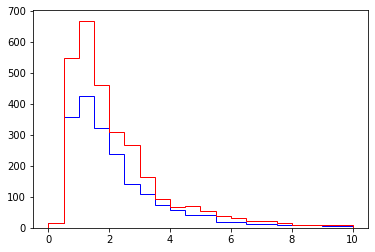

In [ ]:
plt.hist(chong_data[chong_data.response<2]['rt'],
            density=False,
            histtype='step',
            color = 'blue',
            range=(0,10),
            bins=20)
plt.hist(chong_data[(chong_data.response==0) | (chong_data.response==2)]['rt'],
            density=False,
            histtype='step',
            color = 'red',
            range=(0,10),
            bins=20)

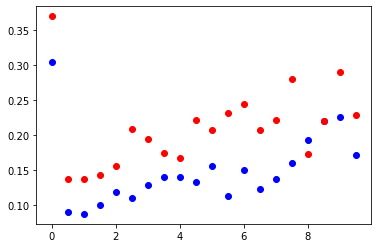

In [ ]:
plt.plot(np.arange(0, 10, step=0.5),chong_high_err,'bo')
plt.plot(np.arange(0, 10, step=0.5),chong_low_err,'ro')

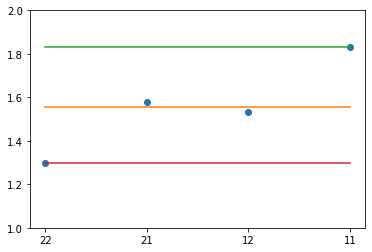

In [ ]:
chong_mean_rt = []
coh_conds = ['22','21','12','11']
top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_mean_rt.append(np.median(chong_data.rt[chong_data.cond2==i]))
plt.ylim((1,2))
plt.plot(coh_conds,chong_mean_rt,'o')
plt.plot(coh_conds,[middle_line,middle_line,middle_line,middle_line])
plt.plot(coh_conds,[top_line,top_line,top_line,top_line])
plt.plot(coh_conds,[bottom_line,bottom_line,bottom_line,bottom_line])

In [ ]:
# Plot individuals

In [ ]:
chong_group_data = []
for i in np.unique(chong_data['subj']):
  chong_group_data.append(chong_data[chong_data['subj']==i])

In [ ]:
chong_group_high_err = []
chong_group_low_err = []
for j in range(36):
  chong_high_err = []
  chong_low_err = []
  for i in bins:
    err_high = np.sum((chong_group_data[j][chong_group_data[j].response<2]['rt'][chong_group_data[j][chong_group_data[j].response<2]['rt']<(i+0.5)])>=i)
    total = np.sum((chong_group_data[j]['rt'][chong_group_data[j]['rt']<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((chong_group_data[j][(chong_group_data[j].response==0) | (chong_group_data[j].response==2)]['rt'][chong_group_data[j][(chong_group_data[j].response==0) | (chong_group_data[j].response==2)]['rt']<(i+0.5)])>=i)
    chong_high_err.append(err_high/total)
    chong_low_err.append(err_low/total)
  chong_group_high_err.append(chong_high_err)
  chong_group_low_err.append(chong_low_err)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/1052672327.py:11: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/1052672327.py:12: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


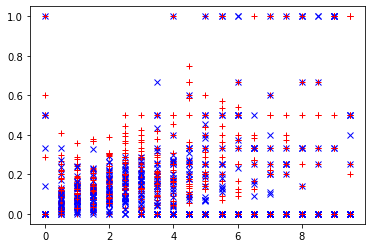

In [ ]:
for i in range(36):
  plt.plot(np.arange(0, 10, step=0.5),chong_group_high_err[i],'bx')
  plt.plot(np.arange(0, 10, step=0.5),chong_group_low_err[i],'r+')

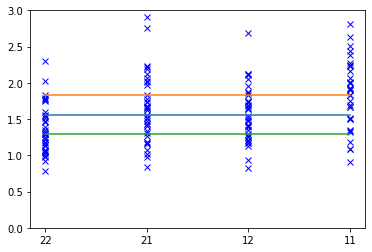

In [ ]:
chong_mean_rt = []
coh_conds = ['22','21','12','11']
#top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
#bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
#middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_mean_rt.append(np.median(chong_data.rt[chong_data.cond2==i]))
top_line = [chong_mean_rt[3],chong_mean_rt[3],chong_mean_rt[3],chong_mean_rt[3]]
bottom_line = [chong_mean_rt[0],chong_mean_rt[0],chong_mean_rt[0],chong_mean_rt[0]]
mid_mean = np.mean([chong_mean_rt[1],chong_mean_rt[2]])
middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
plt.ylim((0,3))
for j in range(36):
  chong_mean_rt = []
  for i in coh_conds:
    chong_mean_rt.append(np.median(chong_group_data[j].rt[chong_group_data[j].cond2==i]))
  plt.plot(coh_conds,chong_mean_rt,'bx')
plt.plot(coh_conds,middle_line)
plt.plot(coh_conds,top_line)
plt.plot(coh_conds,bottom_line)

In [ ]:
# Plot Conditions

In [ ]:
chong_cond_data = []
for i in np.unique(chong_data['stim']):
  chong_cond_data.append(chong_data[chong_data['stim']==i])

In [ ]:
chong_cond_high_err = []
chong_cond_low_err = []
for j in range(6):
  chong_high_err = []
  chong_low_err = []
  for i in bins:
    err_high = np.sum((chong_cond_data[j][chong_cond_data[j].response<2]['rt'][chong_cond_data[j][chong_cond_data[j].response<2]['rt']<(i+0.5)])>=i)
    total = np.sum((chong_cond_data[j]['rt'][chong_cond_data[j]['rt']<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((chong_cond_data[j][(chong_cond_data[j].response==0) | (chong_cond_data[j].response==2)]['rt'][chong_cond_data[j][(chong_cond_data[j].response==0) | (chong_cond_data[j].response==2)]['rt']<(i+0.5)])>=i)
    chong_high_err.append(err_high/total)
    chong_low_err.append(err_low/total)
  chong_cond_high_err.append(chong_high_err)
  chong_cond_low_err.append(chong_low_err)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/2652163328.py:11: RuntimeWarning: invalid value encountered in long_scalars
  chong_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/2652163328.py:12: RuntimeWarning: invalid value encountered in long_scalars
  chong_low_err.append(err_low/total)


1 is lineDir

2 is colorPer

3 is anglePer/angleOption



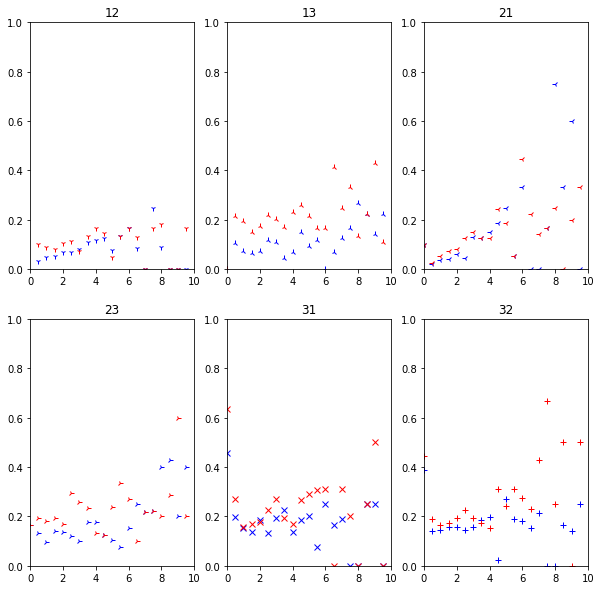

In [ ]:
shapes = [1,2,3,4,'x','+']
keys = np.array(['12', '13', '21', '23', '31', '32'])
plt.figure(figsize=(10,10))
for i in range(6):
  plt.subplot(2,3,i+1,xlim=(0,10),ylim=(0,1))
  plt.plot(np.arange(0, 10, step=0.5),chong_cond_high_err[i],'b{}'.format(shapes[i]))
  plt.plot(np.arange(0, 10, step=0.5),chong_cond_low_err[i],'r{}'.format(shapes[i]))
  plt.title('{}'.format(keys[i]))

use violine plots

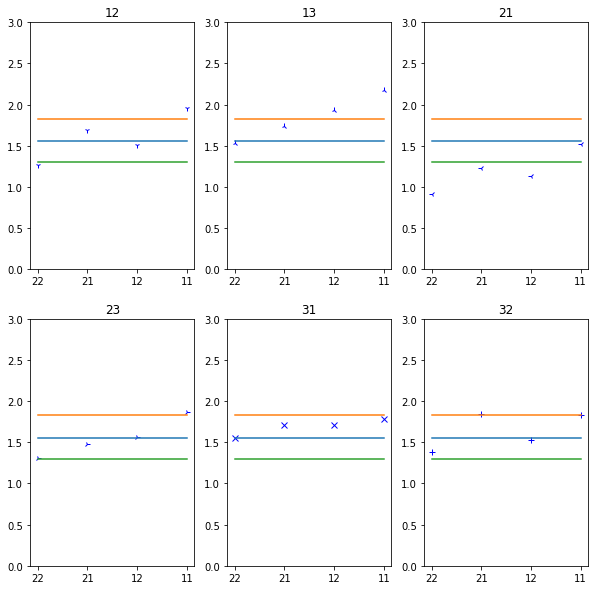

In [ ]:
chong_mean_rt = []
coh_conds = ['22','21','12','11']
#top_line = np.median(chong_data.rt[chong_data.cond2=='11'])
#bottom_line = np.median(chong_data.rt[chong_data.cond2=='22'])
#middle_line = np.mean([np.median(chong_data.rt[chong_data.cond2=='21']),np.median(chong_data.rt[chong_data.cond2=='12'])])
for i in coh_conds:
  chong_mean_rt.append(np.median(chong_data.rt[chong_data.cond2==i]))
top_line = [chong_mean_rt[3],chong_mean_rt[3],chong_mean_rt[3],chong_mean_rt[3]]
bottom_line = [chong_mean_rt[0],chong_mean_rt[0],chong_mean_rt[0],chong_mean_rt[0]]
mid_mean = np.mean([chong_mean_rt[1],chong_mean_rt[2]])
middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
#plt.ylim((0.5,2.5))
shapes = [1,2,3,4,'x','+']
keys = np.array(['12', '13', '21', '23', '31', '32'])
plt.figure(figsize=(10,10))
for j in range(6):
  chong_mean_rt = []
  for i in coh_conds:
    chong_mean_rt.append(np.median(chong_cond_data[j].rt[chong_cond_data[j].cond2==i]))
  plt.subplot(2,3,j+1,ylim=(0,3))
  plt.plot(coh_conds,chong_mean_rt,'b{}'.format(shapes[j]))
  plt.plot(coh_conds,middle_line)
  plt.plot(coh_conds,top_line)
  plt.plot(coh_conds,bottom_line)
  plt.title('{}'.format(keys[j]))

## Par2 Data

In [ ]:
par2_data = hddm.load('data/tsumme/hddm_out/ddm_par2_chong.db')

In [ ]:
par2_keys = [i for i in par2_data.keys()][1:-1]
par2_keys.sort()
par2_keys = par2_keys[2:]+par2_keys[0:2]
par2_data = pd.DataFrame(par2_data)
par2_data = np.stack(par2_data[par2_keys].to_numpy()[0,:])
par2_data = pd.DataFrame(data=par2_data.T,columns=par2_keys)
static = ['zh','zl1','zl2']
par2_data[static] = 0.5
par2_keys = par2_keys[0:-1] + static + [par2_keys[-1]]
par2_data = par2_data[par2_keys]

In [ ]:
par2_out = {}
np.random.seed(2)
thetas = par2_data.sample(n=10000,replace=True)
for i in [1,2]:
  for j in [1,2]:
    for k in [1,2]:
      theta_list = ['vh({})'.format(i),'vl1({})'.format(j),'vl2({})'.format(k),'a','zh','zl1','zl2','t']
      par2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]

In [ ]:
par2_choice = []
par2_rt = []
for key in par2_out.keys():
  par2_rt.append(par2_out[key][0])
  par2_choice.append(par2_out[key][1])
par2_choice = np.concatenate(par2_choice)
par2_rt = np.concatenate(par2_rt)

In [ ]:
par2_high_err = []
par2_low_err = []
for i in bins:
  err_high = np.sum((par2_rt[par2_choice<2][par2_rt[par2_choice<2]<(i+0.5)])>=i)
  total = np.sum((par2_rt[par2_rt<(i+0.5)])>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((par2_rt[(par2_choice==0) | (par2_choice==2)][par2_rt[(par2_choice==0) | (par2_choice==2)]<(i+0.5)])>=i)
  par2_high_err.append(err_high/total)
  par2_low_err.append(err_low/total)

(array([  59., 1368., 1882., 1346.,  807.,  490.,  303.,  195.,  114.,
          88.,   60.,   33.,   20.,   20.,   15.,    7.,    4.,    2.,
           2.,    2.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ],
       dtype=float32),
 [<matplotlib.patches.Polygon at 0x2c4bf92e0>])

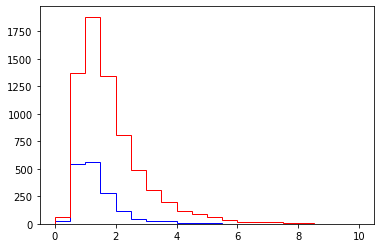

In [ ]:
plt.hist(par2_rt[par2_choice<2],
            density=False,
            histtype='step',
            color = 'blue',
            range=(0,10),
            bins=20)
plt.hist(par2_rt[(par2_choice==0) | (par2_choice==2)],
            density=False,
            histtype='step',
            color = 'red',
            range=(0,10),
            bins=20)

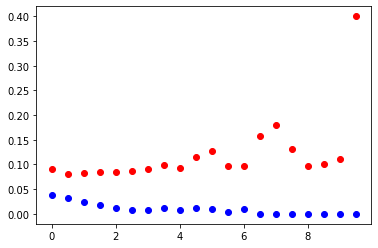

In [ ]:
plt.plot(np.arange(0, 10, step=0.5),par2_high_err,'bo')
plt.plot(np.arange(0, 10, step=0.5),par2_low_err,'ro')

In [ ]:
par2_mean_rt = []
for i in [1,2]:
  for j in [1,2]:
    par2_mean_rt.append(np.mean(np.concatenate([par2_out['{}1{}'.format(i,j)][0],par2_out['{}1{}'.format(i,j)][0]])))

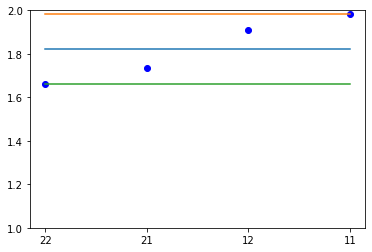

In [ ]:
coh_conds = ['22','21','12','11']
par2_mean_rt = []
for i in [2,1]:
  for j in [2,1]:
    par2_mean_rt.append(np.mean(np.concatenate([par2_out['{}1{}'.format(i,j)][0],par2_out['{}2{}'.format(i,j)][0]])))
plt.plot(coh_conds,par2_mean_rt,'bo')
top_line = [par2_mean_rt[3],par2_mean_rt[3],par2_mean_rt[3],par2_mean_rt[3]]
bottom_line = [par2_mean_rt[0],par2_mean_rt[0],par2_mean_rt[0],par2_mean_rt[0]]
mid_mean = np.mean([par2_mean_rt[1],par2_mean_rt[2]])
middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
plt.ylim((1,2))
plt.plot(coh_conds,middle_line)
plt.plot(coh_conds,top_line)
plt.plot(coh_conds,bottom_line)

### Plot individuals

In [ ]:
# Plot individuals

In [ ]:
par2_data, par2_all_choice, par2_all_rt, par2_all_out = model_preprocess('ddm_par2_chong_group_True')

In [ ]:
par2_group_out = []
np.random.seed(2)
thetas = par2_data.sample(n=10000,replace=True)
for l in range(37):
  par2_out = {}
  for i in [1,2]:
    for j in [1,2]:
      for k in [1,2]:
        theta_list = ['vh_subj({}).{}'.format(i,l),'vl1_subj({}).{}'.format(j,l),'vl2_subj({}).{}'.format(k,l),'a_subj.{}'.format(l),'zh','zl1','zl2','t_subj.{}'.format(l)]
        par2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]
  par2_group_out.append(par2_out)

In [ ]:
par2_group_choice = []
par2_group_rt = []
for j in range(37):
  par2_choice = []
  par2_rt = []
  for key in par2_out.keys():
    par2_rt.append(par2_group_out[j][key][0])
    par2_choice.append(par2_group_out[j][key][1])
  par2_choice = np.concatenate(par2_choice)
  par2_rt = np.concatenate(par2_rt)
  par2_group_choice.append(par2_choice)
  par2_group_rt.append(par2_rt)

In [ ]:
par2_group_high_err = []
par2_group_low_err = []
for j in range(37):
  par2_high_err = []
  par2_low_err = []
  for i in bins:
    err_high = np.sum((par2_group_rt[j][par2_group_choice[j]<2][par2_group_rt[j][par2_group_choice[j]<2]<(i+0.5)])>=i)
    total = np.sum((par2_group_rt[j][par2_group_rt[j]<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((par2_group_rt[j][(par2_group_choice[j]==0) | (par2_group_choice[j]==2)][par2_group_rt[j][(par2_group_choice[j]==0) | (par2_group_choice[j]==2)]<(i+0.5)])>=i)
    par2_high_err.append(err_high/total)
    par2_low_err.append(err_low/total)
  par2_group_high_err.append(par2_high_err)
  par2_group_low_err.append(par2_low_err)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/2913457753.py:11: RuntimeWarning: invalid value encountered in long_scalars
  par2_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/2913457753.py:12: RuntimeWarning: invalid value encountered in long_scalars
  par2_low_err.append(err_low/total)


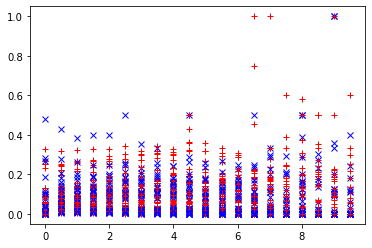

In [ ]:
for i in range(37):
  plt.plot(np.arange(0, 10, step=0.5),par2_group_high_err[i],'bx')
  plt.plot(np.arange(0, 10, step=0.5),par2_group_low_err[i],'r+')

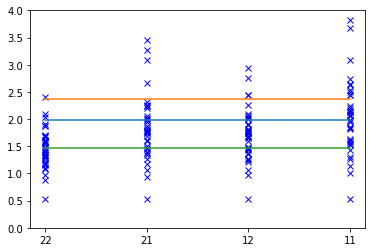

In [ ]:
coh_conds = ['22','21','12','11']
for k in range(37):
  par2_mean_rt = []
  for i in [2,1]:
    for j in [2,1]:
      par2_mean_rt.append(np.mean(np.concatenate([par2_group_out[k]['{}1{}'.format(i,j)][0],par2_group_out[k]['{}2{}'.format(i,j)][0]])))
  plt.plot(coh_conds,par2_mean_rt,'bx')
par2_mean_rt = []
for i in [2,1]:
  for j in [2,1]:
    par2_mean_rt.append(np.mean(np.concatenate([par2_all_out['{}1{}'.format(i,j)][0],par2_all_out['{}2{}'.format(i,j)][0]])))
top_line = [par2_mean_rt[3],par2_mean_rt[3],par2_mean_rt[3],par2_mean_rt[3]]
bottom_line = [par2_mean_rt[0],par2_mean_rt[0],par2_mean_rt[0],par2_mean_rt[0]]
mid_mean = np.mean([par2_mean_rt[1],par2_mean_rt[2]])
middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
plt.ylim((0,4))
plt.plot(coh_conds,middle_line)
plt.plot(coh_conds,top_line)
plt.plot(coh_conds,bottom_line)

### Plot Conditions

In [ ]:
# Plot Conditions

In [ ]:
par2_data = hddm.load('data/tsumme/hddm_out/ddm_par2_chong_cond_group_False.db')

In [ ]:
par2_keys = [i for i in par2_data.keys()][1:-1]
par2_keys.sort()
par2_keys = par2_keys[2:]+par2_keys[0:2]
par2_data = pd.DataFrame(par2_data)
par2_data = np.stack(par2_data[par2_keys].to_numpy()[0,:])
par2_data = pd.DataFrame(data=par2_data.T,columns=par2_keys)
static = ['zh','zl1','zl2']
par2_data[static] = 0.5
par2_keys = par2_keys[0:-1] + static + [par2_keys[-1]]
par2_data = par2_data[par2_keys]

In [ ]:
import itertools

par2_cond_out = []
np.random.seed(2)
thetas = par2_data.sample(n=10000,replace=True)
for n,l,m in list(itertools.permutations([1,2,3])):
  par2_out = {}
  for i in [1,2]:
    for j in [1,2]:
      for k in [1,2]:
        theta_list = ['vh({}.{})'.format(n,i),'vl1({}.{})'.format(l,j),'vl2({}.{})'.format(m,k),'a','zh','zl1','zl2','t']
        par2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_par2',n_samples=1)[0:2]
  par2_cond_out.append(par2_out)

In [ ]:
par2_cond_choice = []
par2_cond_rt = []
for j in range(6):
  par2_choice = []
  par2_rt = []
  for key in par2_out.keys():
    par2_rt.append(par2_cond_out[j][key][0])
    par2_choice.append(par2_cond_out[j][key][1])
  par2_choice = np.concatenate(par2_choice)
  par2_rt = np.concatenate(par2_rt)
  par2_cond_choice.append(par2_choice)
  par2_cond_rt.append(par2_rt)

In [ ]:
par2_cond_high_err = []
par2_cond_low_err = []
for j in range(6):
  par2_high_err = []
  par2_low_err = []
  for i in bins:
    err_high = np.sum((par2_cond_rt[j][par2_cond_choice[j]<2][par2_cond_rt[j][par2_cond_choice[j]<2]<(i+0.5)])>=i)
    total = np.sum((par2_cond_rt[j][par2_cond_rt[j]<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((par2_cond_rt[j][(par2_cond_choice[j]==0) | (par2_cond_choice[j]==2)][par2_cond_rt[j][(par2_cond_choice[j]==0) | (par2_cond_choice[j]==2)]<(i+0.5)])>=i)
    par2_high_err.append(err_high/total)
    par2_low_err.append(err_low/total)
  par2_cond_high_err.append(par2_high_err)
  par2_cond_low_err.append(par2_low_err)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/885732565.py:11: RuntimeWarning: invalid value encountered in long_scalars
  par2_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/885732565.py:12: RuntimeWarning: invalid value encountered in long_scalars
  par2_low_err.append(err_low/total)


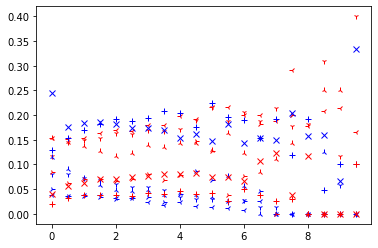

In [ ]:
shapes = [1,2,3,4,'x','+']
for i in range(6):
  plt.plot(np.arange(0, 10, step=0.5),par2_cond_high_err[i],'b{}'.format(shapes[i]))
  plt.plot(np.arange(0, 10, step=0.5),par2_cond_low_err[i],'r{}'.format(shapes[i]))

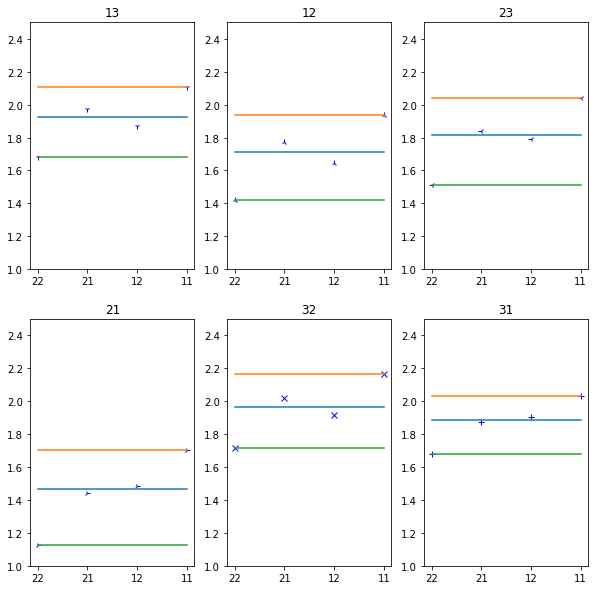

In [ ]:
shapes = [1,2,3,4,'x','+']
coh_conds = ['22','21','12','11']
par2_cond_mean_rt = []
keys = ['13','12','23','21','32','31']
plt.figure(figsize=(10,10))
for k in range(6):
  par2_mean_rt = []
  for i in [2,1]:
    for j in [2,1]:
      par2_mean_rt.append(np.mean(np.concatenate([par2_cond_out[k]['{}1{}'.format(i,j)][0],par2_cond_out[k]['{}2{}'.format(i,j)][0]])))
  plt.subplot(2,3,k+1,ylim=(0,3))
  plt.plot(coh_conds,par2_mean_rt,'b{}'.format(shapes[k]))
  plt.title('{}'.format(keys[k]))
  par2_cond_mean_rt.append(par2_mean_rt)
  top_line = [par2_mean_rt[3],par2_mean_rt[3],par2_mean_rt[3],par2_mean_rt[3]]
  bottom_line = [par2_mean_rt[0],par2_mean_rt[0],par2_mean_rt[0],par2_mean_rt[0]]
  mid_mean = np.mean([par2_mean_rt[1],par2_mean_rt[2]])
  middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
  plt.ylim((1,2.5))
  plt.plot(coh_conds,middle_line)
  plt.plot(coh_conds,top_line)
  plt.plot(coh_conds,bottom_line)

par2_mean_rt = np.mean(par2_cond_mean_rt,axis=1)
#par2_mean_rt = []
#for i in [2,1]:
#  for j in [2,1]:
#    par2_mean_rt.append(np.mean(np.concatenate([par2_all_out['{}1{}'.format(i,j)][0],par2_all_out['{}2{}'.format(i,j)][0]])))
top_line = [par2_mean_rt[3],par2_mean_rt[3],par2_mean_rt[3],par2_mean_rt[3]]
bottom_line = [par2_mean_rt[0],par2_mean_rt[0],par2_mean_rt[0],par2_mean_rt[0]]
mid_mean = np.mean([par2_mean_rt[1],par2_mean_rt[2]])
middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
#plt.ylim((1,2.5))
#plt.plot(coh_conds,middle_line)
#plt.plot(coh_conds,top_line)
#plt.plot(coh_conds,bottom_line)

## Seq2

In [ ]:
seq2_data = hddm.load('data/tsumme/hddm_out/ddm_seq2_chong.db')

In [ ]:
seq2_keys = [i for i in seq2_data.keys()][1:-1]
seq2_keys.sort()
seq2_keys = seq2_keys[2:]+seq2_keys[0:2]
seq2_data = pd.DataFrame(seq2_data)
seq2_data = np.stack(seq2_data[seq2_keys].to_numpy()[0,:])
seq2_data = pd.DataFrame(data=seq2_data.T,columns=seq2_keys)
static = ['zh','zl1','zl2']
seq2_data[static] = 0.5
seq2_keys = seq2_keys[0:-1] + static + [seq2_keys[-1]]
seq2_data = seq2_data[seq2_keys]

In [ ]:
seq2_out = {}
np.random.seed(2)
thetas = seq2_data.sample(n=10000,replace=True)
for i in [1,2]:
  for j in [1,2]:
    for k in [1,2]:
      theta_list = ['vh({})'.format(i),'vl1({})'.format(j),'vl2({})'.format(k),'a','zh','zl1','zl2','t']
      seq2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_seq2',n_samples=1)[0:2]

In [ ]:
seq2_choice = []
seq2_rt = []
for key in seq2_out.keys():
  seq2_rt.append(seq2_out[key][0])
  seq2_choice.append(seq2_out[key][1])
seq2_choice = np.concatenate(seq2_choice)
seq2_rt = np.concatenate(seq2_rt)

In [ ]:
seq2_high_err = []
seq2_low_err = []
for i in bins:
  err_high = np.sum((seq2_rt[seq2_choice<2][seq2_rt[seq2_choice<2]<(i+0.5)])>=i)
  total = np.sum(seq2_rt[seq2_rt<(i+0.5)]>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((seq2_rt[(seq2_choice==0) | (seq2_choice==2)][seq2_rt[(seq2_choice==0) | (seq2_choice==2)]<(i+0.5)])>=i)
  seq2_high_err.append(err_high/total)
  seq2_low_err.append(err_low/total)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/162335474.py:8: RuntimeWarning: invalid value encountered in long_scalars
  seq2_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/162335474.py:9: RuntimeWarning: invalid value encountered in long_scalars
  seq2_low_err.append(err_low/total)


(array([5.400e+01, 1.857e+03, 2.726e+03, 2.216e+03, 1.426e+03, 7.690e+02,
        4.520e+02, 2.630e+02, 1.560e+02, 9.300e+01, 4.100e+01, 1.900e+01,
        1.100e+01, 9.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ],
       dtype=float32),
 [<matplotlib.patches.Polygon at 0x2bbb1c4f0>])

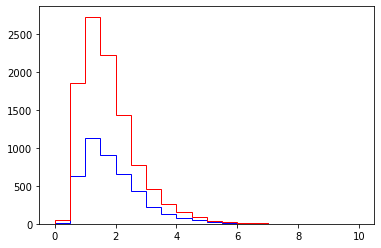

In [ ]:
plt.hist(seq2_rt[seq2_choice<2],
            density=False,
            histtype='step',
            color = 'blue',
            range=(0,10),
            bins=20)
plt.hist(seq2_rt[(seq2_choice==0) | (seq2_choice==2)],
            density=False,
            histtype='step',
            color = 'red',
            range=(0,10),
            bins=20)

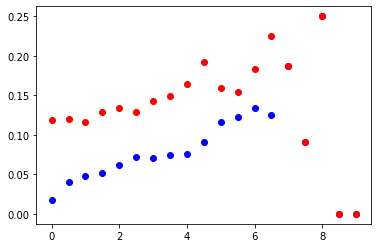

In [ ]:
plt.plot(np.arange(0, 10, step=0.5),seq2_high_err,'bo')
plt.plot(np.arange(0, 10, step=0.5),seq2_low_err,'ro')

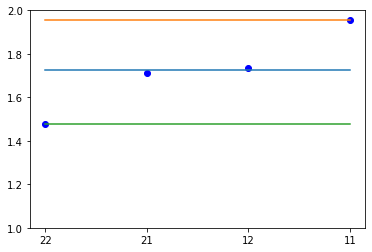

In [ ]:
coh_conds = ['22','21','12','11']
seq2_mean_rt = []
for i in [2,1]:
  for j in [2,1]:
    seq2_mean_rt.append(np.mean(np.concatenate([seq2_out['{}1{}'.format(i,j)][0],seq2_out['{}2{}'.format(i,j)][0]])))
plt.plot(coh_conds,seq2_mean_rt,'bo')
top_line = [seq2_mean_rt[3],seq2_mean_rt[3],seq2_mean_rt[3],seq2_mean_rt[3]]
bottom_line = [seq2_mean_rt[0],seq2_mean_rt[0],seq2_mean_rt[0],seq2_mean_rt[0]]
mid_mean = np.mean([seq2_mean_rt[1],seq2_mean_rt[2]])
middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
plt.ylim((1,2))
plt.plot(coh_conds,middle_line)
plt.plot(coh_conds,top_line)
plt.plot(coh_conds,bottom_line)

### Plot individuals

In [ ]:
# Plot individuals

In [ ]:
seq2_data, seq2_all_choice, seq2_all_rt, seq2_all_out = model_preprocess('ddm_seq2_chong_group_True')

In [ ]:
seq2_group_out = []
np.random.seed(2)
thetas = seq2_data.sample(n=10000,replace=True)
for l in range(37):
  seq2_out = {}
  for i in [1,2]:
    for j in [1,2]:
      for k in [1,2]:
        theta_list = ['vh_subj({}).{}'.format(i,l),'vl1_subj({}).{}'.format(j,l),'vl2_subj({}).{}'.format(k,l),'a_subj.{}'.format(l),'zh','zl1','zl2','t_subj.{}'.format(l)]
        seq2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_seq2',n_samples=1)[0:2]
  seq2_group_out.append(seq2_out)

In [ ]:
seq2_group_choice = []
seq2_group_rt = []
for j in range(37):
  seq2_choice = []
  seq2_rt = []
  for key in seq2_out.keys():
    seq2_rt.append(seq2_group_out[j][key][0])
    seq2_choice.append(seq2_group_out[j][key][1])
  seq2_choice = np.concatenate(seq2_choice)
  seq2_rt = np.concatenate(seq2_rt)
  seq2_group_choice.append(seq2_choice)
  seq2_group_rt.append(seq2_rt)

In [ ]:
seq2_group_high_err = []
seq2_group_low_err = []
for j in range(37):
  seq2_high_err = []
  seq2_low_err = []
  for i in bins:
    err_high = np.sum((seq2_group_rt[j][seq2_group_choice[j]<2][seq2_group_rt[j][seq2_group_choice[j]<2]<(i+0.5)])>=i)
    total = np.sum((seq2_group_rt[j][seq2_group_rt[j]<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((seq2_group_rt[j][(seq2_group_choice[j]==0) | (seq2_group_choice[j]==2)][seq2_group_rt[j][(seq2_group_choice[j]==0) | (seq2_group_choice[j]==2)]<(i+0.5)])>=i)
    seq2_high_err.append(err_high/total)
    seq2_low_err.append(err_low/total)
  seq2_group_high_err.append(seq2_high_err)
  seq2_group_low_err.append(seq2_low_err)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/2601671016.py:11: RuntimeWarning: invalid value encountered in long_scalars
  seq2_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/2601671016.py:12: RuntimeWarning: invalid value encountered in long_scalars
  seq2_low_err.append(err_low/total)


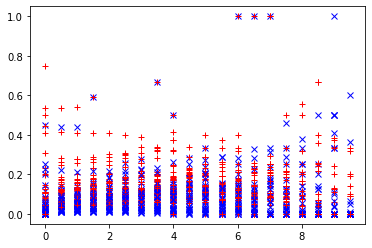

In [ ]:
for i in range(37):
  plt.plot(np.arange(0, 10, step=0.5),seq2_group_high_err[i],'bx')
  plt.plot(np.arange(0, 10, step=0.5),seq2_group_low_err[i],'r+')

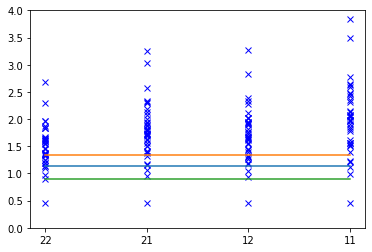

In [ ]:
coh_conds = ['22','21','12','11']
for k in range(37):
  seq2_mean_rt = []
  for i in [2,1]:
    for j in [2,1]:
      seq2_mean_rt.append(np.mean(np.concatenate([seq2_group_out[k]['{}1{}'.format(i,j)][0],seq2_group_out[k]['{}2{}'.format(i,j)][0]])))
  plt.plot(coh_conds,seq2_mean_rt,'bx')
seq2_mean_rt = []
for i in [2,1]:
  for j in [2,1]:
    seq2_mean_rt.append(np.mean(np.concatenate([seq2_all_out['{}1{}'.format(i,j)][0],seq2_all_out['{}2{}'.format(i,j)][0]])))
top_line = [seq2_mean_rt[3],seq2_mean_rt[3],seq2_mean_rt[3],seq2_mean_rt[3]]
bottom_line = [seq2_mean_rt[0],seq2_mean_rt[0],seq2_mean_rt[0],seq2_mean_rt[0]]
mid_mean = np.mean([seq2_mean_rt[1],seq2_mean_rt[2]])
middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
plt.ylim((0,4))
plt.plot(coh_conds,middle_line)
plt.plot(coh_conds,top_line)
plt.plot(coh_conds,bottom_line)

### Plot Conditions

In [ ]:
# Plot Conditions

In [ ]:
seq2_data = hddm.load('data/tsumme/hddm_out/ddm_seq2_chong_cond_group_False.db')

In [ ]:
seq2_keys = [i for i in seq2_data.keys()][1:-1]
seq2_keys.sort()
seq2_keys = seq2_keys[2:]+seq2_keys[0:2]
seq2_data = pd.DataFrame(seq2_data)
seq2_data = np.stack(seq2_data[seq2_keys].to_numpy()[0,:])
seq2_data = pd.DataFrame(data=seq2_data.T,columns=seq2_keys)
static = ['zh','zl1','zl2']
seq2_data[static] = 0.5
seq2_keys = seq2_keys[0:-1] + static + [seq2_keys[-1]]
seq2_data = seq2_data[seq2_keys]

In [ ]:
import itertools

seq2_cond_out = []
np.random.seed(2)
thetas = seq2_data.sample(n=10000,replace=True)
for n,l,m in list(itertools.permutations([1,2,3])):
  seq2_out = {}
  for i in [1,2]:
    for j in [1,2]:
      for k in [1,2]:
        theta_list = ['vh({}.{})'.format(n,i),'vl1({}.{})'.format(l,j),'vl2({}.{})'.format(m,k),'a','zh','zl1','zl2','t']
        seq2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_seq2',n_samples=1)[0:2]
  seq2_cond_out.append(seq2_out)

In [ ]:
seq2_cond_choice = []
seq2_cond_rt = []
for j in range(6):
  seq2_choice = []
  seq2_rt = []
  for key in seq2_out.keys():
    seq2_rt.append(seq2_cond_out[j][key][0])
    seq2_choice.append(seq2_cond_out[j][key][1])
  seq2_choice = np.concatenate(seq2_choice)
  seq2_rt = np.concatenate(seq2_rt)
  seq2_cond_choice.append(seq2_choice)
  seq2_cond_rt.append(seq2_rt)

In [ ]:
seq2_cond_high_err = []
seq2_cond_low_err = []
for j in range(6):
  seq2_high_err = []
  seq2_low_err = []
  for i in bins:
    err_high = np.sum((seq2_cond_rt[j][seq2_cond_choice[j]<2][seq2_cond_rt[j][seq2_cond_choice[j]<2]<(i+0.5)])>=i)
    total = np.sum((seq2_cond_rt[j][seq2_cond_rt[j]<(i+0.5)])>=i)
    #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
    err_low = np.sum((seq2_cond_rt[j][(seq2_cond_choice[j]==0) | (seq2_cond_choice[j]==2)][seq2_cond_rt[j][(seq2_cond_choice[j]==0) | (seq2_cond_choice[j]==2)]<(i+0.5)])>=i)
    seq2_high_err.append(err_high/total)
    seq2_low_err.append(err_low/total)
  seq2_cond_high_err.append(seq2_high_err)
  seq2_cond_low_err.append(seq2_low_err)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/1662612790.py:11: RuntimeWarning: invalid value encountered in long_scalars
  seq2_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/1662612790.py:12: RuntimeWarning: invalid value encountered in long_scalars
  seq2_low_err.append(err_low/total)


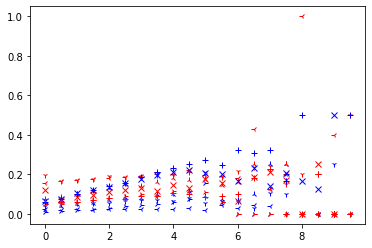

In [ ]:
shapes = [1,2,3,4,'x','+']
for i in range(6):
  plt.plot(np.arange(0, 10, step=0.5),seq2_cond_high_err[i],'b{}'.format(shapes[i]))
  plt.plot(np.arange(0, 10, step=0.5),seq2_cond_low_err[i],'r{}'.format(shapes[i]))

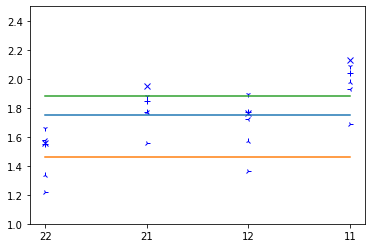

In [ ]:
shapes = [1,2,3,4,'x','+']
coh_conds = ['22','21','12','11']
seq2_cond_mean_rt = []
for k in range(6):
  seq2_mean_rt = []
  for i in [2,1]:
    for j in [2,1]:
      seq2_mean_rt.append(np.mean(np.concatenate([seq2_cond_out[k]['{}1{}'.format(i,j)][0],seq2_cond_out[k]['{}2{}'.format(i,j)][0]])))
  plt.plot(coh_conds,seq2_mean_rt,'b{}'.format(shapes[k]))
  seq2_cond_mean_rt.append(seq2_mean_rt)
seq2_mean_rt = np.mean(seq2_cond_mean_rt,axis=1)
#par2_mean_rt = []
#for i in [2,1]:
#  for j in [2,1]:
#    par2_mean_rt.append(np.mean(np.concatenate([par2_all_out['{}1{}'.format(i,j)][0],par2_all_out['{}2{}'.format(i,j)][0]])))
top_line = [seq2_mean_rt[3],seq2_mean_rt[3],seq2_mean_rt[3],seq2_mean_rt[3]]
bottom_line = [seq2_mean_rt[0],seq2_mean_rt[0],seq2_mean_rt[0],seq2_mean_rt[0]]
mid_mean = np.mean([par2_mean_rt[1],par2_mean_rt[2]])
middle_line = [mid_mean,mid_mean,mid_mean,mid_mean]
plt.ylim((1,2.5))
plt.plot(coh_conds,middle_line)
plt.plot(coh_conds,top_line)
plt.plot(coh_conds,bottom_line)

## Mic2

In [ ]:
mic2_data = hddm.load('data/tsumme/hddm_out/ddm_mic2_chong.db')

In [ ]:
mic2_keys = [i for i in mic2_data.keys()][1:-1]
mic2_keys.sort()
mic2_keys = mic2_keys[2:]+mic2_keys[0:2]
mic2_data = pd.DataFrame(mic2_data)
mic2_data = np.stack(mic2_data[mic2_keys].to_numpy()[0,:])
mic2_data = pd.DataFrame(data=mic2_data.T,columns=mic2_keys)
static = ['zh','zl1','zl2']
mic2_data[static] = 0.5
mic2_keys = mic2_keys[0:-1] + static + [mic2_keys[-1]]
mic2_data = mic2_data[mic2_keys]

In [ ]:
mic2_out = {}
np.random.seed(2)
thetas = mic2_data.sample(n=10000,replace=True)
for i in [1,2]:
  for j in [1,2]:
    for k in [1,2]:
      theta_list = ['vh({})'.format(i),'vh({})'.format(j),'vh({})'.format(k),'a','zh','zl1','zl2','d','t']
      mic2_out['{}{}{}'.format(i,j,k)] = hddm.simulators.basic_simulator.simulator(theta=thetas[theta_list].to_numpy(), model='ddm_mic2',n_samples=1)[0:2]

In [ ]:
mic2_choice = []
mic2_rt = []
for key in mic2_out.keys():
  mic2_rt.append(mic2_out[key][0])
  mic2_choice.append(mic2_out[key][1])
mic2_choice = np.concatenate(mic2_choice)
mic2_rt = np.concatenate(mic2_rt)

In [ ]:
mic2_high_err = []
mic2_low_err = []
for i in bins:
  err_high = np.sum((mic2_rt[mic2_choice<2][mic2_rt[mic2_choice<2]<(i+0.5)])>=i)
  total = np.sum(mic2_rt[mic2_rt<(i+0.5)]>=i)
  #chong_high_err.append(counts/(np.sum((chong_data['rt'][chong_data['rt']<(i+0.5)])>=i)))
  err_low = np.sum((mic2_rt[(mic2_choice==0) | (mic2_choice==2)][mic2_rt[(mic2_choice==0) | (mic2_choice==2)]<(i+0.5)])>=i)
  mic2_high_err.append(err_high/total)
  mic2_low_err.append(err_low/total)

/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/1466097157.py:8: RuntimeWarning: invalid value encountered in long_scalars
  mic2_high_err.append(err_high/total)
/var/folders/dq/p881jxbs2mv4605904hzdh_m0000gn/T/ipykernel_30088/1466097157.py:9: RuntimeWarning: invalid value encountered in long_scalars
  mic2_low_err.append(err_low/total)


(array([ 14., 774., 940., 645., 357., 201., 104.,  65.,  41.,  26.,  11.,
          8.,   5.,   3.,   2.,   0.,   1.,   0.,   0.,   0.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ],
       dtype=float32),
 [<matplotlib.patches.Polygon at 0x2b79e6880>])

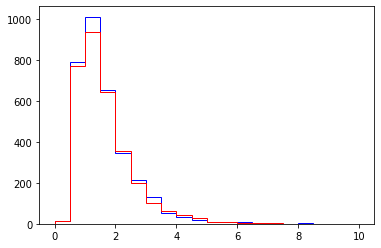

In [ ]:
plt.hist(mic2_rt[mic2_choice<2],
            density=False,
            histtype='step',
            color = 'blue',
            range=(0,10),
            bins=20)
plt.hist(mic2_rt[(mic2_choice==0) | (mic2_choice==2)],
            density=False,
            histtype='step',
            color = 'red',
            range=(0,10),
            bins=20)

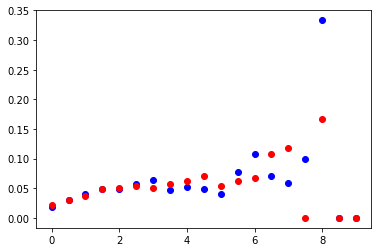

In [ ]:
plt.plot(np.arange(0, 10, step=0.5),mic2_high_err,'bo')
plt.plot(np.arange(0, 10, step=0.5),mic2_low_err,'ro')

<BarContainer object of 4 artists>

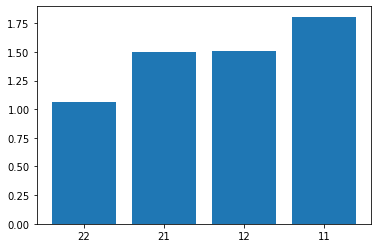

In [ ]:
coh_conds = ['22','21','12','11']
mic2_mean_rt = []
for i in [2,1]:
  for j in [2,1]:
    mic2_mean_rt.append(np.mean(np.concatenate([mic2_out['{}1{}'.format(i,j)][0],mic2_out['{}2{}'.format(i,j)][0]])))
plt.bar(coh_conds,mic2_mean_rt)